# Sliding time window laminar model comparison with two simultaneous sources

This tutorial demonstrates how to perform laminar inference of beta bursts in a sliding time window using model comparison based on free energy as a metric of model fit, described in [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479). Two temporal Gaussian functions are simulated simultaneously in deep and superficial layers at a particular cortical location. Source reconstruction is performed on the whole time window using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on the multilayer mesh as a localizer. This is used to select priors on each layer mesh for a sliding time window model comparison using free energy.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
%env SUBJECTS_DIR=../test_data/fs

env: SUBJECTS_DIR=../test_data/fs


In [2]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt
import k3d
import tempfile
from IPython.display import Image
import base64

from lameg.invert import coregister, invert_ebb, load_source_time_series
from lameg.laminar import sliding_window_model_comparison
from lameg.simulate import run_dipole_simulation
from lameg.surf import LayerSurfaceSet
from lameg.util import get_fiducial_coords
from lameg.viz import show_surface, color_map, rgbtoint
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
fid_coords = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    f'spm/pspm-converted_autoreject-{subj_id}-{ses_id}-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [3]:
surf_set_bilam = LayerSurfaceSet(subj_id, 2)
surf_set = LayerSurfaceSet(subj_id, 11)

verts_per_surf = surf_set.get_vertices_per_layer()

We're going to copy the data file to a temporary directory and direct all output there.

In [4]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = tempfile.mkdtemp()

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [5]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    fid_coords, 
    base_fname,
    surf_set,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    base_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
27-Oct-2025 21:19:30 - Running job #1
------------------------------------------------------------------------
27-Oct-2025 21:19:30 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           21:19:32 - 27/10/2025
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-99 100]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 274
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -4.0460e+05
      PostMax: [562001x1 double]
            A: [274x274 double]
           Ip: [1x512 double]
            M: [562001x274 double]
            J: {[562001x4 double]}
            L: [274x562001 double]
           qC: [562001x1 double]
        tempU: [102x102 double]
            V: [102x4 double]
           qV: [120x120 double]
            T: [120x4 double]
            U: {[274x274 double]}
           Is: [1x562001 double]
           It: [1x120 double]
           Ik: [1x60 double]
           Ic: {[1x274 double]}
           Nd: 562001
          pst: [1x120 double]
          dct: [1x102 double]
           ID: 255.0259
            F: -4.0460e+05
           R2: 99.8494
           VE: 56.9085

## Simulating a beta burst
We're going to simulate a beta burst as two dipoles. One in the deep layer, a more narrow but stronger drive in the superficial layer (see [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479))

Text(0, 0.5, 'Amplitude (nAm)')

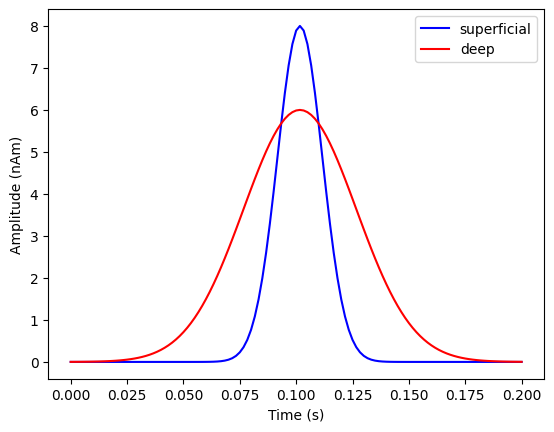

In [6]:
# Strength of each simulated source (nAm)
dipole_moment = [8, 6]
# Temporal width of the simulated superficial signal
superficial_width = .01 # 10ms
# Temporal width of the simulated deep signal
deep_width = .025 # 25ms

# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,.2,121)
zero_time = time[int((len(time)-1)/2+1)]
superficial_signal = np.exp(-((time-zero_time)**2)/(2*superficial_width**2))
deep_signal = np.exp(-((time-zero_time)**2)/(2*deep_width**2))

plt.plot(time,superficial_signal*dipole_moment[0], 'b', label='superficial')
plt.plot(time,deep_signal*dipole_moment[1], 'r', label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at. The superficial signal will be simulated as a dipole at the corresponding vertex on the pial surface, and the deep signal on the white matter surface. The dipole orientations will be in opposite directions (with the superficial one pointing toward the deep one, and vice versa). This will yield a cumulative dipole moment with a beta burst-like shape

In [8]:
# Location to simulate activity at
sim_vertex=50492
# Corresponding pial and white matter vertices
pial_vertex = surf_set.get_multilayer_vertex('pial', sim_vertex)
multilayer_mesh = surf_set.load(stage='ds', orientation='link_vector', fixed=True)
white_vertex = surf_set.get_multilayer_vertex('white', sim_vertex)
pial_coord = multilayer_mesh.darrays[0].data[pial_vertex,:]
white_coord = multilayer_mesh.darrays[0].data[white_vertex,:]

# Orientation of the simulated superficial dipole
pial_ori=multilayer_mesh.darrays[2].data[pial_vertex,:]
# Orientation of the simulated deep dipole
white_ori=-1*multilayer_mesh.darrays[2].data[white_vertex,:]

col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))

pial_mesh = surf_set.load(layer_name='pial', stage='combined')
white_mesh = surf_set.load(layer_name='white', stage='combined')

cam_view = [85.5, -10.5, 32,
            0.5, 17, 43,
            0, 0, 1]

plot = k3d.plot(
    grid_visible=False, menu_visibility=False, camera_auto_fit=False
)

pial_vertices, pial_faces, _ = pial_mesh.agg_data()
pial_k3d_mesh = k3d.mesh(pial_vertices, pial_faces, side="double", color=rgbtoint(col_r[0,:3]*255), opacity=0.5)
plot += pial_k3d_mesh

white_vertices, white_faces, _ = white_mesh.agg_data()
white_k3d_mesh = k3d.mesh(white_vertices, white_faces, side="double", color=rgbtoint(col_r[-1,:3]*255), opacity=1)
plot += white_k3d_mesh

pts = k3d.points(
    np.vstack([pial_coord, white_coord]),
    point_size=1,
    color=rgbtoint([0,0,0])
)
plot += pts

dipole_vectors = k3d.vectors(
    np.vstack([pial_coord, white_coord]),
    vectors=np.vstack([pial_ori, white_ori])*2.3,
    head_size=5,
    line_width=0.1,
    colors=[rgbtoint([0,0,255]), rgbtoint([0,0,255]),
            rgbtoint([255,0,0]), rgbtoint([255,0,0])]
)
plot += dipole_vectors

plot.camera=cam_view

plot.display()

Output()

In [9]:
plot.fetch_screenshot()

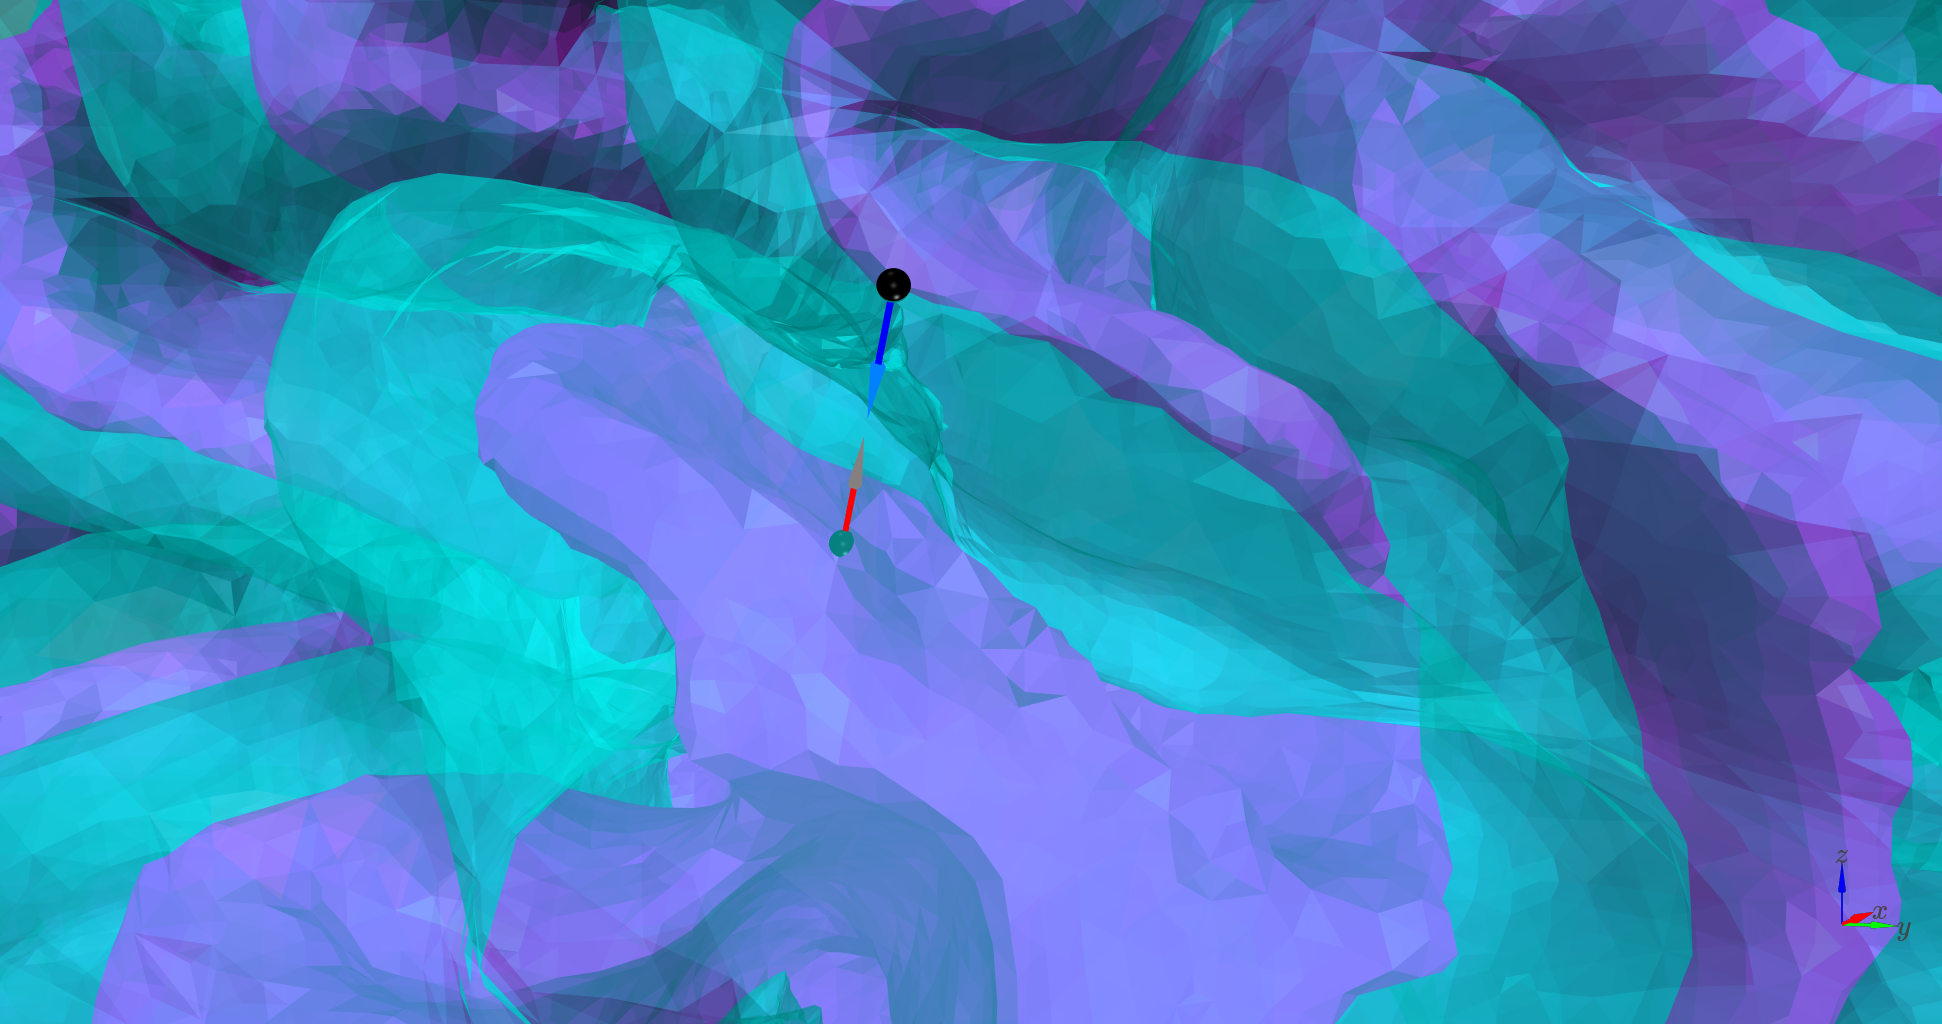

In [10]:
Image(data=base64.b64decode(plot.screenshot))

We'll simulate a 5mm patch of activity with -10 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [11]:
# Simulate a beta burst as two sources: one deep and one superficial
prefix=f'sim_{sim_vertex}_burst_'

# Size of simulated sources (mm)
sim_dipfwhm=[5, 5] # mm
# SNR of simulated data (dB)
SNR=-10

# Generate simulated data
burst_sim_fname=run_dipole_simulation(
    base_fname, 
    prefix, 
    [pial_vertex, white_vertex],
    np.vstack([superficial_signal, deep_signal]),
    np.vstack([pial_ori, white_ori]),
    dipole_moment, 
    sim_dipfwhm, 
    SNR,
    spm_instance=spm
)

IdleTimeout has been reached.
Parallel pool using the 'local' profile is shutting down.
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -10B

 Finish


## Localizer inversion
Now we'll run a source reconstruction using the multilayer mesh, extract the signal in the pial layer, and select a prior based on the peak.

In [12]:
[_,_,MU] = invert_ebb(
    burst_sim_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, _ = load_source_time_series(
    burst_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')

Smoothing ../test_data/fs/sub-104/surf/laminar/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmpaqk397fo/sim_50492_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have b

We can see that the peak is very close to the location we simulated at

In [13]:
# Plot colors and camera view
max_abs = np.max(np.abs(m_layer_max))
c_range = [-max_abs, max_abs]
cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]

# Plot peak
colors,_ = color_map(
    m_layer_max, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)
thresh_colors=np.ones((colors.shape[0],4))*255
thresh_colors[:,:3]=colors
thresh_colors[m_layer_max<np.percentile(m_layer_max,99.9),3]=0

plot = show_surface(
    surf_set, 
    vertex_colors=thresh_colors, 
    info=True, 
    camera_view=cam_view, 
    marker_vertices=prior, 
    marker_size=5, 
    marker_color=[0,0,255]
)

Output()

51091 vertices


In [14]:
plot.fetch_screenshot()

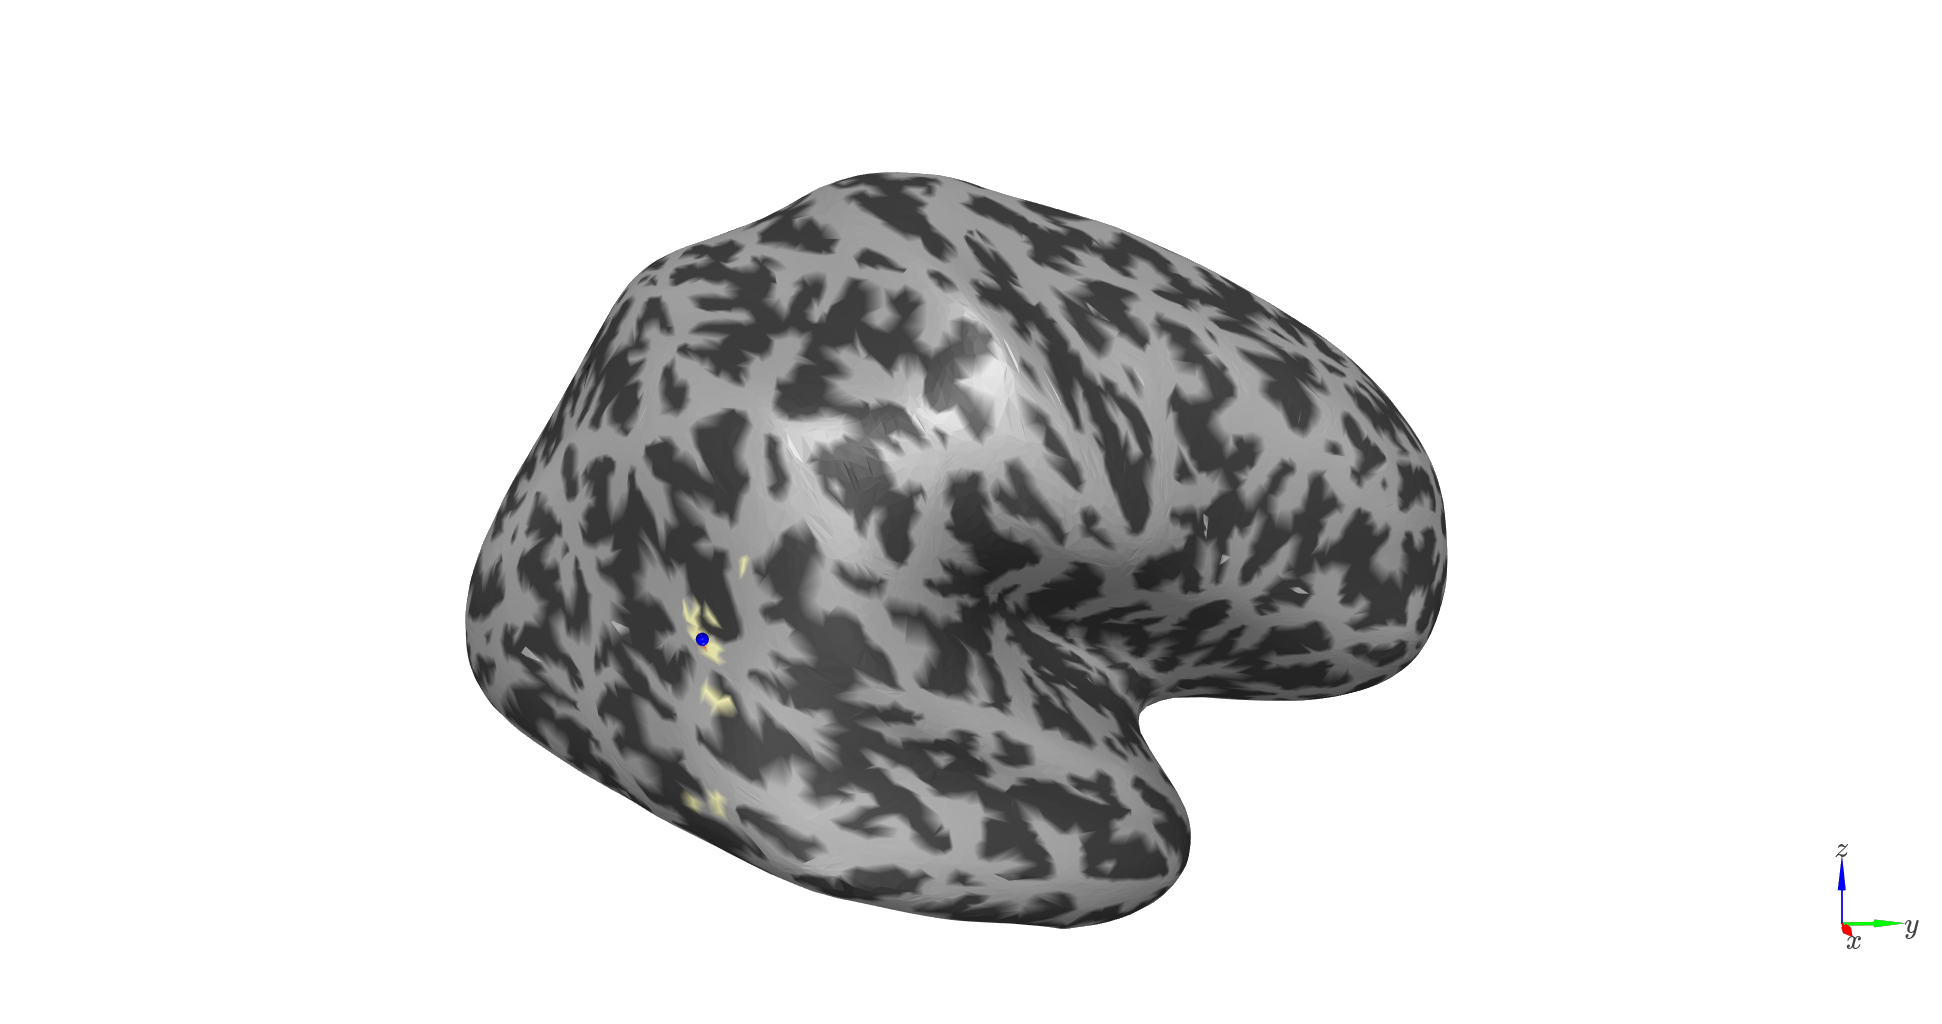

In [15]:
Image(data=base64.b64decode(plot.screenshot))

## Sliding time window model comparison (pial - white matter)
Now we can run sliding time window model comparison between source models based on the pial and white matter surfaces using free energy. Specifically, we'll look at the difference in free energy between the two models (pial - white matter), in sliding and overlapping windows of 16ms. Because this window is so short, we'll use 2 temporal modes. If you increase the size of the window, you may have to increase the number of temporal modes. The free energy difference (pial - white matter) should be negative (more model evidence for the white matter surface model) at the start and end of the burst, and positive (more model evidence for the pial surface model) at the peak of the burst.

In [16]:
# Number of temporal models for sliding time window inversion
sliding_n_temp_modes = 4
# Size of sliding window (in ms)
win_size = 16
# Whether or not windows overlap
win_overlap = True

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    fid_coords, 
    burst_sim_fname, 
    surf_set_bilam,
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': sliding_n_temp_modes,
        'win_size': win_size, 
        'win_overlap': win_overlap    
    }
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Oct-2025 06:59:46 - Running job #1
------------------------------------------------------------------------
28-Oct-2025 06:59:46 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           07:00:47 - 28/10/2025
pial.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating lay

    0.00   -0.06
    9.47   -3.52

  ReML Iteration              : 1                            ...1.086543e+02
  ReML Iteration 4                      :        ...1.038185e+02 [+4.50]
  ReML Iteration 5                      :        ...8.338248e+01 [+4.62]
  ReML Iteration 6                      :        ...4.465527e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.47   -3.51

  ReML Iteration              : 1                            ...1.086357e+02
  ReML Iteration 5                      :        ...8.338248e+01 [+4.62]
  ReML Iteration 6                      :        ...4.465527e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.47   -3.51

  ReML Iteration              : 1                            ...1.086357e+02
  ReML Iteration 2                      :        ...1.186028e+02 [+4.25]
  ReML Iteration 3                      :        ...1.124558e+02 [+4.38]
  ReML Iteration 4                      :        ...1.024040e+02 [+4.50]
  ReML Iteration

  ReML Iteration              : 2                            ...8.517298e+01
  ReML Iteration              : 3                            ...7.197606e+01
  ReML Iteration              : 4                            ...6.264124e+01
  ReML Iteration              : 5                            ...5.486595e+01
  ReML Iteration              : 6                            ...4.757994e+01
  ReML Iteration              : 7                            ...4.027312e+01
  ReML Iteration              : 8                            ...3.282703e+01
  ReML Iteration              : 9                            ...2.545798e+01
  ReML Iteration              : 10                            ...1.861274e+01
  ReML Iteration              : 11                            ...1.277111e+01
  ReML Iteration              : 12                            ...8.233231e+00
  ReML Iteration              : 13                            ...5.019293e+00
  ReML Iteration              : 14                            ...2.92387

  ReML Iteration              : 20                            ...7.645308e-02
  ReML Iteration              : 21                            ...4.632011e-02
  ReML Iteration              : 22                            ...3.065146e-02
  ReML Iteration              : 23                            ...2.299169e-02
  ReML Iteration              : 24                            ...2.059750e-02
  ReML Iteration              : 25                            ...2.393713e-02
  ReML Iteration              : 26                            ...4.182844e-02
  ReML Iteration              : 27                            ...1.374972e-01
  ReML Iteration              : 28                            ...3.749041e-01
  ReML Iteration              : 29                            ...1.858493e-05
Inverting subject 1
  ReML Iteration              : 22                            ...8.692473e-03
Inverting subject 1
  ReML Iteration              : 21                            ...2.093885e-02
  ReML Iteration        

  ReML Iteration              : 17                            ...5.031247e-01
  ReML Iteration              : 18                            ...2.824050e-01
  ReML Iteration              : 19                            ...1.660848e-01
  ReML Iteration              : 20                            ...1.074904e-01
  ReML Iteration              : 21                            ...8.386923e-02
  ReML Iteration              : 22                            ...9.505558e-02
  ReML Iteration              : 23                            ...2.193101e-01
  ReML Iteration              : 24                            ...4.045773e-01
  ReML Iteration              : 25                            ...5.832559e-05
Inverting subject 1
  ReML Iteration 1                      :        ...1.219184e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194311e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171636e+02 [+4.38]
  ReML Iteration 4                      :        ...1.11681

  ReML Iteration              : 19                            ...1.339483e-01
  ReML Iteration              : 20                            ...7.645308e-02
  ReML Iteration              : 21                            ...4.632011e-02
  ReML Iteration              : 22                            ...3.065146e-02
  ReML Iteration              : 23                            ...2.299169e-02
  ReML Iteration              : 24                            ...2.059750e-02
  ReML Iteration              : 25                            ...2.393713e-02
  ReML Iteration              : 26                            ...4.182844e-02
  ReML Iteration              : 27                            ...1.374972e-01
  ReML Iteration              : 28                            ...3.749041e-01
  ReML Iteration              : 29                            ...1.858493e-05
Inverting subject 1
  ReML Iteration              : 17                            ...3.353439e-01
  ReML Iteration              : 18          

  ReML Iteration 1                      :        ...1.219467e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194027e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170881e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114879e+02 [+4.50]
  ReML Iteration 5                      :        ...4.254931e-04 [+4.62]
Percent variance explained -25.31 (-24.68)
  ReML Iteration 1                      :        ...1.220379e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193142e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168529e+02 [+4.38]
  ReML Iteration 4                      :        ...1.108870e+02 [+4.50]
  ReML Iteration 5                      :        ...4.952970e-03 [+4.62]
Percent variance explained -59.92 (-53.64)
  ReML Iteration              : 19                            ...9.593868e-02
  ReML Iteration              : 20                            ...4.905534e-02
  ReML Iteration            

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.315325e+03 [+4.12]
  ReML Iteration 2                      :        ...2.988533e+02 [+4.25]
  ReML Iteration 3                      :        ...3.138901e+00 [+4.38]
  ReML Iteration 4                      :        ...1.380592e-02 [+4.50]
  ReML Iteration 5                      :        ...6.598771e-07 [+4.62]
log evidence & hyperparameters:
    0.00 9955.53
    9.42    0.46

  ReML Iteration              : 1                            ...2.292217e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.37 percent averag

  ReML Iteration              : 2                            ...1.290229e+02
  ReML Iteration              : 3                            ...1.399170e+01
  ReML Iteration              : 4                            ...2.311214e+00
  ReML Iteration              : 5                            ...4.674764e-01
  ReML Iteration              : 6                            ...1.090243e-01
  ReML Iteration              : 7                            ...2.849471e-02
  ReML Iteration              : 8                            ...8.167554e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.406622e

  ReML Iteration 1                      :        ...3.656015e+03 [+4.12]
  ReML Iteration 2                      :        ...2.004854e+02 [+4.25]
  ReML Iteration 3                      :        ...1.069746e+01 [+4.38]
  ReML Iteration 4                      :        ...3.338211e-01 [+4.50]
  ReML Iteration 5                      :        ...2.108584e-04 [+4.62]
Percent variance explained 95.44 (87.12)
  ReML Iteration              : 2                            ...1.929684e+03
  ReML Iteration              : 3                            ...3.040175e+02
  ReML Iteration              : 4                            ...5.127414e+01
  ReML Iteration              : 5                            ...1.014446e+01
  ReML Iteration              : 6                            ...2.331044e+00
  ReML Iteration              : 7                            ...6.047088e-01
  ReML Iteration              : 8                            ...1.727307e-01
  ReML Iteration              : 9                      

  ReML Iteration              : 2                            ...6.191295e+01
  ReML Iteration              : 3                            ...1.372232e+01
  ReML Iteration              : 4                            ...3.673136e+00
  ReML Iteration              : 5                            ...9.560759e-01
  ReML Iteration              : 6                            ...2.523588e-01
  ReML Iteration              : 7                            ...7.006626e-02
  ReML Iteration              : 8                            ...2.069840e-02
  ReML Iteration              : 9                            ...6.496448e-03
Inverting subject 1
  ReML Iteration 1                      :        ...7.818399e+03 [+4.12]
  ReML Iteration 2                      :        ...9.243816e+02 [+4.25]
  ReML Iteration 3                      :        ...1.094460e+01 [+4.38]
  ReML Iteration 4                      :        ...2.436229e-02 [+4.50]
  ReML Iteration 5                      :        ...4.696922e-07 [+4.62]

  ReML Iteration 1                      :        ...1.289113e+03 [+4.12]
  ReML Iteration 2                      :        ...8.525914e+01 [+4.25]
  ReML Iteration 3                      :        ...3.001037e+01 [+4.38]
  ReML Iteration 4                      :        ...3.681078e+00 [+4.50]
  ReML Iteration 5                      :        ...3.512714e-02 [+4.62]
  ReML Iteration 6                      :        ...1.759191e-06 [+4.75]
Percent variance explained 91.87 (82.79)
  ReML Iteration 1                      :        ...1.110541e+04 [+4.12]
  ReML Iteration 2                      :        ...2.093286e+03 [+4.25]
  ReML Iteration 3                      :        ...4.847515e+01 [+4.38]
  ReML Iteration 4                      :        ...2.300519e-02 [+4.50]
  ReML Iteration 5                      :        ...2.915774e-09 [+4.62]
Percent variance explained 97.48 (87.68)
  ReML Iteration 1                      :        ...1.277906e+04 [+4.12]
  ReML Iteration 2                      : 

  ReML Iteration 5                      :        ...2.144695e-06 [+4.62]
log evidence & hyperparameters:
    0.00 25954.74
    9.34    1.73

  ReML Iteration              : 1                            ...9.223467e+03
  ReML Iteration 1                      :        ...6.276359e+03 [+4.12]
  ReML Iteration 2                      :        ...5.685725e+02 [+4.25]
  ReML Iteration 3                      :        ...7.329332e+00 [+4.38]
  ReML Iteration 4                      :        ...5.688610e-02 [+4.50]
  ReML Iteration 5                      :        ...4.089504e-06 [+4.62]
Percent variance explained 96.56 (84.49)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.41 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.034587e+02 [+4.12]
  ReML Iteration 2                      :        ...1.049723e+02 [+4.25]
  ReML Iteration 3                      :        ...7.451120e+01 [+4.38]
  ReML Iteration 4                      :        ...3.548169e+01 [+4.50]
  ReML Iteration 5                      :        ...5.999294e+00 [+4.62]
  ReML Iteration 6                      :        ...1.228461e-01 [+4.75]
  ReML Iteration 7                      :        ...4.686613e-05 [+4.88]
log evidence & hyperparameters:
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration 1                      :        ...1.230285e+04 [+4.12]
  ReML Iteration 2                      :        ...2.676683e+03 [+4.25]
  ReML Iteration 3                      :        ...8.205313e+01 [+4.38]
  ReML Iteration 4                      :        ...5.788060e-02 [+4.50]
  ReML Iteration 5                      :        ...2.436972e-08 [+4.62]
Percent variance explained 94.64 (89.85)
  ReML Iteration              : 2                            ...8.385225e+01
  ReML Iteration              : 3                            ...6.971159e+01
  ReML Iteration              : 4                            ...5.906964e+01
  ReML Iteration              : 5                            ...4.963141e+01
  ReML Iteration              : 6                            ...4.047472e+01
  ReML Iteration              : 7                            ...3.142475e+01
  ReML Iteration              : 8                            ...2.283474e+01
  ReML Iteration              : 9                      

  ReML Iteration              : 2                            ...9.320305e+02
  ReML Iteration              : 3                            ...1.148673e+02
  ReML Iteration              : 4                            ...1.748495e+01
  ReML Iteration              : 5                            ...3.324711e+00
  ReML Iteration              : 6                            ...7.515107e-01
  ReML Iteration              : 7                            ...1.935161e-01
  ReML Iteration              : 8                            ...5.507911e-02
  ReML Iteration              : 9                            ...1.696573e-02
  ReML Iteration              : 10                            ...5.570869e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.028105e+04 [+4.12]
  ReML Iteration 2                      :        ...1.742964e+03 [+4.25]
  ReML Iteration 3                      :        ...3.318389e+01 [+4.38]
  ReML Iteration 4                      :        ...1.502713e-02 [+

  ReML Iteration              : 2                            ...7.363651e+01
  ReML Iteration              : 3                            ...5.333683e+01
  ReML Iteration              : 4                            ...3.657924e+01
  ReML Iteration              : 5                            ...2.267554e+01
  ReML Iteration              : 6                            ...1.239070e+01
  ReML Iteration              : 7                            ...5.957090e+00
  ReML Iteration              : 8                            ...2.572890e+00
  ReML Iteration              : 9                            ...1.032971e+00
  ReML Iteration              : 10                            ...3.990635e-01
  ReML Iteration              : 11                            ...1.523522e-01
  ReML Iteration              : 12                            ...5.846562e-02
  ReML Iteration              : 13                            ...2.276550e-02
  ReML Iteration              : 14                            ...9.03449

  ReML Iteration 1                      :        ...7.844872e+03 [+4.12]
  ReML Iteration 2                      :        ...9.314864e+02 [+4.25]
  ReML Iteration 3                      :        ...1.105695e+01 [+4.38]
  ReML Iteration 4                      :        ...2.404393e-02 [+4.50]
  ReML Iteration 5                      :        ...4.521989e-07 [+4.62]
Percent variance explained 92.75 (79.94)
  ReML Iteration 1                      :        ...1.601845e+02 [+4.12]
  ReML Iteration 2                      :        ...1.101494e+02 [+4.25]
  ReML Iteration 3                      :        ...9.414763e+01 [+4.38]
  ReML Iteration 4                      :        ...6.250551e+01 [+4.50]
  ReML Iteration 5                      :        ...2.237336e+01 [+4.62]
  ReML Iteration 6                      :        ...3.112546e+01 [+3.62]
  ReML Iteration 7                      :        ...7.177699e-03 [+3.75]
Percent variance explained -4819.53 (-4308.96)
Number of samples 11
Fixed number of

  ReML Iteration 5                      :        ...4.191421e+00 [+4.62]
  ReML Iteration 6                      :        ...5.685501e-02 [+4.75]
  ReML Iteration 7                      :        ...1.003761e-05 [+4.88]
log evidence & hyperparameters:
    0.00  855.68
    9.48   -1.91

  ReML Iteration              : 1                            ...1.362528e+02
  ReML Iteration 1                      :        ...7.779472e+03 [+4.12]
  ReML Iteration 2                      :        ...9.139975e+02 [+4.25]
  ReML Iteration 3                      :        ...1.078303e+01 [+4.38]
  ReML Iteration 4                      :        ...2.484104e-02 [+4.50]
  ReML Iteration 5                      :        ...4.966024e-07 [+4.62]
Percent variance explained 97.25 (90.07)
    0.00   -0.01
    9.48   -3.24

  ReML Iteration              : 1                            ...1.082699e+02
  ReML Iteration              : 2                            ...1.169150e+03
  ReML Iteration              : 3         

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.156402e+03 [+4.12]
  ReML Iteration 2                      :        ...1.703593e+02 [+4.25]
  ReML Iteration 3                      :        ...5.664071e+00 [+4.38]
  ReML Iteration 4                      :        ...9.110245e-02 [+4.50]
  ReML Iteration 5                      :        ...2.386950e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7353.13
    9.44    0.13

  ReML Iteration              : 1                            ...1.420300e+03
  ReML Iteration 4                      :        ...5.610615e+01 [+4.50]
  ReML Iteration 5                    

  ReML Iteration              : 2                            ...7.213213e+01
  ReML Iteration              : 3                            ...5.107365e+01
  ReML Iteration              : 4                            ...3.391456e+01
  ReML Iteration              : 5                            ...2.014589e+01
  ReML Iteration              : 6                            ...1.047724e+01
  ReML Iteration              : 7                            ...4.793528e+00
  ReML Iteration              : 8                            ...1.983326e+00
  ReML Iteration              : 9                            ...7.706438e-01
  ReML Iteration              : 10                            ...2.910563e-01
  ReML Iteration              : 11                            ...1.094931e-01
  ReML Iteration              : 12                            ...4.163031e-02
  ReML Iteration              : 13                            ...1.611689e-02
  ReML Iteration              : 14                            ...6.37312

  ReML Iteration 1                      :        ...1.705487e+02 [+4.12]
  ReML Iteration 2                      :        ...1.088590e+02 [+4.25]
  ReML Iteration 3                      :        ...9.119762e+01 [+4.38]
  ReML Iteration 4                      :        ...5.751180e+01 [+4.50]
  ReML Iteration 5                      :        ...1.819395e+01 [+4.62]
  ReML Iteration 6                      :        ...1.276326e+00 [+4.75]
  ReML Iteration 7                      :        ...4.120134e+01 [+3.75]
  ReML Iteration 8                      :        ...1.249920e-02 [+3.88]
  ReML Iteration 9                      :        ...1.146810e-09 [+4.00]
Percent variance explained -4913.25 (-4103.95)
  ReML Iteration 1                      :        ...1.234575e+02 [+4.12]
  ReML Iteration 2                      :        ...1.182892e+02 [+4.25]
  ReML Iteration 3                      :        ...1.141510e+02 [+4.38]
  ReML Iteration 4                      :        ...1.041393e+02 [+4.50]
  Re

  ReML Iteration              : 2                            ...8.466314e+01
  ReML Iteration              : 3                            ...7.109754e+01
  ReML Iteration              : 4                            ...6.124186e+01
  ReML Iteration              : 5                            ...5.278291e+01
  ReML Iteration              : 6                            ...4.468694e+01
  ReML Iteration              : 7                            ...3.655406e+01
  ReML Iteration              : 8                            ...2.845012e+01
  ReML Iteration              : 9                            ...2.079273e+01
  ReML Iteration              : 10                            ...1.414068e+01
  ReML Iteration              : 11                            ...8.917770e+00
  ReML Iteration              : 12                            ...5.228128e+00
  ReML Iteration              : 13                            ...2.870313e+00
  ReML Iteration              : 14                            ...1.49110

model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 through 7

   -3.9696   -3.7796   -3.7704   -3.7550   -3.6822   -3.6822   -3.5887

  Columns 8 through 14

   -3.5320   -3.5175   -3.4720   -3.4571   -3.4500   -3.4389   -3.3866

  Columns 15 through 21

   -3.3826   -3.3707   -3.3433   -3.3357   -3.3316   -3.3055   -3.2873

  Columns 22 through 28

   -3.2259   -3.1972   -3.1530   -3.0540   -3.0424   -3.0143   -2.9947

  Columns 29 through 35

   -2.9547   -2.9361   -2.9075   -2.7335   -2.7255   -2.6442   -2.2971

  Columns 36 through 42

   -2.2800   -2.2413   -2.2017   -2.0770   -2.0406   -1.9688   -1.8075

  Columns 43 through 49

   -1.7696   -1.7589   -1.6500   -1.6498   -1.6301   -1.6206   -1.5793

  Columns 50 through 56

   -1.5596   -1.4849   -1.4523   -1.4012   -1.3958   -1.3186   -1.2768

  Columns 57 through 63

   -1.2210   -1.2133   -1.1966   -1.1428   -1.1057   -1.1026   -1.0758

  Columns 64 through 70

   -1.0079   -0.9966   -0.9827   -0.9610   -0.

  ReML Iteration              : 2                            ...8.515902e+01
  ReML Iteration              : 3                            ...7.195194e+01
  ReML Iteration              : 4                            ...6.260257e+01
  ReML Iteration              : 5                            ...5.480783e+01
  ReML Iteration              : 6                            ...4.749805e+01
  ReML Iteration              : 7                            ...4.016565e+01
  ReML Iteration              : 8                            ...3.269697e+01
  ReML Iteration              : 9                            ...2.531434e+01
  ReML Iteration              : 10                            ...1.846897e+01
  ReML Iteration              : 11                            ...1.264082e+01
  ReML Iteration              : 12                            ...8.125532e+00
  ReML Iteration              : 13                            ...4.936876e+00
  ReML Iteration              : 14                            ...2.86427

  ReML Iteration              : 2                            ...8.510165e+01
  ReML Iteration              : 3                            ...7.185281e+01
  ReML Iteration              : 4                            ...6.244385e+01
  ReML Iteration              : 5                            ...5.456961e+01
  ReML Iteration              : 6                            ...4.716307e+01
  ReML Iteration              : 7                            ...3.972737e+01
  ReML Iteration              : 8                            ...3.216878e+01
  ReML Iteration              : 9                            ...2.473410e+01
  ReML Iteration              : 10                            ...1.789208e+01
  ReML Iteration              : 11                            ...1.212217e+01
  ReML Iteration              : 12                            ...7.700906e+00
  ReML Iteration              : 13                            ...4.615727e+00
  ReML Iteration              : 14                            ...2.63553

  ReML Iteration              : 21                            ...6.395755e-02
  ReML Iteration              : 22                            ...5.425749e-02
  ReML Iteration              : 23                            ...6.716636e-02
  ReML Iteration              : 24                            ...1.632162e-01
  ReML Iteration              : 25                            ...4.036746e-01
  ReML Iteration              : 26                            ...4.259279e-05
Inverting subject 1
  ReML Iteration              : 2                            ...8.500550e+01
  ReML Iteration              : 3                            ...7.168685e+01
  ReML Iteration              : 4                            ...6.217863e+01
  ReML Iteration              : 5                            ...5.417274e+01
  ReML Iteration              : 6                            ...4.660753e+01
  ReML Iteration              : 7                            ...3.900522e+01
  ReML Iteration              : 8                 

  ReML Iteration 1                      :        ...1.219290e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194204e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171351e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116083e+02 [+4.50]
  ReML Iteration 5                      :        ...1.143509e-04 [+4.62]
Percent variance explained -35.09 (-35.09)
  ReML Iteration              : 21                            ...3.342351e-02
  ReML Iteration              : 22                            ...1.886452e-02
  ReML Iteration              : 23                            ...1.102001e-02
  ReML Iteration              : 24                            ...6.682424e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.220505e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193024e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168215e+02 [+4.38]
  ReML Iteration 4                      :

  ReML Iteration 1                      :        ...1.219734e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193763e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170179e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113083e+02 [+4.50]
  ReML Iteration 5                      :        ...1.257830e-03 [+4.62]
Percent variance explained -21.19 (-20.66)
  ReML Iteration              : 20                            ...6.099073e-02
  ReML Iteration              : 21                            ...3.342351e-02
  ReML Iteration              : 22                            ...1.886452e-02
  ReML Iteration              : 23                            ...1.102001e-02
  ReML Iteration              : 24                            ...6.682424e-03
Inverting subject 1
  ReML Iteration              : 18                            ...1.523116e-01
  ReML Iteration              : 19                            ...7.480340e-02
  ReML Iteration          

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.723866e+03 [+4.12]
  ReML Iteration 2                      :        ...1.377816e+02 [+4.25]
  ReML Iteration 3                      :        ...8.032734e+00 [+4.38]
  ReML Iteration 4                      :        ...2.025698e-01 [+4.50]
  ReML Iteration 5                      :        ...1.131741e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6317.93
    9.43    0.49

  ReML Iteration              : 1                            ...1.118629e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.51 percent averag

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.33 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.467982e+04 [+4.12]
  ReML Iteration 2                      :        ...4.658178e+03 [+4.25]
  ReML Iteration 3                      :        ...4.096163e+02 [+4.38]
  ReML Iteration 4                      :        ...3.088083e+00 [+4.50]
  ReML Iteration 5                      :        ...1.773104e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31442.84
    9.18    2.47

  ReML Iteration              : 1                            ...1.163482e+04
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.66 percent avera

  ReML Iteration              : 2                            ...6.267505e+01
  ReML Iteration              : 3                            ...1.356605e+01
  ReML Iteration              : 4                            ...3.584281e+00
  ReML Iteration              : 5                            ...9.261496e-01
  ReML Iteration              : 6                            ...2.435063e-01
  ReML Iteration              : 7                            ...6.747245e-02
  ReML Iteration              : 8                            ...1.991147e-02
  ReML Iteration              : 9                            ...6.246042e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280

  ReML Iteration              : 2                            ...1.334775e+02
  ReML Iteration              : 3                            ...1.428273e+01
  ReML Iteration              : 4                            ...2.329267e+00
  ReML Iteration              : 5                            ...4.679066e-01
  ReML Iteration              : 6                            ...1.087710e-01
  ReML Iteration              : 7                            ...2.838499e-02
  ReML Iteration              : 8                            ...8.130072e-03
Inverting subject 1
  ReML Iteration 1                      :        ...3.746195e+03 [+4.12]
  ReML Iteration 2                      :        ...2.087036e+02 [+4.25]
  ReML Iteration 3                      :        ...1.039462e+01 [+4.38]
  ReML Iteration 4                      :        ...3.111201e-01 [+4.50]
  ReML Iteration 5                      :        ...1.812355e-04 [+4.62]
Percent variance explained 96.68 (88.26)
  ReML Iteration              : 2  

  ReML Iteration 1                      :        ...1.316806e+03 [+4.12]
  ReML Iteration 2                      :        ...8.551358e+01 [+4.25]
  ReML Iteration 3                      :        ...2.951681e+01 [+4.38]
  ReML Iteration 4                      :        ...3.539922e+00 [+4.50]
  ReML Iteration 5                      :        ...3.229568e-02 [+4.62]
  ReML Iteration 6                      :        ...1.448870e-06 [+4.75]
Percent variance explained 92.98 (83.79)
  ReML Iteration 1                      :        ...6.440503e+03 [+4.12]
  ReML Iteration 2                      :        ...6.011965e+02 [+4.25]
  ReML Iteration 3                      :        ...7.479483e+00 [+4.38]
  ReML Iteration 4                      :        ...5.165386e-02 [+4.50]
  ReML Iteration 5                      :        ...3.250475e-06 [+4.62]
Percent variance explained 97.84 (85.62)
  ReML Iteration 1                      :        ...1.311597e+04 [+4.12]
  ReML Iteration 2                      : 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.724328e+03 [+4.12]
  ReML Iteration 2                      :        ...1.047699e+03 [+4.25]
  ReML Iteration 3                      :        ...1.564681e+01 [+4.38]
  ReML Iteration 4                      :        ...3.252205e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16964.08
    9.45    1.71

  ReML Iteration              : 1                            ...5.161026e+03
  ReML Iteration 1                      :        ...2.694690e+03 [+4.12]
  ReML Iteration 2                      :        ...1.308048e+02 [+4.25]
  ReML Iteration 3                   

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.02 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.873992e+03 [+4.12]
  ReML Iteration 2                      :        ...1.838761e+03 [+4.25]
  ReML Iteration 3                      :        ...5.255792e+01 [+4.38]
  ReML Iteration 4                      :        ...3.939708e-02 [+4.50]
  ReML Iteration 5                      :        ...2.155669e-08 [+4.62]
log evidence & hyperparameters:
    0.00 21273.61
    9.43    2.02

  ReML Iteration              : 1                            ...7.100503e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent avera

  ReML Iteration              : 2                            ...5.122212e+02
  ReML Iteration              : 3                            ...5.458995e+01
  ReML Iteration              : 4                            ...7.915462e+00
  ReML Iteration              : 5                            ...1.479586e+00
  ReML Iteration              : 6                            ...3.321618e-01
  ReML Iteration              : 7                            ...8.527191e-02
  ReML Iteration              : 8                            ...2.423439e-02
  ReML Iteration              : 9                            ...7.459038e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.947772e+03
  ReML Iteration              : 3                            ...3.079981e+02
  ReML Iteration              : 4                            ...5.203504e+01
  ReML Iteration              : 5                            ...1.030225e+01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...5.811794e+03 [+4.12]
  ReML Iteration 2                      :        ...4.826930e+02 [+4.25]
  ReML Iteration 3                      :        ...7.152940e+00 [+4.38]
  ReML Iteration 4                      :        ...7.531512e-02 [+4.50]
  ReML Iteration 5                      :        ...7.870757e-06 [+4.62]
Percent variance explained 87.82 (79.21)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.18 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.204023e+03 [+4.12]
  ReML Iteration 2                      :        ...2.838821e+02 [+4.25]
  ReML Iteration 3                      :        ...3.218960e+00 [+4

  ReML Iteration 1                      :        ...7.955642e+03 [+4.12]
  ReML Iteration 2                      :        ...9.615947e+02 [+4.25]
  ReML Iteration 3                      :        ...1.154920e+01 [+4.38]
  ReML Iteration 4                      :        ...2.277331e-02 [+4.50]
  ReML Iteration 5                      :        ...3.855469e-07 [+4.62]
Percent variance explained 98.36 (91.10)
  ReML Iteration 1                      :        ...7.948328e+03 [+4.12]
  ReML Iteration 2                      :        ...9.595877e+02 [+4.25]
  ReML Iteration 3                      :        ...1.151558e+01 [+4.38]
  ReML Iteration 4                      :        ...2.285422e-02 [+4.50]
  ReML Iteration 5                      :        ...3.896409e-07 [+4.62]
Percent variance explained 89.54 (77.92)
  ReML Iteration              : 2                            ...5.865036e+03
  ReML Iteration              : 3                            ...1.609298e+03
  ReML Iteration              : 4 

  ReML Iteration              : 2                            ...1.222502e+02
  ReML Iteration              : 3                            ...1.357432e+01
  ReML Iteration              : 4                            ...2.291908e+00
  ReML Iteration              : 5                            ...4.690037e-01
  ReML Iteration              : 6                            ...1.099847e-01
  ReML Iteration              : 7                            ...2.882057e-02
  ReML Iteration              : 8                            ...8.271388e-03
Inverting subject 1
  ReML Iteration              : 2                            ...4.736704e+03
  ReML Iteration              : 3                            ...1.144826e+03
  ReML Iteration              : 4                            ...2.462069e+02
  ReML Iteration              : 5                            ...5.450339e+01
  ReML Iteration              : 6                            ...1.317169e+01
  ReML Iteration              : 7                       

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.25 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.155325e+04 [+4.12]
  ReML Iteration 2                      :        ...2.649677e+03 [+4.25]
  ReML Iteration 3                      :        ...1.170631e+02 [+4.38]
  ReML Iteration 4                      :        ...2.121696e-01 [+4.50]
  ReML Iteration 5                      :        ...6.842463e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24703.73
    9.28    2.12

  ReML Iteration              : 1                            ...8.659176e+03
  ReML Iteration 1                      :        ...2.536046e+03 [+4.12]
  ReML Iteration 2                   

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.20 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.954010e+04 [+4.12]
  ReML Iteration 2                      :        ...9.235233e+03 [+4.25]
  ReML Iteration 3                      :        ...1.917741e+03 [+4.38]
  ReML Iteration 4                      :        ...9.283709e+01 [+4.50]
  ReML Iteration 5                      :        ...2.671322e-01 [+4.62]
  ReML Iteration 6                      :        ...2.385162e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43653.86
    8.89    3.02

  ReML Iteration              : 1                            ...1.639438e+04
  ReML Iteration 1                   

  ReML Iteration              : 2                            ...1.435534e+03
  ReML Iteration              : 3                            ...2.027334e+02
  ReML Iteration              : 4                            ...3.256880e+01
  ReML Iteration              : 5                            ...6.320093e+00
  ReML Iteration              : 6                            ...1.440540e+00
  ReML Iteration              : 7                            ...3.723321e-01
  ReML Iteration              : 8                            ...1.061656e-01
  ReML Iteration              : 9                            ...3.273185e-02
  ReML Iteration              : 10                            ...1.075317e-02
  ReML Iteration              : 11                            ...3.723612e-03
Inverting subject 1
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.22 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :      

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.26 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.932266e+04 [+4.12]
  ReML Iteration 2                      :        ...8.989244e+03 [+4.25]
  ReML Iteration 3                      :        ...1.803761e+03 [+4.38]
  ReML Iteration 4                      :        ...8.093101e+01 [+4.50]
  ReML Iteration 5                      :        ...1.969657e-01 [+4.62]
  ReML Iteration 6                      :        ...1.246347e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43039.92
    8.90    2.99

  ReML Iteration              : 1                            ...1.617875e+04
  ReML Iteration 1                   

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.09 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.889974e+03 [+4.12]
  ReML Iteration 2                      :        ...9.899801e+01 [+4.25]
  ReML Iteration 3                      :        ...1.788216e+01 [+4.38]
  ReML Iteration 4                      :        ...1.205355e+00 [+4.50]
  ReML Iteration 5                      :        ...3.988059e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4159.99
    9.46    0.08

  ReML Iteration              : 1                            ...5.931958e+02
  ReML Iteration 1                      :        ...1.810247e+04 [+4.12]
  ReML Iteration 2                    

  ReML Iteration 1                      :        ...1.813536e+04 [+4.12]
  ReML Iteration 2                      :        ...6.976042e+03 [+4.25]
  ReML Iteration 3                      :        ...7.073433e+02 [+4.38]
  ReML Iteration 4                      :        ...4.844936e+00 [+4.50]
  ReML Iteration 5                      :        ...1.914379e-04 [+4.62]
Percent variance explained 99.26 (95.49)
  ReML Iteration              : 2                            ...5.949561e+01
  ReML Iteration              : 3                            ...3.270922e+01
  ReML Iteration              : 4                            ...1.600333e+01
  ReML Iteration              : 5                            ...6.656106e+00
  ReML Iteration              : 6                            ...2.428784e+00
  ReML Iteration              : 7                            ...8.232282e-01
  ReML Iteration              : 8                            ...2.728664e-01
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...3.509218e+02 [+4.12]
  ReML Iteration 2                      :        ...9.656886e+01 [+4.25]
  ReML Iteration 3                      :        ...6.544400e+01 [+4.38]
  ReML Iteration 4                      :        ...2.455728e+01 [+4.50]
  ReML Iteration 5                      :        ...2.373578e+00 [+4.62]
  ReML Iteration 6                      :        ...1.477555e-02 [+4.75]
  ReML Iteration 7                      :        ...3.702656e-07 [+4.88]
Percent variance explained 84.30 (75.58)
  ReML Iteration              : 19                            ...3.565269e-02
  ReML Iteration              : 20                            ...1.650389e-02
  ReML Iteration              : 21                            ...7.671041e-03
Inverting subject 1
  ReML Iteration              : 2                            ...8.499176e+01
  ReML Iteration              : 3                            ...7.166316e+01
  ReML Iteration              : 4       

model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 through 7

   -6.8581   -6.6726   -6.5040   -6.4863   -6.0697   -6.0697   -5.9430

  Columns 8 through 14

   -5.4055   -5.2423   -4.7644   -4.4884   -3.9910   -3.6423   -2.9905

  Columns 15 through 21

   -2.7865   -2.7095   -2.3513   -2.2904   -2.2635   -2.0940   -1.9742

  Columns 22 through 28

   -1.9637   -1.9588   -1.8928   -1.8923   -1.7510   -1.6259   -1.5596

  Columns 29 through 35

   -1.5320   -1.5281   -1.5132   -1.4893   -1.4296   -1.4012   -1.3710

  Columns 36 through 42

   -1.3534   -1.3147   -1.2410   -1.2381   -1.2248   -1.2195   -1.2149

  Columns 43 through 49

   -1.2133   -1.2046   -1.1961   -1.1939   -1.1815   -1.1428   -1.1309

  Columns 50 through 56

   -1.1194   -1.1160   -1.1148   -1.0770   -1.0719   -1.0516   -1.0493

  Columns 57 through 63

   -1.0436   -1.0377   -1.0301   -1.0244   -1.0170   -1.0135   -0.9607

  Columns 64 through 70

   -0.9554   -0.9536   -0.9529   -0.9200   -0.

Text(0, 0.5, '$\\Delta$F')

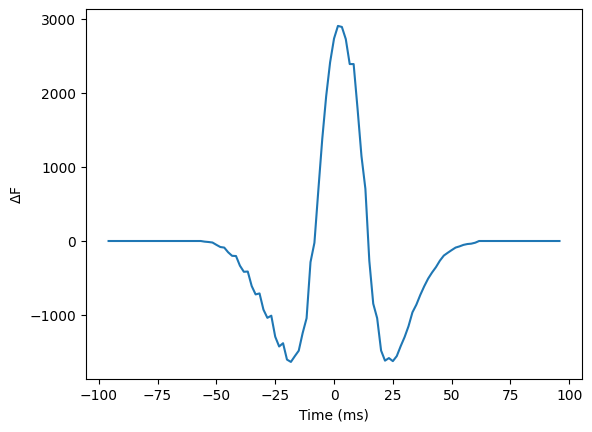

In [17]:
# Plot difference in free energy over time (pial minus white) - this should be negative at the beginning and end 
# of the burst, and positive at the center
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## Sliding time window model comparison across layers
That was sliding time window model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's run it across all layers. We'll turn off SPM visualization here.

In [18]:
# Run sliding window model comparison across all layers
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    fid_coords, 
    burst_sim_fname, 
    surf_set,
    viz=False,
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': sliding_n_temp_modes,
        'win_size': win_size, 
        'win_overlap': win_overlap    
    }
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Oct-2025 07:05:35 - Running job #1
------------------------------------------------------------------------
28-Oct-2025 07:05:35 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:06:28 - 28/10/2025
Completed                               :          07:06:28 - 28/10/2025
28-Oct-2025 07:06:30 - Done    'Head model specification'
28-Oct-2025 07:06:30 - Done

  ReML Iteration              : 2                            ...8.517298e+01
  ReML Iteration              : 3                            ...7.197606e+01
  ReML Iteration              : 4                            ...6.264124e+01
  ReML Iteration              : 5                            ...5.486595e+01
  ReML Iteration              : 6                            ...4.757994e+01
  ReML Iteration              : 7                            ...4.027312e+01
  ReML Iteration              : 8                            ...3.282703e+01
  ReML Iteration              : 9                            ...2.545798e+01
  ReML Iteration              : 10                            ...1.861274e+01
  ReML Iteration              : 11                            ...1.277111e+01
  ReML Iteration              : 12                            ...8.233231e+00
  ReML Iteration              : 13                            ...5.019293e+00
  ReML Iteration              : 14                            ...2.92387

  ReML Iteration              : 18                            ...1.511769e-01
  ReML Iteration              : 19                            ...7.416556e-02
  ReML Iteration              : 20                            ...3.624962e-02
  ReML Iteration              : 21                            ...1.772260e-02
  ReML Iteration              : 22                            ...8.692473e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.220716e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192827e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167692e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106737e+02 [+4.50]
  ReML Iteration 5                      :        ...9.653929e+01 [+4.62]
  ReML Iteration 6                      :        ...7.776386e-03 [+4.75]
Percent variance explained -3.31 (-3.23)
  ReML Iteration              : 2                            ...8.512381e+01
  ReML Iteration              : 3 

  ReML Iteration              : 20                            ...7.645308e-02
  ReML Iteration              : 21                            ...4.632011e-02
  ReML Iteration              : 22                            ...3.065146e-02
  ReML Iteration              : 23                            ...2.299169e-02
  ReML Iteration              : 24                            ...2.059750e-02
  ReML Iteration              : 25                            ...2.393713e-02
  ReML Iteration              : 26                            ...4.182844e-02
  ReML Iteration              : 27                            ...1.374972e-01
  ReML Iteration              : 28                            ...3.749041e-01
  ReML Iteration              : 29                            ...1.858493e-05
Inverting subject 1
  ReML Iteration              : 18                            ...1.686102e-01
  ReML Iteration              : 19                            ...8.417455e-02
  ReML Iteration              : 20          

  ReML Iteration 1                      :        ...1.219184e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194311e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171636e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116814e+02 [+4.50]
  ReML Iteration 5                      :        ...2.181278e-05 [+4.62]
Percent variance explained -42.15 (-42.15)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.454665e+03 [+4.12]
  ReML Iteration 2                      :        ...4.852550e+02 [+4.25]
  ReML Iteration 3                      :        ...3.839923e+00 [

  ReML Iteration 1                      :        ...1.220245e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193270e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168867e+02 [+4.38]
  ReML Iteration 4                      :        ...1.109733e+02 [+4.50]
  ReML Iteration 5                      :        ...3.995985e-03 [+4.62]
Percent variance explained -227.54 (-203.53)
  ReML Iteration 1                      :        ...1.223666e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190284e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160951e+02 [+4.38]
  ReML Iteration 4                      :        ...1.089658e+02 [+4.50]
  ReML Iteration 5                      :        ...9.267492e+01 [+4.62]
  ReML Iteration 6                      :        ...5.364397e-02 [+4.75]
  ReML Iteration 7                      :        ...2.266656e-08 [+4.88]
Percent variance explained -42.37 (-35.41)
  ReML Iteration 1                  

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.687686e+03 [+4.12]
  ReML Iteration 2                      :        ...1.354357e+02 [+4.25]
  ReML Iteration 3                      :        ...8.288260e+00 [+4.38]
  ReML Iteration 4                      :        ...2.172601e-01 [+4.50]
  ReML Iteration 5                      :        ...1.298508e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6229.19
    9.44   -0.06

  ReML Iteration              : 1                            ...1.094151e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent averag

  ReML Iteration              : 2                            ...1.290229e+02
  ReML Iteration              : 3                            ...1.399170e+01
  ReML Iteration              : 4                            ...2.311214e+00
  ReML Iteration              : 5                            ...4.674764e-01
  ReML Iteration              : 6                            ...1.090243e-01
  ReML Iteration              : 7                            ...2.849471e-02
  ReML Iteration              : 8                            ...8.167554e-03
Inverting subject 1
  ReML Iteration              : 2                            ...9.256176e+02
  ReML Iteration              : 3                            ...1.138533e+02
  ReML Iteration              : 4                            ...1.731804e+01
  ReML Iteration              : 5                            ...3.292101e+00
  ReML Iteration              : 6                            ...7.440596e-01
  ReML Iteration              : 7                       

  ReML Iteration 1                      :        ...1.289113e+03 [+4.12]
  ReML Iteration 2                      :        ...8.525914e+01 [+4.25]
  ReML Iteration 3                      :        ...3.001037e+01 [+4.38]
  ReML Iteration 4                      :        ...3.681078e+00 [+4.50]
  ReML Iteration 5                      :        ...3.512714e-02 [+4.62]
  ReML Iteration 6                      :        ...1.759191e-06 [+4.75]
Percent variance explained 91.87 (82.79)
  ReML Iteration              : 2                            ...2.614647e+03
  ReML Iteration              : 3                            ...4.679355e+02
  ReML Iteration              : 4                            ...8.406577e+01
  ReML Iteration              : 5                            ...1.708112e+01
  ReML Iteration              : 6                            ...3.970073e+00
  ReML Iteration              : 7                            ...1.035283e+00
  ReML Iteration              : 8                          

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.076132e+03 [+4.12]
  ReML Iteration 2                      :        ...1.159196e+03 [+4.25]
  ReML Iteration 3                      :        ...1.939400e+01 [+4.38]
  ReML Iteration 4                      :        ...4.981044e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17667.85
    9.43    1.21

  ReML Iteration              : 1                            ...5.473263e+03
  ReML Iteration 1                      :        ...3.611906e+03 [+4.12]
  ReML Iteration 2                      :        ...1.965733e+02 [+4.25]
  ReML Iteration 3                   

  ReML Iteration              : 2                            ...5.732491e+02
  ReML Iteration              : 3                            ...6.253641e+01
  ReML Iteration              : 4                            ...9.130580e+00
  ReML Iteration              : 5                            ...1.710636e+00
  ReML Iteration              : 6                            ...3.843768e-01
  ReML Iteration              : 7                            ...9.871595e-02
  ReML Iteration              : 8                            ...2.806073e-02
  ReML Iteration              : 9                            ...8.637647e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.407006e+03
  ReML Iteration              : 3                            ...4.154027e+02
  ReML Iteration              : 4                            ...7.324194e+01
  ReML Iteration              : 5                            ...1.476203e+01
  ReML Iteration              : 6                       

  ReML Iteration              : 2                            ...3.275907e+03
  ReML Iteration              : 3                            ...6.515381e+02
  ReML Iteration              : 4                            ...1.240387e+02
  ReML Iteration              : 5                            ...2.586676e+01
  ReML Iteration              : 6                            ...6.081361e+00
  ReML Iteration              : 7                            ...1.594268e+00
  ReML Iteration              : 8                            ...4.577305e-01
  ReML Iteration              : 9                            ...1.416228e-01
  ReML Iteration              : 10                            ...4.661469e-02
  ReML Iteration              : 11                            ...1.615878e-02
  ReML Iteration              : 12                            ...5.853045e-03
Inverting subject 1
  ReML Iteration 1                      :        ...6.156217e+03 [+4.12]
  ReML Iteration 2                      :        ...5.454

  ReML Iteration              : 2                            ...1.104751e+03
  ReML Iteration              : 3                            ...1.431965e+02
  ReML Iteration              : 4                            ...2.221795e+01
  ReML Iteration              : 5                            ...4.254693e+00
  ReML Iteration              : 6                            ...9.644979e-01
  ReML Iteration              : 7                            ...2.486813e-01
  ReML Iteration              : 8                            ...7.082441e-02
  ReML Iteration              : 9                            ...2.182263e-02
  ReML Iteration              : 10                            ...7.166912e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.636990e+03
  ReML Iteration              : 3                            ...2.422726e+02
  ReML Iteration              : 4                            ...3.971613e+01
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...1.415853e+04 [+4.12]
  ReML Iteration 2                      :        ...3.768337e+03 [+4.25]
  ReML Iteration 3                      :        ...1.742930e+02 [+4.38]
  ReML Iteration 4                      :        ...2.635067e-01 [+4.50]
  ReML Iteration 5                      :        ...5.460980e-07 [+4.62]
Percent variance explained 98.00 (89.71)
  ReML Iteration              : 2                            ...2.895185e+03
  ReML Iteration              : 3                            ...5.428048e+02
  ReML Iteration              : 4                            ...9.997388e+01
  ReML Iteration              : 5                            ...2.053755e+01
  ReML Iteration              : 6                            ...4.796395e+00
  ReML Iteration              : 7                            ...1.253532e+00
  ReML Iteration              : 8                            ...3.593586e-01
  ReML Iteration              : 9                      

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.21 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.709233e+04 [+4.12]
  ReML Iteration 2                      :        ...6.694556e+03 [+4.25]
  ReML Iteration 3                      :        ...9.255497e+02 [+4.38]
  ReML Iteration 4                      :        ...1.835155e+01 [+4.50]
  ReML Iteration 5                      :        ...7.757601e-03 [+4.62]
log evidence & hyperparameters:
    0.00 37154.14
    9.09    2.23

  ReML Iteration              : 1                            ...1.398047e+04
  ReML Iteration 1                      :        ...1.028105e+04 [+4.12]
  ReML Iteration 2                   

  ReML Iteration 1                      :        ...1.338750e+04 [+4.12]
  ReML Iteration 2                      :        ...3.285918e+03 [+4.25]
  ReML Iteration 3                      :        ...1.285936e+02 [+4.38]
  ReML Iteration 4                      :        ...1.415951e-01 [+4.50]
  ReML Iteration 5                      :        ...1.556955e-07 [+4.62]
Percent variance explained 95.77 (87.92)
  ReML Iteration 1                      :        ...1.783641e+04 [+4.12]
  ReML Iteration 2                      :        ...6.689920e+03 [+4.25]
  ReML Iteration 3                      :        ...6.419346e+02 [+4.38]
  ReML Iteration 4                      :        ...3.950349e+00 [+4.50]
  ReML Iteration 5                      :        ...1.268941e-04 [+4.62]
Percent variance explained 98.01 (91.84)
  ReML Iteration 1                      :        ...9.065069e+03 [+4.12]
  ReML Iteration 2                      :        ...1.297880e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...4.004904e+03
  ReML Iteration              : 3                            ...8.825932e+02
  ReML Iteration              : 4                            ...1.787155e+02
  ReML Iteration              : 5                            ...3.837826e+01
  ReML Iteration              : 6                            ...9.143761e+00
  ReML Iteration              : 7                            ...2.412083e+00
  ReML Iteration              : 8                            ...6.946592e-01
  ReML Iteration              : 9                            ...2.152690e-01
  ReML Iteration              : 10                            ...7.091527e-02
  ReML Iteration              : 11                            ...2.459408e-02
  ReML Iteration              : 12                            ...8.910896e-03
Inverting subject 1
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.85 percent average variance
Using 1 

  ReML Iteration              : 2                            ...2.531708e+03
  ReML Iteration              : 3                            ...4.466575e+02
  ReML Iteration              : 4                            ...7.964729e+01
  ReML Iteration              : 5                            ...1.613112e+01
  ReML Iteration              : 6                            ...3.744011e+00
  ReML Iteration              : 7                            ...9.757040e-01
  ReML Iteration              : 8                            ...2.793225e-01
  ReML Iteration              : 9                            ...8.629416e-02
  ReML Iteration              : 10                            ...2.838072e-02
  ReML Iteration              : 11                            ...9.833676e-03
Inverting subject 1
  ReML Iteration              : 2                            ...3.840741e+03
  ReML Iteration              : 3                            ...8.279409e+02
  ReML Iteration              : 4                     

  ReML Iteration 1                      :        ...1.549453e+04 [+4.12]
  ReML Iteration 2                      :        ...4.706848e+03 [+4.25]
  ReML Iteration 3                      :        ...2.872258e+02 [+4.38]
  ReML Iteration 4                      :        ...7.383393e-01 [+4.50]
  ReML Iteration 5                      :        ...4.344612e-06 [+4.62]
Percent variance explained 98.07 (90.43)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.20 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.903322e+04 [+4.12]
  ReML Iteration 2                      :        ...8.668051e+03 [+4.25]
  ReML Iteration 3                      :        ...1.660845e+03 [+4

  ReML Iteration              : 2                            ...1.169150e+03
  ReML Iteration              : 3                            ...1.542514e+02
  ReML Iteration              : 4                            ...2.410006e+01
  ReML Iteration              : 5                            ...4.627173e+00
  ReML Iteration              : 6                            ...1.050056e+00
  ReML Iteration              : 7                            ...2.708706e-01
  ReML Iteration              : 8                            ...7.716175e-02
  ReML Iteration              : 9                            ...2.377812e-02
  ReML Iteration              : 10                            ...7.809623e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.370355e+03
  ReML Iteration              : 3                            ...1.904663e+02
  ReML Iteration              : 4                            ...3.039420e+01
  ReML Iteration              : 5                      

  ReML Iteration              : 2                            ...5.332864e+03
  ReML Iteration              : 3                            ...1.381072e+03
  ReML Iteration              : 4                            ...3.116634e+02
  ReML Iteration              : 5                            ...7.078160e+01
  ReML Iteration              : 6                            ...1.731768e+01
  ReML Iteration              : 7                            ...4.626685e+00
  ReML Iteration              : 8                            ...1.340873e+00
  ReML Iteration              : 9                            ...4.168849e-01
  ReML Iteration              : 10                            ...1.375747e-01
  ReML Iteration              : 11                            ...4.775898e-02
  ReML Iteration              : 12                            ...1.731370e-02
  ReML Iteration              : 13                            ...6.515954e-03
Inverting subject 1
  ReML Iteration 1                      :        ...

  ReML Iteration 1                      :        ...1.758600e+04 [+4.12]
  ReML Iteration 2                      :        ...6.456185e+03 [+4.25]
  ReML Iteration 3                      :        ...5.912890e+02 [+4.38]
  ReML Iteration 4                      :        ...3.324273e+00 [+4.50]
  ReML Iteration 5                      :        ...8.964735e-05 [+4.62]
Percent variance explained 97.74 (94.02)
  ReML Iteration 1                      :        ...1.745046e+04 [+4.12]
  ReML Iteration 2                      :        ...6.331900e+03 [+4.25]
  ReML Iteration 3                      :        ...5.653631e+02 [+4.38]
  ReML Iteration 4                      :        ...3.025980e+00 [+4.50]
  ReML Iteration 5                      :        ...7.418851e-05 [+4.62]
Percent variance explained 98.09 (91.48)
  ReML Iteration 1                      :        ...1.223536e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190389e+02 [+4.25]
  ReML Iteration 3                      : 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Oct-2025 07:09:32 - Running job #1
------------------------------------------------------------------------
28-Oct-2025 07:09:32 - Running 'Source inversion, iterative'
Using 1 iterations of 1 patches
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_50492_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldspatchiter 1/1
Checking leadfields
ans =

    0.2639    0.5724
    0.6365    0.8400

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/fs/sub-104/surf/laminar/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of sa

  ReML Iteration              : 2                            ...8.517117e+01
  ReML Iteration              : 3                            ...7.197293e+01
  ReML Iteration              : 4                            ...6.263622e+01
  ReML Iteration              : 5                            ...5.485840e+01
  ReML Iteration              : 6                            ...4.756930e+01
  ReML Iteration              : 7                            ...4.025915e+01
  ReML Iteration              : 8                            ...3.281011e+01
  ReML Iteration              : 9                            ...2.543928e+01
  ReML Iteration              : 10                            ...1.859400e+01
  ReML Iteration              : 11                            ...1.275410e+01
  ReML Iteration              : 12                            ...8.219150e+00
  ReML Iteration              : 13                            ...5.008496e+00
  ReML Iteration              : 14                            ...2.91604

  ReML Iteration              : 23                            ...1.844257e-01
  ReML Iteration              : 24                            ...4.182520e-01
  ReML Iteration              : 25                            ...6.149722e-05
Inverting subject 1
  ReML Iteration 1                      :        ...1.219198e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194297e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171599e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116719e+02 [+4.50]
  ReML Iteration 5                      :        ...2.972663e-05 [+4.62]
Percent variance explained -40.95 (-40.95)
Inverting subject 1
  ReML Iteration              : 2                            ...8.507790e+01
  ReML Iteration              : 3                            ...7.181181e+01
  ReML Iteration              : 4                            ...6.237827e+01
  ReML Iteration              : 5                            ...5.447134e+01
  ReML Ite

  ReML Iteration              : 23                            ...2.023349e-02
  ReML Iteration              : 24                            ...1.661742e-02
  ReML Iteration              : 25                            ...1.655157e-02
  ReML Iteration              : 26                            ...2.177524e-02
  ReML Iteration              : 27                            ...4.419659e-02
  ReML Iteration              : 28                            ...1.672299e-01
  ReML Iteration              : 29                            ...3.618158e-01
  ReML Iteration              : 30                            ...1.433885e-05
Inverting subject 1
  ReML Iteration 1                      :        ...1.219500e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193994e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170793e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114654e+02 [+4.50]
  ReML Iteration 5                      :        ...5.054189e-04

  ReML Iteration              : 18                            ...2.396578e-01
  ReML Iteration              : 19                            ...1.310413e-01
  ReML Iteration              : 20                            ...7.405762e-02
  ReML Iteration              : 21                            ...4.411857e-02
  ReML Iteration              : 22                            ...2.835934e-02
  ReML Iteration              : 23                            ...2.023349e-02
  ReML Iteration              : 24                            ...1.661742e-02
  ReML Iteration              : 25                            ...1.655157e-02
  ReML Iteration              : 26                            ...2.177524e-02
  ReML Iteration              : 27                            ...4.419659e-02
  ReML Iteration              : 28                            ...1.672299e-01
  ReML Iteration              : 29                            ...3.618158e-01
  ReML Iteration              : 30                            ..

  ReML Iteration 1                      :        ...1.219500e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193994e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170793e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114654e+02 [+4.50]
  ReML Iteration 5                      :        ...5.054189e-04 [+4.62]
Percent variance explained -24.47 (-23.86)
  ReML Iteration 1                      :        ...1.226586e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188056e+02 [+4.25]
  ReML Iteration 3                      :        ...1.155069e+02 [+4.38]
  ReML Iteration 4                      :        ...1.074900e+02 [+4.50]
  ReML Iteration 5                      :        ...8.941831e+01 [+4.62]
  ReML Iteration 6                      :        ...1.279135e-01 [+4.75]
  ReML Iteration 7                      :        ...1.277029e-07 [+4.88]
Percent variance explained -76.93 (-68.90)
  ReML Iteration 1                    

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.695129e+03 [+4.12]
  ReML Iteration 2                      :        ...1.359135e+02 [+4.25]
  ReML Iteration 3                      :        ...8.234833e+00 [+4.38]
  ReML Iteration 4                      :        ...2.141440e-01 [+4.50]
  ReML Iteration 5                      :        ...1.262175e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6247.48
    9.44   -0.02

  ReML Iteration              : 1                            ...1.099176e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent averag

  ReML Iteration              : 2                            ...6.206704e+01
  ReML Iteration              : 3                            ...1.368939e+01
  ReML Iteration              : 4                            ...3.654495e+00
  ReML Iteration              : 5                            ...9.497862e-01
  ReML Iteration              : 6                            ...2.504955e-01
  ReML Iteration              : 7                            ...6.951984e-02
  ReML Iteration              : 8                            ...2.053255e-02
  ReML Iteration              : 9                            ...6.443659e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.299083e+02
  ReML Iteration              : 3                            ...1.404856e+01
  ReML Iteration              : 4                            ...2.314487e+00
  ReML Iteration              : 5                            ...4.674781e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.294799e+03 [+4.12]
  ReML Iteration 2                      :        ...8.530917e+01 [+4.25]
  ReML Iteration 3                      :        ...2.990789e+01 [+4.38]
  ReML Iteration 4                      :        ...3.651493e+00 [+4.50]
  ReML Iteration 5                      :        ...3.452295e-02 [+4.62]
  ReML Iteration 6                      :        ...1.690298e-06 [+4.75]
Percent variance explained 92.09 (83.00)
  ReML Iteration              : 2                            ...2.197748e+02
  ReML Iteration              : 3                            ...2.145666e+01
  ReML Iteration              : 4                            ...3.127740e+00
  ReML Iteration              : 5                            ...5.904091e-01
  ReML Iteration              : 6                            ...1.332526e-01
  ReML Iteration              : 7                            ...3.429433e-02
  ReML Iteration              : 8                          

  ReML Iteration 1                      :        ...2.645424e+03 [+4.12]
  ReML Iteration 2                      :        ...1.280937e+02 [+4.25]
  ReML Iteration 3                      :        ...1.547461e+01 [+4.38]
  ReML Iteration 4                      :        ...7.925928e-01 [+4.50]
  ReML Iteration 5                      :        ...1.333760e-03 [+4.62]
Percent variance explained 94.64 (80.99)
  ReML Iteration              : 2                            ...2.152302e+02
  ReML Iteration              : 3                            ...2.102938e+01
  ReML Iteration              : 4                            ...3.072595e+00
  ReML Iteration              : 5                            ...5.807908e-01
  ReML Iteration              : 6                            ...1.311671e-01
  ReML Iteration              : 7                            ...3.376787e-02
  ReML Iteration              : 8                            ...9.609048e-03
Inverting subject 1
  ReML Iteration 1                 

  ReML Iteration 1                      :        ...1.265977e+04 [+4.12]
  ReML Iteration 2                      :        ...2.868436e+03 [+4.25]
  ReML Iteration 3                      :        ...9.540012e+01 [+4.38]
  ReML Iteration 4                      :        ...7.773789e-02 [+4.50]
  ReML Iteration 5                      :        ...4.556041e-08 [+4.62]
Percent variance explained 97.94 (92.39)
  ReML Iteration 1                      :        ...1.673320e+04 [+4.12]
  ReML Iteration 2                      :        ...5.699887e+03 [+4.25]
  ReML Iteration 3                      :        ...4.440336e+02 [+4.38]
  ReML Iteration 4                      :        ...1.826007e+00 [+4.50]
  ReML Iteration 5                      :        ...2.684728e-05 [+4.62]
Percent variance explained 97.46 (91.19)
  ReML Iteration 1                      :        ...1.362666e+04 [+4.12]
  ReML Iteration 2                      :        ...3.431066e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...2.351278e+03
  ReML Iteration              : 3                            ...4.017226e+02
  ReML Iteration              : 4                            ...7.047065e+01
  ReML Iteration              : 5                            ...1.417273e+01
  ReML Iteration              : 6                            ...3.279516e+00
  ReML Iteration              : 7                            ...8.534694e-01
  ReML Iteration              : 8                            ...2.441644e-01
  ReML Iteration              : 9                            ...7.540625e-02
  ReML Iteration              : 10                            ...2.479526e-02
  ReML Iteration              : 11                            ...8.590458e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.603502e+03
  ReML Iteration              : 3                            ...2.355314e+02
  ReML Iteration              : 4                     

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.02 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.037952e+04 [+4.12]
  ReML Iteration 2                      :        ...2.064347e+03 [+4.25]
  ReML Iteration 3                      :        ...6.767286e+01 [+4.38]
  ReML Iteration 4                      :        ...6.691123e-02 [+4.50]
  ReML Iteration 5                      :        ...6.388225e-08 [+4.62]
log evidence & hyperparameters:
    0.00 22297.15
    9.38    1.55

  ReML Iteration              : 1                            ...7.566244e+03
  ReML Iteration              : 2                            ...5.668977e+02
  ReML Iteration              : 3

  ReML Iteration 1                      :        ...1.217087e+04 [+4.12]
  ReML Iteration 2                      :        ...2.607891e+03 [+4.25]
  ReML Iteration 3                      :        ...7.754897e+01 [+4.38]
  ReML Iteration 4                      :        ...5.193606e-02 [+4.50]
  ReML Iteration 5                      :        ...1.922089e-08 [+4.62]
Percent variance explained 94.14 (89.37)
  ReML Iteration 1                      :        ...6.121398e+03 [+4.12]
  ReML Iteration 2                      :        ...5.388747e+02 [+4.25]
  ReML Iteration 3                      :        ...7.230705e+00 [+4.38]
  ReML Iteration 4                      :        ...6.238973e-02 [+4.50]
  ReML Iteration 5                      :        ...5.082888e-06 [+4.62]
Percent variance explained 90.20 (81.36)
  ReML Iteration 1                      :        ...1.217087e+04 [+4.12]
  ReML Iteration 2                      :        ...2.607891e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...5.951053e+01
  ReML Iteration              : 3                            ...1.434604e+01
  ReML Iteration              : 4                            ...4.020229e+00
  ReML Iteration              : 5                            ...1.074358e+00
  ReML Iteration              : 6                            ...2.876735e-01
  ReML Iteration              : 7                            ...8.046928e-02
  ReML Iteration              : 8                            ...2.386379e-02
  ReML Iteration              : 9                            ...7.505294e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.088519e+03
  ReML Iteration              : 3                            ...1.404518e+02
  ReML Iteration              : 4                            ...2.175363e+01
  ReML Iteration              : 5                            ...4.163028e+00
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...8.460528e+03 [+4.12]
  ReML Iteration 2                      :        ...1.106695e+03 [+4.25]
  ReML Iteration 3                      :        ...1.428263e+01 [+4.38]
  ReML Iteration 4                      :        ...1.812664e-02 [+4.50]
  ReML Iteration 5                      :        ...1.832923e-07 [+4.62]
Percent variance explained 92.43 (80.43)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.25 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.139040e+04 [+4.12]
  ReML Iteration 2                      :        ...2.563207e+03 [+4.25]
  ReML Iteration 3                      :        ...1.088159e+02 [+4

  ReML Iteration 1                      :        ...1.193459e+03 [+4.12]
  ReML Iteration 2                      :        ...8.459140e+01 [+4.25]
  ReML Iteration 3                      :        ...3.182859e+01 [+4.38]
  ReML Iteration 4                      :        ...4.230265e+00 [+4.50]
  ReML Iteration 5                      :        ...4.739080e-02 [+4.62]
  ReML Iteration 6                      :        ...3.476231e-06 [+4.75]
Percent variance explained 92.12 (83.05)
  ReML Iteration              : 2                            ...1.383722e+03
  ReML Iteration              : 3                            ...1.929610e+02
  ReML Iteration              : 4                            ...3.083474e+01
  ReML Iteration              : 5                            ...5.971309e+00
  ReML Iteration              : 6                            ...1.359884e+00
  ReML Iteration              : 7                            ...3.513508e-01
  ReML Iteration              : 8                          

  ReML Iteration              : 2                            ...1.191711e+03
  ReML Iteration              : 3                            ...1.581865e+02
  ReML Iteration              : 4                            ...2.477455e+01
  ReML Iteration              : 5                            ...4.761008e+00
  ReML Iteration              : 6                            ...1.080831e+00
  ReML Iteration              : 7                            ...2.788559e-01
  ReML Iteration              : 8                            ...7.944290e-02
  ReML Iteration              : 9                            ...2.448209e-02
  ReML Iteration              : 10                            ...8.041011e-03
Inverting subject 1
  ReML Iteration              : 2                            ...3.906010e+03
  ReML Iteration              : 3                            ...8.494872e+02
  ReML Iteration              : 4                            ...1.705975e+02
  ReML Iteration              : 5                      

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.164352e+03 [+4.12]
  ReML Iteration 2                      :        ...1.710360e+02 [+4.25]
  ReML Iteration 3                      :        ...5.630458e+00 [+4.38]
  ReML Iteration 4                      :        ...8.982725e-02 [+4.50]
  ReML Iteration 5                      :        ...2.322786e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7371.76
    9.44    0.17

  ReML Iteration              : 1                            ...1.425988e+03
  ReML Iteration 1                      :        ...9.493933e+03 [+4.12]
  ReML Iteration 2                    

  ReML Iteration 1                      :        ...8.838587e+03 [+4.12]
  ReML Iteration 2                      :        ...1.223985e+03 [+4.25]
  ReML Iteration 3                      :        ...1.692220e+01 [+4.38]
  ReML Iteration 4                      :        ...1.574272e-02 [+4.50]
  ReML Iteration 5                      :        ...1.023930e-07 [+4.62]
Percent variance explained 93.78 (87.07)
  ReML Iteration 1                      :        ...1.758340e+04 [+4.12]
  ReML Iteration 2                      :        ...6.453787e+03 [+4.25]
  ReML Iteration 3                      :        ...5.907822e+02 [+4.38]
  ReML Iteration 4                      :        ...3.318298e+00 [+4.50]
  ReML Iteration 5                      :        ...8.932325e-05 [+4.62]
Percent variance explained 97.71 (91.70)
  ReML Iteration 1                      :        ...1.753855e+04 [+4.12]
  ReML Iteration 2                      :        ...6.412496e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...7.458777e+01
  ReML Iteration              : 3                            ...1.236173e+01
  ReML Iteration              : 4                            ...2.798262e+00
  ReML Iteration              : 5                            ...6.658166e-01
  ReML Iteration              : 6                            ...1.678236e-01
  ReML Iteration              : 7                            ...4.552625e-02
  ReML Iteration              : 8                            ...1.329094e-02
  ReML Iteration              : 9                            ...4.145837e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.224946e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189278e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158292e+02 [+4.38]
  ReML Iteration 4                      :        ...1.082968e+02 [+4.50]
  ReML Iteration 5                      :        ...9.118925e+01 [+4.62]

  ReML Iteration 1                      :        ...1.663432e+03 [+4.12]
  ReML Iteration 2                      :        ...9.094113e+01 [+4.25]
  ReML Iteration 3                      :        ...2.432493e+01 [+4.38]
  ReML Iteration 4                      :        ...2.250289e+00 [+4.50]
  ReML Iteration 5                      :        ...1.224924e-02 [+4.62]
  ReML Iteration 6                      :        ...1.337401e-07 [+4.75]
Percent variance explained 93.47 (79.11)
  ReML Iteration 1                      :        ...1.223545e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190382e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161211e+02 [+4.38]
  ReML Iteration 4                      :        ...1.090312e+02 [+4.50]
  ReML Iteration 5                      :        ...9.282095e+01 [+4.62]
  ReML Iteration 6                      :        ...5.110930e-02 [+4.75]
  ReML Iteration 7                      :        ...2.058778e-08 [+4.88]
Percent va

 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 5
Fixed number of temporal modes
Using 4 temporal modes, accounting for 100.00 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.825124e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188446e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131694e+02 [+4.38]
  ReML Iteration 4                      :        ...1.041240e+02 [+4.50]
  ReML Iteration 5                      :        ...8.400923e+01 [+4.62]
  ReML Iteration 6                      :        ...4.477077e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.47   -3.46

  ReML I

  ReML Iteration              : 2                            ...8.516948e+01
  ReML Iteration              : 3                            ...7.197000e+01
  ReML Iteration              : 4                            ...6.263153e+01
  ReML Iteration              : 5                            ...5.485135e+01
  ReML Iteration              : 6                            ...4.755936e+01
  ReML Iteration              : 7                            ...4.024610e+01
  ReML Iteration              : 8                            ...3.279431e+01
  ReML Iteration              : 9                            ...2.542182e+01
  ReML Iteration              : 10                            ...1.857651e+01
  ReML Iteration              : 11                            ...1.273824e+01
  ReML Iteration              : 12                            ...8.206020e+00
  ReML Iteration              : 13                            ...4.998433e+00
  ReML Iteration              : 14                            ...2.90875

  ReML Iteration              : 18                            ...2.782095e-01
  ReML Iteration              : 19                            ...1.623434e-01
  ReML Iteration              : 20                            ...1.033868e-01
  ReML Iteration              : 21                            ...7.777967e-02
  ReML Iteration              : 22                            ...8.074805e-02
  ReML Iteration              : 23                            ...1.570919e-01
  ReML Iteration              : 24                            ...4.167653e-01
  ReML Iteration              : 25                            ...6.774487e-05
Inverting subject 1
  ReML Iteration              : 22                            ...2.662142e-02
  ReML Iteration              : 23                            ...1.829038e-02
  ReML Iteration              : 24                            ...1.410945e-02
  ReML Iteration              : 25                            ...1.265250e-02
  ReML Iteration              : 26          

  ReML Iteration 1                      :        ...1.219211e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194284e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171565e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116630e+02 [+4.50]
  ReML Iteration 5                      :        ...3.822664e-05 [+4.62]
Percent variance explained -40.11 (-40.11)
  ReML Iteration 1                      :        ...1.219529e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193965e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170716e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114456e+02 [+4.50]
  ReML Iteration 5                      :        ...5.814205e-04 [+4.62]
Percent variance explained -23.92 (-23.33)
  ReML Iteration 1                      :        ...1.219529e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193965e+02 [+4.25]
  ReML Iteration 3                    

  ReML Iteration 1                      :        ...1.218984e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194515e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172179e+02 [+4.38]
  ReML Iteration 4                      :        ...1.118206e+02 [+4.50]
  ReML Iteration 5                      :        ...4.612040e-05 [+4.62]
Percent variance explained -9.63 (-8.05)
  ReML Iteration              : 18                            ...6.150964e-02
  ReML Iteration              : 19                            ...2.818020e-02
  ReML Iteration              : 20                            ...1.294261e-02
  ReML Iteration              : 21                            ...5.978253e-03
Inverting subject 1
  ReML Iteration              : 18                            ...2.964120e-02
  ReML Iteration              : 19                            ...1.331408e-02
  ReML Iteration              : 20                            ...6.026221e-03
Inverting subject 1
  ReML I

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.700557e+03 [+4.12]
  ReML Iteration 2                      :        ...1.362635e+02 [+4.25]
  ReML Iteration 3                      :        ...8.196150e+00 [+4.38]
  ReML Iteration 4                      :        ...2.119026e-01 [+4.50]
  ReML Iteration 5                      :        ...1.236360e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6260.80
    9.44    0.01

  ReML Iteration              : 1                            ...1.102845e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.83 percent averag

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.339830e+03 [+4.12]
  ReML Iteration 2                      :        ...3.022257e+02 [+4.25]
  ReML Iteration 3                      :        ...3.125021e+00 [+4.38]
  ReML Iteration 4                      :        ...1.330612e-02 [+4.50]
  ReML Iteration 5                      :        ...6.158295e-07 [+4.62]
log evidence & hyperparameters:
    0.00 10008.58
    9.42    0.53

  ReML Iteration              : 1                            ...2.311441e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.12 percent avera

  ReML Iteration              : 2                            ...6.218030e+01
  ReML Iteration              : 3                            ...1.366562e+01
  ReML Iteration              : 4                            ...3.641019e+00
  ReML Iteration              : 5                            ...9.452430e-01
  ReML Iteration              : 6                            ...2.491505e-01
  ReML Iteration              : 7                            ...6.912556e-02
  ReML Iteration              : 8                            ...2.041290e-02
  ReML Iteration              : 9                            ...6.405581e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.305586e+02
  ReML Iteration              : 3                            ...1.409064e+01
  ReML Iteration              : 4                            ...2.316993e+00
  ReML Iteration              : 5                            ...4.675066e-01
  ReML Iteration              : 6                       

  ReML Iteration              : 2                            ...2.211218e+02
  ReML Iteration              : 3                            ...2.158406e+01
  ReML Iteration              : 4                            ...3.144269e+00
  ReML Iteration              : 5                            ...5.933023e-01
  ReML Iteration              : 6                            ...1.338811e-01
  ReML Iteration              : 7                            ...3.445315e-02
  ReML Iteration              : 8                            ...9.802251e-03
Inverting subject 1
  ReML Iteration              : 2                            ...9.427613e+02
  ReML Iteration              : 3                            ...1.165704e+02
  ReML Iteration              : 4                            ...1.776566e+01
  ReML Iteration              : 5                            ...3.379584e+00
  ReML Iteration              : 6                            ...7.640516e-01
  ReML Iteration              : 7                       

  ReML Iteration 1                      :        ...1.298950e+03 [+4.12]
  ReML Iteration 2                      :        ...8.534641e+01 [+4.25]
  ReML Iteration 3                      :        ...2.983346e+01 [+4.38]
  ReML Iteration 4                      :        ...3.630097e+00 [+4.50]
  ReML Iteration 5                      :        ...3.408955e-02 [+4.62]
  ReML Iteration 6                      :        ...1.641773e-06 [+4.75]
Percent variance explained 92.26 (83.15)
  ReML Iteration 1                      :        ...6.332364e+03 [+4.12]
  ReML Iteration 2                      :        ...5.795680e+02 [+4.25]
  ReML Iteration 3                      :        ...7.375184e+00 [+4.38]
  ReML Iteration 4                      :        ...5.503542e-02 [+4.50]
  ReML Iteration 5                      :        ...3.781068e-06 [+4.62]
Percent variance explained 96.99 (84.88)
  ReML Iteration 1                      :        ...1.120701e+04 [+4.12]
  ReML Iteration 2                      : 

  ReML Iteration 1                      :        ...2.654477e+03 [+4.12]
  ReML Iteration 2                      :        ...1.285858e+02 [+4.25]
  ReML Iteration 3                      :        ...1.541757e+01 [+4.38]
  ReML Iteration 4                      :        ...7.858916e-01 [+4.50]
  ReML Iteration 5                      :        ...1.309924e-03 [+4.62]
Percent variance explained 94.81 (81.13)
  ReML Iteration 1                      :        ...1.681906e+04 [+4.12]
  ReML Iteration 2                      :        ...5.773290e+03 [+4.25]
  ReML Iteration 3                      :        ...4.572399e+02 [+4.38]
  ReML Iteration 4                      :        ...1.941168e+00 [+4.50]
  ReML Iteration 5                      :        ...3.036238e-05 [+4.62]
Percent variance explained 97.71 (91.43)
  ReML Iteration              : 2                            ...1.234471e+03
  ReML Iteration              : 3                            ...1.657322e+02
  ReML Iteration              : 4 

  ReML Iteration 1                      :        ...3.686705e+03 [+4.12]
  ReML Iteration 2                      :        ...2.032490e+02 [+4.25]
  ReML Iteration 3                      :        ...1.059255e+01 [+4.38]
  ReML Iteration 4                      :        ...3.258815e-01 [+4.50]
  ReML Iteration 5                      :        ...2.002306e-04 [+4.62]
Percent variance explained 95.86 (87.51)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.80 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.529827e+04 [+4.12]
  ReML Iteration 2                      :        ...5.137975e+03 [+4.25]
  ReML Iteration 3                      :        ...5.102161e+02 [+4

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.23 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.197754e+04 [+4.12]
  ReML Iteration 2                      :        ...2.883096e+03 [+4.25]
  ReML Iteration 3                      :        ...1.410212e+02 [+4.38]
  ReML Iteration 4                      :        ...3.146867e-01 [+4.50]
  ReML Iteration 5                      :        ...1.541665e-06 [+4.62]
log evidence & hyperparameters:
    0.00 25586.75
    9.35    1.78

  ReML Iteration              : 1                            ...9.057870e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent avera

  ReML Iteration              : 2                            ...1.576258e+03
  ReML Iteration              : 3                            ...2.300963e+02
  ReML Iteration              : 4                            ...3.749313e+01
  ReML Iteration              : 5                            ...7.316178e+00
  ReML Iteration              : 6                            ...1.671429e+00
  ReML Iteration              : 7                            ...4.324585e-01
  ReML Iteration              : 8                            ...1.233718e-01
  ReML Iteration              : 9                            ...3.804647e-02
  ReML Iteration              : 10                            ...1.250087e-02
  ReML Iteration              : 11                            ...4.329137e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.71 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :      

  ReML Iteration              : 2                            ...9.449508e+02
  ReML Iteration              : 3                            ...1.169188e+02
  ReML Iteration              : 4                            ...1.782315e+01
  ReML Iteration              : 5                            ...3.390827e+00
  ReML Iteration              : 6                            ...7.666215e-01
  ReML Iteration              : 7                            ...1.974263e-01
  ReML Iteration              : 8                            ...5.619466e-02
  ReML Iteration              : 9                            ...1.730976e-02
  ReML Iteration              : 10                            ...5.683909e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.306270e+03
  ReML Iteration              : 3                            ...3.908037e+02
  ReML Iteration              : 4                            ...6.827306e+01
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...1.009926e+04 [+4.12]
  ReML Iteration 2                      :        ...1.671105e+03 [+4.25]
  ReML Iteration 3                      :        ...3.048270e+01 [+4.38]
  ReML Iteration 4                      :        ...1.427552e-02 [+4.50]
  ReML Iteration 5                      :        ...1.069438e-08 [+4.62]
Percent variance explained 92.93 (82.92)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.85 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.081156e+04 [+4.12]
  ReML Iteration 2                      :        ...2.269656e+03 [+4.25]
  ReML Iteration 3                      :        ...8.329608e+01 [+4

  ReML Iteration 1                      :        ...7.897887e+03 [+4.12]
  ReML Iteration 2                      :        ...9.458198e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128803e+01 [+4.38]
  ReML Iteration 4                      :        ...2.342358e-02 [+4.50]
  ReML Iteration 5                      :        ...4.190279e-07 [+4.62]
Percent variance explained 93.06 (80.20)
  ReML Iteration 1                      :        ...1.206289e+04 [+4.12]
  ReML Iteration 2                      :        ...2.552455e+03 [+4.25]
  ReML Iteration 3                      :        ...7.402711e+01 [+4.38]
  ReML Iteration 4                      :        ...4.755568e-02 [+4.50]
  ReML Iteration 5                      :        ...1.578110e-08 [+4.62]
Percent variance explained 93.73 (88.98)
  ReML Iteration 1                      :        ...8.409685e+03 [+4.12]
  ReML Iteration 2                      :        ...1.091492e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.800124e+04 [+4.12]
  ReML Iteration 2                      :        ...6.846722e+03 [+4.25]
  ReML Iteration 3                      :        ...6.773104e+02 [+4.38]
  ReML Iteration 4                      :        ...4.422048e+00 [+4.50]
  ReML Iteration 5                      :        ...1.592633e-04 [+4.62]
Percent variance explained 98.46 (92.26)
  ReML Iteration              : 2                            ...1.209209e+03
  ReML Iteration              : 3                            ...1.612604e+02
  ReML Iteration              : 4                            ...2.530308e+01
  ReML Iteration              : 5                            ...4.866006e+00
  ReML Iteration              : 6                            ...1.104987e+00
  ReML Iteration              : 7                            ...2.851251e-01
  ReML Iteration              : 8                            ...8.123402e-02
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...8.900765e+03 [+4.12]
  ReML Iteration 2                      :        ...1.243998e+03 [+4.25]
  ReML Iteration 3                      :        ...1.741066e+01 [+4.38]
  ReML Iteration 4                      :        ...1.543416e-02 [+4.50]
  ReML Iteration 5                      :        ...9.278132e-08 [+4.62]
Percent variance explained 94.11 (87.37)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.22 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.340240e+03 [+4.12]
  ReML Iteration 2                      :        ...4.637562e+02 [+4.25]
  ReML Iteration 3                      :        ...3.644838e+00 [+4

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.20 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.919617e+04 [+4.12]
  ReML Iteration 2                      :        ...8.848000e+03 [+4.25]
  ReML Iteration 3                      :        ...1.740093e+03 [+4.38]
  ReML Iteration 4                      :        ...7.467677e+01 [+4.50]
  ReML Iteration 5                      :        ...1.648374e-01 [+4.62]
  ReML Iteration 6                      :        ...8.537262e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42686.43
    8.95    2.54

  ReML Iteration              : 1                            ...1.605341e+04
  ReML Iteration              : 2    

  ReML Iteration              : 2                            ...2.073649e+02
  ReML Iteration              : 3                            ...2.029975e+01
  ReML Iteration              : 4                            ...2.979551e+00
  ReML Iteration              : 5                            ...5.646979e-01
  ReML Iteration              : 6                            ...1.276940e-01
  ReML Iteration              : 7                            ...3.289316e-02
  ReML Iteration              : 8                            ...9.362755e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.562370e+04 [+4.12]
  ReML Iteration 2                      :        ...4.804749e+03 [+4.25]
  ReML Iteration 3                      :        ...3.009266e+02 [+4.38]
  ReML Iteration 4                      :        ...8.131828e-01 [+4.50]
  ReML Iteration 5                      :        ...5.275813e-06 [+4.62]
Percent variance explained 98.48 (90.81)
  ReML Iteration 1                 

  ReML Iteration              : 2                            ...5.455838e+03
  ReML Iteration              : 3                            ...1.432351e+03
  ReML Iteration              : 4                            ...3.264337e+02
  ReML Iteration              : 5                            ...7.453577e+01
  ReML Iteration              : 6                            ...1.828422e+01
  ReML Iteration              : 7                            ...4.891155e+00
  ReML Iteration              : 8                            ...1.418426e+00
  ReML Iteration              : 9                            ...4.411431e-01
  ReML Iteration              : 10                            ...1.456062e-01
  ReML Iteration              : 11                            ...5.055215e-02
  ReML Iteration              : 12                            ...1.832734e-02
  ReML Iteration              : 13                            ...6.897666e-03
Inverting subject 1
  ReML Iteration 1                      :        ...

28-Oct-2025 07:12:24 - Done    'Source inversion, iterative'
28-Oct-2025 07:12:24 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Oct-2025 07:12:26 - Running job #1
------------------------------------------------------------------------
28-Oct-2025 07:12:26 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:13:04 - 28/10/2025
Completed                               :          07:13:04 - 28/10

  ReML Iteration              : 2                            ...8.516788e+01
  ReML Iteration              : 3                            ...7.196724e+01
  ReML Iteration              : 4                            ...6.262710e+01
  ReML Iteration              : 5                            ...5.484469e+01
  ReML Iteration              : 6                            ...4.754998e+01
  ReML Iteration              : 7                            ...4.023379e+01
  ReML Iteration              : 8                            ...3.277941e+01
  ReML Iteration              : 9                            ...2.540536e+01
  ReML Iteration              : 10                            ...1.856002e+01
  ReML Iteration              : 11                            ...1.272329e+01
  ReML Iteration              : 12                            ...8.193654e+00
  ReML Iteration              : 13                            ...4.988962e+00
  ReML Iteration              : 14                            ...2.90189

  ReML Iteration              : 23                            ...1.355746e-01
  ReML Iteration              : 24                            ...3.991591e-01
  ReML Iteration              : 25                            ...7.520366e-05
Inverting subject 1
  ReML Iteration              : 2                            ...8.512429e+01
  ReML Iteration              : 3                            ...7.189191e+01
  ReML Iteration              : 4                            ...6.250644e+01
  ReML Iteration              : 5                            ...5.466349e+01
  ReML Iteration              : 6                            ...4.729495e+01
  ReML Iteration              : 7                            ...3.989965e+01
  ReML Iteration              : 8                            ...3.237599e+01
  ReML Iteration              : 9                            ...2.496112e+01
  ReML Iteration              : 10                            ...1.811705e+01
  ReML Iteration              : 11                  

  ReML Iteration 1                      :        ...1.219223e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194272e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171532e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116546e+02 [+4.50]
  ReML Iteration 5                      :        ...4.722597e-05 [+4.62]
Percent variance explained -39.30 (-39.30)
  ReML Iteration              : 19                            ...7.097584e-02
  ReML Iteration              : 20                            ...3.449589e-02
  ReML Iteration              : 21                            ...1.676724e-02
  ReML Iteration              : 22                            ...8.175008e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.220422e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193102e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168421e+02 [+4.38]
  ReML Iteration 4                      :

  ReML Iteration 1                      :        ...1.219557e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193937e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170641e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114266e+02 [+4.50]
  ReML Iteration 5                      :        ...6.598608e-04 [+4.62]
Percent variance explained -23.39 (-22.80)
  ReML Iteration              : 20                            ...7.028335e-02
  ReML Iteration              : 21                            ...4.081075e-02
  ReML Iteration              : 22                            ...2.514549e-02
  ReML Iteration              : 23                            ...1.673589e-02
  ReML Iteration              : 24                            ...1.227031e-02
  ReML Iteration              : 25                            ...1.014438e-02
  ReML Iteration              : 26                            ...9.758260e-03
Inverting subject 1
  ReML Iteration 1        

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.705313e+03 [+4.12]
  ReML Iteration 2                      :        ...1.365713e+02 [+4.25]
  ReML Iteration 3                      :        ...8.162460e+00 [+4.38]
  ReML Iteration 4                      :        ...2.099605e-01 [+4.50]
  ReML Iteration 5                      :        ...1.214208e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6272.47
    9.44    0.04

  ReML Iteration              : 1                            ...1.106061e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.37 percent averag

  ReML Iteration              : 2                            ...6.228012e+01
  ReML Iteration              : 3                            ...1.364499e+01
  ReML Iteration              : 4                            ...3.629296e+00
  ReML Iteration              : 5                            ...9.412934e-01
  ReML Iteration              : 6                            ...2.479819e-01
  ReML Iteration              : 7                            ...6.878309e-02
  ReML Iteration              : 8                            ...2.030899e-02
  ReML Iteration              : 9                            ...6.372514e-03
Inverting subject 1
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.348914e+03 [+4.12]
  ReML Iteration 2                      :        ...3.034828e+02 [+4.25]
  ReML Iteration 3                      :        ...3.120214e+00 [+4.38]
  ReML Iteration 4                      :        ...1.312583e-02 [+4.50]
  ReML Iteration 5                      :        ...6.002937e-07 [+4.62]
log evidence & hyperparameters:
    0.00 10028.22
    9.42    0.56

  ReML Iteration              : 1                            ...2.318575e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.12 percent avera

  ReML Iteration 1                      :        ...1.302589e+03 [+4.12]
  ReML Iteration 2                      :        ...8.537956e+01 [+4.25]
  ReML Iteration 3                      :        ...2.976847e+01 [+4.38]
  ReML Iteration 4                      :        ...3.611477e+00 [+4.50]
  ReML Iteration 5                      :        ...3.371482e-02 [+4.62]
  ReML Iteration 6                      :        ...1.600421e-06 [+4.75]
Percent variance explained 92.40 (83.28)
  ReML Iteration 1                      :        ...7.915355e+03 [+4.12]
  ReML Iteration 2                      :        ...9.505735e+02 [+4.25]
  ReML Iteration 3                      :        ...1.136598e+01 [+4.38]
  ReML Iteration 4                      :        ...2.322412e-02 [+4.50]
  ReML Iteration 5                      :        ...4.086183e-07 [+4.62]
Percent variance explained 97.59 (86.24)
  ReML Iteration              : 2                            ...1.982069e+03
  ReML Iteration              : 3     

  ReML Iteration 1                      :        ...3.698181e+03 [+4.12]
  ReML Iteration 2                      :        ...2.042913e+02 [+4.25]
  ReML Iteration 3                      :        ...1.055381e+01 [+4.38]
  ReML Iteration 4                      :        ...3.229702e-01 [+4.50]
  ReML Iteration 5                      :        ...1.964058e-04 [+4.62]
Percent variance explained 96.02 (87.65)
  ReML Iteration              : 2                            ...6.099766e+02
  ReML Iteration              : 3                            ...6.746146e+01
  ReML Iteration              : 4                            ...9.891880e+00
  ReML Iteration              : 5                            ...1.855973e+00
  ReML Iteration              : 6                            ...4.172749e-01
  ReML Iteration              : 7                            ...1.071925e-01
  ReML Iteration              : 8                            ...3.047408e-02
  ReML Iteration              : 9                      

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.375598e+04 [+4.12]
  ReML Iteration 2                      :        ...3.993612e+03 [+4.25]
  ReML Iteration 3                      :        ...2.904889e+02 [+4.38]
  ReML Iteration 4                      :        ...1.471321e+00 [+4.50]
  ReML Iteration 5                      :        ...3.765637e-05 [+4.62]
log evidence & hyperparameters:
    0.00 29388.53
    9.31    2.03

  ReML Iteration              : 1                            ...1.074711e+04
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent avera

  ReML Iteration 1                      :        ...2.662430e+03 [+4.12]
  ReML Iteration 2                      :        ...1.290203e+02 [+4.25]
  ReML Iteration 3                      :        ...1.536774e+01 [+4.38]
  ReML Iteration 4                      :        ...7.800619e-01 [+4.50]
  ReML Iteration 5                      :        ...1.289372e-03 [+4.62]
Percent variance explained 94.96 (81.26)
  ReML Iteration 1                      :        ...6.353293e+03 [+4.12]
  ReML Iteration 2                      :        ...5.837129e+02 [+4.25]
  ReML Iteration 3                      :        ...7.393737e+00 [+4.38]
  ReML Iteration 4                      :        ...5.436162e-02 [+4.50]
  ReML Iteration 5                      :        ...3.671950e-06 [+4.62]
Percent variance explained 97.16 (85.02)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.80 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1         

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.16 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.569736e+03 [+4.12]
  ReML Iteration 2                      :        ...1.281974e+02 [+4.25]
  ReML Iteration 3                      :        ...9.198342e+00 [+4.38]
  ReML Iteration 4                      :        ...2.740187e-01 [+4.50]
  ReML Iteration 5                      :        ...2.050793e-04 [+4.62]
log evidence & hyperparameters:
    0.00 5937.32
    9.45   -0.00

  ReML Iteration              : 1                            ...1.015260e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.40 percent averag

  ReML Iteration 1                      :        ...1.195257e+04 [+4.12]
  ReML Iteration 2                      :        ...2.496594e+03 [+4.25]
  ReML Iteration 3                      :        ...7.057498e+01 [+4.38]
  ReML Iteration 4                      :        ...4.349134e-02 [+4.50]
  ReML Iteration 5                      :        ...1.286017e-08 [+4.62]
Percent variance explained 93.30 (88.57)
  ReML Iteration              : 2                            ...6.725836e+01
  ReML Iteration              : 3                            ...4.393055e+01
  ReML Iteration              : 4                            ...2.617733e+01
  ReML Iteration              : 5                            ...1.357216e+01
  ReML Iteration              : 6                            ...6.091440e+00
  ReML Iteration              : 7                            ...2.432300e+00
  ReML Iteration              : 8                            ...9.029666e-01
  ReML Iteration              : 9                      

  ReML Iteration              : 2                            ...5.756740e+03
  ReML Iteration              : 3                            ...1.561520e+03
  ReML Iteration              : 4                            ...3.645097e+02
  ReML Iteration              : 5                            ...8.434471e+01
  ReML Iteration              : 6                            ...2.082686e+01
  ReML Iteration              : 7                            ...5.589218e+00
  ReML Iteration              : 8                            ...1.623471e+00
  ReML Iteration              : 9                            ...5.053369e-01
  ReML Iteration              : 10                            ...1.668698e-01
  ReML Iteration              : 11                            ...5.794913e-02
  ReML Iteration              : 12                            ...2.101210e-02
  ReML Iteration              : 13                            ...7.908774e-03
Inverting subject 1
  ReML Iteration 1                      :        ...

  ReML Iteration              : 2                            ...5.965734e+01
  ReML Iteration              : 3                            ...1.430078e+01
  ReML Iteration              : 4                            ...3.995320e+00
  ReML Iteration              : 5                            ...1.065793e+00
  ReML Iteration              : 6                            ...2.850989e-01
  ReML Iteration              : 7                            ...7.970787e-02
  ReML Iteration              : 8                            ...2.363162e-02
  ReML Iteration              : 9                            ...7.431213e-03
Inverting subject 1
  ReML Iteration 1                      :        ...7.916872e+03 [+4.12]
  ReML Iteration 2                      :        ...9.509869e+02 [+4.25]
  ReML Iteration 3                      :        ...1.137279e+01 [+4.38]
  ReML Iteration 4                      :        ...2.320692e-02 [+4.50]
  ReML Iteration 5                      :        ...4.077265e-07 [+4.62]

  ReML Iteration 1                      :        ...1.199749e+03 [+4.12]
  ReML Iteration 2                      :        ...8.462513e+01 [+4.25]
  ReML Iteration 3                      :        ...3.170326e+01 [+4.38]
  ReML Iteration 4                      :        ...4.190917e+00 [+4.50]
  ReML Iteration 5                      :        ...4.644528e-02 [+4.62]
  ReML Iteration 6                      :        ...3.322012e-06 [+4.75]
Percent variance explained 92.40 (83.30)
  ReML Iteration 1                      :        ...1.818406e+04 [+4.12]
  ReML Iteration 2                      :        ...7.023392e+03 [+4.25]
  ReML Iteration 3                      :        ...7.185352e+02 [+4.38]
  ReML Iteration 4                      :        ...5.007831e+00 [+4.50]
  ReML Iteration 5                      :        ...2.046285e-04 [+4.62]
Percent variance explained 98.35 (92.43)
  ReML Iteration 1                      :        ...1.117872e+04 [+4.12]
  ReML Iteration 2                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.175241e+03 [+4.12]
  ReML Iteration 2                      :        ...1.719676e+02 [+4.25]
  ReML Iteration 3                      :        ...5.584911e+00 [+4.38]
  ReML Iteration 4                      :        ...8.811227e-02 [+4.50]
  ReML Iteration 5                      :        ...2.237851e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7397.25
    9.44    0.23

  ReML Iteration              : 1                            ...1.433787e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.66 percent averag

  ReML Iteration              : 2                            ...7.494396e+01
  ReML Iteration              : 3                            ...1.234679e+01
  ReML Iteration              : 4                            ...2.784571e+00
  ReML Iteration              : 5                            ...6.612986e-01
  ReML Iteration              : 6                            ...1.665281e-01
  ReML Iteration              : 7                            ...4.515393e-02
  ReML Iteration              : 8                            ...1.317919e-02
  ReML Iteration              : 9                            ...4.110486e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.961456e+01
  ReML Iteration              : 3                            ...3.288709e+01
  ReML Iteration              : 4                            ...1.614645e+01
  ReML Iteration              : 5                            ...6.739790e+00
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...3.478808e+02 [+4.12]
  ReML Iteration 2                      :        ...9.670543e+01 [+4.25]
  ReML Iteration 3                      :        ...6.571365e+01 [+4.38]
  ReML Iteration 4                      :        ...2.481317e+01 [+4.50]
  ReML Iteration 5                      :        ...2.431416e+00 [+4.62]
  ReML Iteration 6                      :        ...1.555205e-02 [+4.75]
  ReML Iteration 7                      :        ...4.151871e-07 [+4.88]
Percent variance explained 83.70 (75.04)
  ReML Iteration              : 2                            ...5.441589e+03
  ReML Iteration              : 3                            ...1.426364e+03
  ReML Iteration              : 4                            ...3.246991e+02
  ReML Iteration              : 5                            ...7.409339e+01
  ReML Iteration              : 6                            ...1.817013e+01
  ReML Iteration              : 7                            ..

  ReML Iteration 1                      :        ...1.218936e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194564e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172311e+02 [+4.38]
  ReML Iteration 4                      :        ...1.118545e+02 [+4.50]
  ReML Iteration 5                      :        ...9.168919e-05 [+4.62]
Percent variance explained -208.72 (-174.51)
  ReML Iteration              : 21                            ...5.989345e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.224975e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189255e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158233e+02 [+4.38]
  ReML Iteration 4                      :        ...1.082822e+02 [+4.50]
  ReML Iteration 5                      :        ...9.115692e+01 [+4.62]
  ReML Iteration 6                      :        ...8.395474e-02 [+4.75]
  ReML Iteration 7                      :        ...5.

  ReML Iteration 1                      :        ...1.766088e+04 [+4.12]
  ReML Iteration 2                      :        ...6.525513e+03 [+4.25]
  ReML Iteration 3                      :        ...6.060526e+02 [+4.38]
  ReML Iteration 4                      :        ...3.500832e+00 [+4.50]
  ReML Iteration 5                      :        ...9.949229e-05 [+4.62]
Percent variance explained 98.68 (92.03)
  ReML Iteration 1                      :        ...1.783000e+04 [+4.12]
  ReML Iteration 2                      :        ...6.683869e+03 [+4.25]
  ReML Iteration 3                      :        ...6.405921e+02 [+4.38]
  ReML Iteration 4                      :        ...3.933008e+00 [+4.50]
  ReML Iteration 5                      :        ...1.257747e-04 [+4.62]
Percent variance explained 98.42 (94.67)
model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 through 7

   -4.8538   -4.6591   -4.6157   -4.5927   -4.4162   -4.4162   -4.2708

  Columns 8 through 14

   -4.0465

  ReML Iteration              : 2                            ...8.516648e+01
  ReML Iteration              : 3                            ...7.196482e+01
  ReML Iteration              : 4                            ...6.262322e+01
  ReML Iteration              : 5                            ...5.483887e+01
  ReML Iteration              : 6                            ...4.754177e+01
  ReML Iteration              : 7                            ...4.022302e+01
  ReML Iteration              : 8                            ...3.276637e+01
  ReML Iteration              : 9                            ...2.539095e+01
  ReML Iteration              : 10                            ...1.854560e+01
  ReML Iteration              : 11                            ...1.271021e+01
  ReML Iteration              : 12                            ...8.182844e+00
  ReML Iteration              : 13                            ...4.980685e+00
  ReML Iteration              : 14                            ...2.89590

  ReML Iteration              : 23                            ...1.197021e-01
  ReML Iteration              : 24                            ...3.706492e-01
  ReML Iteration              : 25                            ...8.066614e-05
Inverting subject 1
  ReML Iteration 1                      :        ...1.219233e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194261e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171503e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116473e+02 [+4.50]
  ReML Iteration 5                      :        ...5.588857e-05 [+4.62]
Percent variance explained -38.29 (-38.29)
  ReML Iteration              : 23                            ...1.539563e-02
  ReML Iteration              : 24                            ...1.079894e-02
  ReML Iteration              : 25                            ...8.342594e-03
Inverting subject 1
  ReML Iteration              : 2                            ...8.495934e+01
  ReML 

  ReML Iteration 1                      :        ...1.219586e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193908e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170565e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114070e+02 [+4.50]
  ReML Iteration 5                      :        ...7.454912e-04 [+4.62]
Percent variance explained -22.73 (-22.16)
  ReML Iteration 1                      :        ...1.220888e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192669e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167272e+02 [+4.38]
  ReML Iteration 4                      :        ...1.105669e+02 [+4.50]
  ReML Iteration 5                      :        ...9.629461e+01 [+4.62]
  ReML Iteration 6                      :        ...9.424116e-03 [+4.75]
Percent variance explained -3.31 (-3.24)
  ReML Iteration 1                      :        ...1.220437e+02 [+4.12]
  ReML Iteration 2                      

  ReML Iteration              : 19                            ...1.240619e-01
  ReML Iteration              : 20                            ...6.853701e-02
  ReML Iteration              : 21                            ...3.934347e-02
  ReML Iteration              : 22                            ...2.380348e-02
  ReML Iteration              : 23                            ...1.539563e-02
  ReML Iteration              : 24                            ...1.079894e-02
  ReML Iteration              : 25                            ...8.342594e-03
Inverting subject 1
  ReML Iteration              : 20                            ...3.476043e-02
  ReML Iteration              : 21                            ...1.691036e-02
  ReML Iteration              : 22                            ...8.251985e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.220691e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192851e+02 [+4.25]
  ReML Iteration 3                

  ReML Iteration 1                      :        ...1.219586e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193908e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170565e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114070e+02 [+4.50]
  ReML Iteration 5                      :        ...7.454912e-04 [+4.62]
Percent variance explained -22.73 (-22.16)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.512182e+03 [+4.12]
  ReML Iteration 2                      :        ...4.963005e+02 [+4.25]
  ReML Iteration 3                      :        ...3.949099e+00 [

  ReML Iteration              : 2                            ...1.316770e+02
  ReML Iteration              : 3                            ...1.416363e+01
  ReML Iteration              : 4                            ...2.321502e+00
  ReML Iteration              : 5                            ...4.676081e-01
  ReML Iteration              : 6                            ...1.088407e-01
  ReML Iteration              : 7                            ...2.842030e-02
  ReML Iteration              : 8                            ...8.142563e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.234291e+02
  ReML Iteration              : 3                            ...2.180312e+01
  ReML Iteration              : 4                            ...3.172777e+00
  ReML Iteration              : 5                            ...5.983027e-01
  ReML Iteration              : 6                            ...1.349686e-01
  ReML Iteration              : 7                       

  ReML Iteration              : 2                            ...6.237504e+01
  ReML Iteration              : 3                            ...1.362562e+01
  ReML Iteration              : 4                            ...3.618281e+00
  ReML Iteration              : 5                            ...9.375846e-01
  ReML Iteration              : 6                            ...2.468850e-01
  ReML Iteration              : 7                            ...6.846174e-02
  ReML Iteration              : 8                            ...2.021150e-02
  ReML Iteration              : 9                            ...6.341494e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280

  ReML Iteration 1                      :        ...3.708920e+03 [+4.12]
  ReML Iteration 2                      :        ...2.052709e+02 [+4.25]
  ReML Iteration 3                      :        ...1.051781e+01 [+4.38]
  ReML Iteration 4                      :        ...3.202739e-01 [+4.50]
  ReML Iteration 5                      :        ...1.928979e-04 [+4.62]
Percent variance explained 96.17 (87.79)
  ReML Iteration 1                      :        ...6.373391e+03 [+4.12]
  ReML Iteration 2                      :        ...5.877120e+02 [+4.25]
  ReML Iteration 3                      :        ...7.412288e+00 [+4.38]
  ReML Iteration 4                      :        ...5.372342e-02 [+4.50]
  ReML Iteration 5                      :        ...3.570158e-06 [+4.62]
Percent variance explained 97.31 (85.16)
  ReML Iteration 1                      :        ...7.884619e+03 [+4.12]
  ReML Iteration 2                      :        ...9.422196e+02 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...7.940644e+03 [+4.12]
  ReML Iteration 2                      :        ...9.574822e+02 [+4.25]
  ReML Iteration 3                      :        ...1.148043e+01 [+4.38]
  ReML Iteration 4                      :        ...2.293966e-02 [+4.50]
  ReML Iteration 5                      :        ...3.939866e-07 [+4.62]
Percent variance explained 97.75 (86.38)
  ReML Iteration              : 2                            ...1.995970e+03
  ReML Iteration              : 3                            ...3.186981e+02
  ReML Iteration              : 4                            ...5.408957e+01
  ReML Iteration              : 5                            ...1.072911e+01
  ReML Iteration              : 6                            ...2.468081e+00
  ReML Iteration              : 7                            ...6.405759e-01
  ReML Iteration              : 8                            ...1.830198e-01
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...1.306031e+03 [+4.12]
  ReML Iteration 2                      :        ...8.541135e+01 [+4.25]
  ReML Iteration 3                      :        ...2.970720e+01 [+4.38]
  ReML Iteration 4                      :        ...3.593977e+00 [+4.50]
  ReML Iteration 5                      :        ...3.336467e-02 [+4.62]
  ReML Iteration 6                      :        ...1.562286e-06 [+4.75]
Percent variance explained 92.54 (83.40)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.363184e+04 [+4.12]
  ReML Iteration 2                      :        ...3.908972e+03 [+4

  ReML Iteration 1                      :        ...3.664019e+03 [+4.12]
  ReML Iteration 2                      :        ...2.012029e+02 [+4.25]
  ReML Iteration 3                      :        ...1.066992e+01 [+4.38]
  ReML Iteration 4                      :        ...3.317285e-01 [+4.50]
  ReML Iteration 5                      :        ...2.080293e-04 [+4.62]
Percent variance explained 96.14 (82.79)
  ReML Iteration              : 2                            ...1.516143e+03
  ReML Iteration              : 3                            ...2.182613e+02
  ReML Iteration              : 4                            ...3.535098e+01
  ReML Iteration              : 5                            ...6.881868e+00
  ReML Iteration              : 6                            ...1.570660e+00
  ReML Iteration              : 7                            ...4.062055e-01
  ReML Iteration              : 8                            ...1.158575e-01
  ReML Iteration              : 9                      

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.363184e+04 [+4.12]
  ReML Iteration 2                      :        ...3.908972e+03 [+4.25]
  ReML Iteration 3                      :        ...2.769548e+02 [+4.38]
  ReML Iteration 4                      :        ...1.327983e+00 [+4.50]
  ReML Iteration 5                      :        ...3.041927e-05 [+4.62]
log evidence & hyperparameters:
    0.00 29117.05
    9.33    2.06

  ReML Iteration              : 1                            ...1.062832e+04
  ReML Iteration              : 2                            ...1.044412e+03
  ReML Iteration              : 3

  ReML Iteration              : 2                            ...2.207860e+03
  ReML Iteration              : 3                            ...3.673350e+02
  ReML Iteration              : 4                            ...6.359327e+01
  ReML Iteration              : 5                            ...1.271852e+01
  ReML Iteration              : 6                            ...2.935992e+00
  ReML Iteration              : 7                            ...7.632363e-01
  ReML Iteration              : 8                            ...2.182343e-01
  ReML Iteration              : 9                            ...6.737982e-02
  ReML Iteration              : 10                            ...2.215276e-02
  ReML Iteration              : 11                            ...7.674328e-03
Inverting subject 1
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.41 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :      

  ReML Iteration              : 2                            ...2.207860e+03
  ReML Iteration              : 3                            ...3.673350e+02
  ReML Iteration              : 4                            ...6.359327e+01
  ReML Iteration              : 5                            ...1.271852e+01
  ReML Iteration              : 6                            ...2.935992e+00
  ReML Iteration              : 7                            ...7.632363e-01
  ReML Iteration              : 8                            ...2.182343e-01
  ReML Iteration              : 9                            ...6.737982e-02
  ReML Iteration              : 10                            ...2.215276e-02
  ReML Iteration              : 11                            ...7.674328e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.182231e+04 [+4.12]
  ReML Iteration 2                      :        ...2.431641e+03 [+4.25]
  ReML Iteration 3                      :        ...6.668219e+

  ReML Iteration 1                      :        ...1.182231e+04 [+4.12]
  ReML Iteration 2                      :        ...2.431641e+03 [+4.25]
  ReML Iteration 3                      :        ...6.668219e+01 [+4.38]
  ReML Iteration 4                      :        ...3.918246e-02 [+4.50]
  ReML Iteration 5                      :        ...1.006021e-08 [+4.62]
Percent variance explained 92.79 (88.09)
  ReML Iteration              : 2                            ...8.303199e+01
  ReML Iteration              : 3                            ...6.832356e+01
  ReML Iteration              : 4                            ...5.693731e+01
  ReML Iteration              : 5                            ...4.663403e+01
  ReML Iteration              : 6                            ...3.665141e+01
  ReML Iteration              : 7                            ...2.706220e+01
  ReML Iteration              : 8                            ...1.844817e+01
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...1.607675e+02 [+4.12]
  ReML Iteration 2                      :        ...1.100721e+02 [+4.25]
  ReML Iteration 3                      :        ...9.396932e+01 [+4.38]
  ReML Iteration 4                      :        ...6.219584e+01 [+4.50]
  ReML Iteration 5                      :        ...2.209816e+01 [+4.62]
  ReML Iteration 6                      :        ...3.168362e+01 [+3.62]
  ReML Iteration 7                      :        ...7.434689e-03 [+3.75]
Percent variance explained -4920.89 (-4399.58)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.53 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.418644e+

  ReML Iteration              : 2                            ...4.049323e+03
  ReML Iteration              : 3                            ...8.976432e+02
  ReML Iteration              : 4                            ...1.824364e+02
  ReML Iteration              : 5                            ...3.924851e+01
  ReML Iteration              : 6                            ...9.358937e+00
  ReML Iteration              : 7                            ...2.469821e+00
  ReML Iteration              : 8                            ...7.114258e-01
  ReML Iteration              : 9                            ...2.204870e-01
  ReML Iteration              : 10                            ...7.263816e-02
  ReML Iteration              : 11                            ...2.519235e-02
  ReML Iteration              : 12                            ...9.127820e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.244239e+02 [+4.12]
  ReML Iteration 2                      :        ...1.177

  ReML Iteration 5                      :        ...4.091937e+00 [+4.62]
  ReML Iteration 6                      :        ...5.401349e-02 [+4.75]
  ReML Iteration 7                      :        ...9.064983e-06 [+4.88]
log evidence & hyperparameters:
    0.00  864.70
    9.48   -1.77

  ReML Iteration              : 1                            ...1.367921e+02
  ReML Iteration              : 2                            ...5.549290e+03
  ReML Iteration              : 3                            ...1.471904e+03
  ReML Iteration              : 4                            ...3.379614e+02
  ReML Iteration              : 5                            ...7.748572e+01
  ReML Iteration              : 6                            ...1.904631e+01
  ReML Iteration              : 7                            ...5.100031e+00
  ReML Iteration              : 8                            ...1.479728e+00
  ReML Iteration              : 9                            ...4.603266e-01
  ReML Iteration     

  ReML Iteration 1                      :        ...9.018991e+03 [+4.12]
  ReML Iteration 2                      :        ...1.282623e+03 [+4.25]
  ReML Iteration 3                      :        ...1.838466e+01 [+4.38]
  ReML Iteration 4                      :        ...1.491149e-02 [+4.50]
  ReML Iteration 5                      :        ...7.672375e-08 [+4.62]
Percent variance explained 94.73 (87.95)
  ReML Iteration              : 2                            ...6.045909e+02
  ReML Iteration              : 3                            ...6.673271e+01
  ReML Iteration              : 4                            ...9.778858e+00
  ReML Iteration              : 5                            ...1.834370e+00
  ReML Iteration              : 6                            ...4.123825e-01
  ReML Iteration              : 7                            ...1.059316e-01
  ReML Iteration              : 8                            ...3.011506e-02
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...1.557092e+04 [+4.12]
  ReML Iteration 2                      :        ...4.764589e+03 [+4.25]
  ReML Iteration 3                      :        ...2.952612e+02 [+4.38]
  ReML Iteration 4                      :        ...7.817744e-01 [+4.50]
  ReML Iteration 5                      :        ...4.873972e-06 [+4.62]
Percent variance explained 97.66 (90.75)
  ReML Iteration 5                      :        ...3.310067e+01 [+4.62]
  ReML Iteration 6                      :        ...3.453196e+00 [+4.75]
  ReML Iteration 7                      :        ...1.204277e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.49   -2.69

  ReML Iteration              : 1                            ...1.095472e+02
  ReML Iteration 1                      :        ...1.781602e+04 [+4.12]
  ReML Iteration 2                      :        ...6.670688e+03 [+4.25]
  ReML Iteration 3                      :        ...6.376736e+02 [+4.38]
  ReML Itera

  ReML Iteration              : 2                            ...7.203217e+01
  ReML Iteration              : 3                            ...5.092437e+01
  ReML Iteration              : 4                            ...3.374246e+01
  ReML Iteration              : 5                            ...1.998722e+01
  ReML Iteration              : 6                            ...1.036137e+01
  ReML Iteration              : 7                            ...4.725594e+00
  ReML Iteration              : 8                            ...1.950012e+00
  ReML Iteration              : 9                            ...7.561947e-01
  ReML Iteration              : 10                            ...2.852136e-01
  ReML Iteration              : 11                            ...1.072021e-01
  ReML Iteration              : 12                            ...4.073713e-02
  ReML Iteration              : 13                            ...1.576582e-02
  ReML Iteration              : 14                            ...6.23300

  ReML Iteration              : 2                            ...8.103272e+01
  ReML Iteration              : 3                            ...6.499765e+01
  ReML Iteration              : 4                            ...5.200184e+01
  ReML Iteration              : 5                            ...4.005787e+01
  ReML Iteration              : 6                            ...2.888265e+01
  ReML Iteration              : 7                            ...1.905855e+01
  ReML Iteration              : 8                            ...1.135284e+01
  ReML Iteration              : 9                            ...6.096138e+00
  ReML Iteration              : 10                            ...2.984566e+00
  ReML Iteration              : 11                            ...1.360044e+00
  ReML Iteration              : 12                            ...5.907879e-01
  ReML Iteration              : 13                            ...2.499722e-01
  ReML Iteration              : 14                            ...1.04735

  ReML Iteration              : 2                            ...8.516532e+01
  ReML Iteration              : 3                            ...7.196281e+01
  ReML Iteration              : 4                            ...6.262000e+01
  ReML Iteration              : 5                            ...5.483402e+01
  ReML Iteration              : 6                            ...4.753495e+01
  ReML Iteration              : 7                            ...4.021406e+01
  ReML Iteration              : 8                            ...3.275553e+01
  ReML Iteration              : 9                            ...2.537897e+01
  ReML Iteration              : 10                            ...1.853361e+01
  ReML Iteration              : 11                            ...1.269935e+01
  ReML Iteration              : 12                            ...8.173863e+00
  ReML Iteration              : 13                            ...4.973813e+00
  ReML Iteration              : 14                            ...2.89093

  ReML Iteration              : 23                            ...1.083199e-01
  ReML Iteration              : 24                            ...3.395615e-01
  ReML Iteration              : 25                            ...3.061227e-01
  ReML Iteration              : 26                            ...4.060149e-05
Inverting subject 1
  ReML Iteration              : 24                            ...9.697442e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.219614e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193881e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170493e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113887e+02 [+4.50]
  ReML Iteration 5                      :        ...8.304061e-04 [+4.62]
Percent variance explained -22.00 (-21.45)
  ReML Iteration              : 24                            ...9.697442e-03
Inverting subject 1
  ReML Iteration              : 23                            ..

  ReML Iteration 1                      :        ...1.219242e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194252e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171480e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116412e+02 [+4.50]
  ReML Iteration 5                      :        ...6.365134e-05 [+4.62]
Percent variance explained -37.21 (-37.21)
  ReML Iteration 1                      :        ...1.219614e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193881e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170493e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113887e+02 [+4.50]
  ReML Iteration 5                      :        ...8.304061e-04 [+4.62]
Percent variance explained -22.00 (-21.45)
  ReML Iteration              : 21                            ...1.616863e-02
  ReML Iteration              : 22                            ...7.855050e-03
Inverting subject 1
  ReML I

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.364345e+03 [+4.12]
  ReML Iteration 2                      :        ...3.056268e+02 [+4.25]
  ReML Iteration 3                      :        ...3.112466e+00 [+4.38]
  ReML Iteration 4                      :        ...1.282561e-02 [+4.50]
  ReML Iteration 5                      :        ...5.748377e-07 [+4.62]
log evidence & hyperparameters:
    0.00 10061.58
    9.42    0.63

  ReML Iteration              : 1                            ...2.330701e+03
  ReML Iteration 1                      :        ...1.220622e+02 [+4.12]
  ReML Iteration 2                   

  ReML Iteration              : 2                            ...6.245027e+01
  ReML Iteration              : 3                            ...1.361045e+01
  ReML Iteration              : 4                            ...3.609639e+00
  ReML Iteration              : 5                            ...9.346764e-01
  ReML Iteration              : 6                            ...2.460253e-01
  ReML Iteration              : 7                            ...6.820993e-02
  ReML Iteration              : 8                            ...2.013512e-02
  ReML Iteration              : 9                            ...6.317192e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.321109e+02
  ReML Iteration              : 3                            ...1.419216e+01
  ReML Iteration              : 4                            ...2.323316e+00
  ReML Iteration              : 5                            ...4.676651e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...2.675949e+03 [+4.12]
  ReML Iteration 2                      :        ...1.297638e+02 [+4.25]
  ReML Iteration 3                      :        ...1.528360e+01 [+4.38]
  ReML Iteration 4                      :        ...7.702738e-01 [+4.50]
  ReML Iteration 5                      :        ...1.255249e-03 [+4.62]
Percent variance explained 95.22 (81.48)
  ReML Iteration              : 2                            ...2.721439e+03
  ReML Iteration              : 3                            ...4.959096e+02
  ReML Iteration              : 4                            ...8.994457e+01
  ReML Iteration              : 5                            ...1.835197e+01
  ReML Iteration              : 6                            ...4.273205e+00
  ReML Iteration              : 7                            ...1.115263e+00
  ReML Iteration              : 8                            ...3.195055e-01
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...1.308748e+03 [+4.12]
  ReML Iteration 2                      :        ...8.543674e+01 [+4.25]
  ReML Iteration 3                      :        ...2.965899e+01 [+4.38]
  ReML Iteration 4                      :        ...3.580244e+00 [+4.50]
  ReML Iteration 5                      :        ...3.309129e-02 [+4.62]
  ReML Iteration 6                      :        ...1.532850e-06 [+4.75]
Percent variance explained 92.65 (83.50)
  ReML Iteration 1                      :        ...3.672359e+03 [+4.12]
  ReML Iteration 2                      :        ...2.019530e+02 [+4.25]
  ReML Iteration 3                      :        ...1.064135e+01 [+4.38]
  ReML Iteration 4                      :        ...3.295645e-01 [+4.50]
  ReML Iteration 5                      :        ...2.051248e-04 [+4.62]
Percent variance explained 96.25 (82.89)
  ReML Iteration 1                      :        ...3.717366e+03 [+4.12]
  ReML Iteration 2                      : 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.349896e+04 [+4.12]
  ReML Iteration 2                      :        ...3.819586e+03 [+4.25]
  ReML Iteration 3                      :        ...2.630556e+02 [+4.38]
  ReML Iteration 4                      :        ...1.189054e+00 [+4.50]
  ReML Iteration 5                      :        ...2.417159e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28827.58
    9.34    2.09

  ReML Iteration              : 1                            ...1.050131e+04
  ReML Iteration 1                      :        ...1.301513e+04 [+4.12]
  ReML Iteration 2                   

  ReML Iteration              : 2                            ...2.152059e+03
  ReML Iteration              : 3                            ...3.542748e+02
  ReML Iteration              : 4                            ...6.101519e+01
  ReML Iteration              : 5                            ...1.217649e+01
  ReML Iteration              : 6                            ...2.808266e+00
  ReML Iteration              : 7                            ...7.297249e-01
  ReML Iteration              : 8                            ...2.086095e-01
  ReML Iteration              : 9                            ...6.440139e-02
  ReML Iteration              : 10                            ...2.117234e-02
  ReML Iteration              : 11                            ...7.334453e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :      

  ReML Iteration              : 2                            ...2.152059e+03
  ReML Iteration              : 3                            ...3.542748e+02
  ReML Iteration              : 4                            ...6.101519e+01
  ReML Iteration              : 5                            ...1.217649e+01
  ReML Iteration              : 6                            ...2.808266e+00
  ReML Iteration              : 7                            ...7.297249e-01
  ReML Iteration              : 8                            ...2.086095e-01
  ReML Iteration              : 9                            ...6.440139e-02
  ReML Iteration              : 10                            ...2.117234e-02
  ReML Iteration              : 11                            ...7.334453e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.026316e+03
  ReML Iteration              : 3                            ...1.300909e+02
  ReML Iteration              : 4                     

  ReML Iteration              : 2                            ...1.333601e+03
  ReML Iteration              : 3                            ...1.836638e+02
  ReML Iteration              : 4                            ...2.919740e+01
  ReML Iteration              : 5                            ...5.642962e+00
  ReML Iteration              : 6                            ...1.284050e+00
  ReML Iteration              : 7                            ...3.316347e-01
  ReML Iteration              : 8                            ...9.452690e-02
  ReML Iteration              : 9                            ...2.913811e-02
  ReML Iteration              : 10                            ...9.571589e-03
Inverting subject 1
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.45 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...

  ReML Iteration 1                      :        ...1.168303e+04 [+4.12]
  ReML Iteration 2                      :        ...2.363384e+03 [+4.25]
  ReML Iteration 3                      :        ...6.273084e+01 [+4.38]
  ReML Iteration 4                      :        ...3.510895e-02 [+4.50]
  ReML Iteration 5                      :        ...7.703611e-09 [+4.62]
Percent variance explained 92.25 (87.58)
  ReML Iteration 1                      :        ...8.222426e+03 [+4.12]
  ReML Iteration 2                      :        ...1.036645e+03 [+4.25]
  ReML Iteration 3                      :        ...1.288891e+01 [+4.38]
  ReML Iteration 4                      :        ...2.009604e-02 [+4.50]
  ReML Iteration 5                      :        ...2.612958e-07 [+4.62]
Percent variance explained 91.11 (79.28)
  ReML Iteration 1                      :        ...9.807951e+03 [+4.12]
  ReML Iteration 2                      :        ...1.559912e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...1.212161e+02
  ReML Iteration              : 3                            ...1.351352e+01
  ReML Iteration              : 4                            ...2.289931e+00
  ReML Iteration              : 5                            ...4.694994e-01
  ReML Iteration              : 6                            ...1.102008e-01
  ReML Iteration              : 7                            ...2.888960e-02
  ReML Iteration              : 8                            ...8.292926e-03
Inverting subject 1
  ReML Iteration 1                      :        ...5.979818e+03 [+4.12]
  ReML Iteration 2                      :        ...5.126654e+02 [+4.25]
  ReML Iteration 3                      :        ...7.175846e+00 [+4.38]
  ReML Iteration 4                      :        ...6.795643e-02 [+4.50]
  ReML Iteration 5                      :        ...6.204747e-06 [+4.62]
Percent variance explained 89.13 (80.39)
  ReML Iteration 1                 

  ReML Iteration              : 2                            ...7.352918e+01
  ReML Iteration              : 3                            ...5.317428e+01
  ReML Iteration              : 4                            ...3.638438e+01
  ReML Iteration              : 5                            ...2.248590e+01
  ReML Iteration              : 6                            ...1.224296e+01
  ReML Iteration              : 7                            ...5.864469e+00
  ReML Iteration              : 8                            ...2.524673e+00
  ReML Iteration              : 9                            ...1.011060e+00
  ReML Iteration              : 10                            ...3.899072e-01
  ReML Iteration              : 11                            ...1.486832e-01
  ReML Iteration              : 12                            ...5.701543e-02
  ReML Iteration              : 13                            ...2.219057e-02
  ReML Iteration              : 14                            ...8.80380

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.26 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.919095e+04 [+4.12]
  ReML Iteration 2                      :        ...8.842195e+03 [+4.25]
  ReML Iteration 3                      :        ...1.737504e+03 [+4.38]
  ReML Iteration 4                      :        ...7.442839e+01 [+4.50]
  ReML Iteration 5                      :        ...1.636273e-01 [+4.62]
  ReML Iteration 6                      :        ...8.404755e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42671.89
    8.93    2.62

  ReML Iteration              : 1                            ...1.604823e+04
  ReML Iteration 1                   

  ReML Iteration 1                      :        ...9.599431e+03 [+4.12]
  ReML Iteration 2                      :        ...1.483272e+03 [+4.25]
  ReML Iteration 3                      :        ...2.410860e+01 [+4.38]
  ReML Iteration 4                      :        ...1.358628e-02 [+4.50]
  ReML Iteration 5                      :        ...2.832862e-08 [+4.62]
Percent variance explained 98.30 (87.73)
  ReML Iteration 1                      :        ...1.219810e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193688e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169980e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112574e+02 [+4.50]
  ReML Iteration 5                      :        ...1.573686e-03 [+4.62]
Percent variance explained -60.41 (-50.50)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1       

  ReML Iteration 1                      :        ...1.714301e+02 [+4.12]
  ReML Iteration 2                      :        ...1.087565e+02 [+4.25]
  ReML Iteration 3                      :        ...9.096575e+01 [+4.38]
  ReML Iteration 4                      :        ...5.713087e+01 [+4.50]
  ReML Iteration 5                      :        ...1.789729e+01 [+4.62]
  ReML Iteration 6                      :        ...1.229414e+00 [+4.75]
  ReML Iteration 7                      :        ...4.207218e+01 [+3.75]
  ReML Iteration 8                      :        ...1.302668e-02 [+3.88]
  ReML Iteration 9                      :        ...1.246944e-09 [+4.00]
Percent variance explained -5060.65 (-4227.07)
  ReML Iteration 1                      :        ...1.775681e+04 [+4.12]
  ReML Iteration 2                      :        ...6.615039e+03 [+4.25]
  ReML Iteration 3                      :        ...6.254392e+02 [+4.38]
  ReML Iteration 4                      :        ...3.740099e+00 [+4.50]
  Re

  ReML Iteration 1                      :        ...1.575014e+04 [+4.12]
  ReML Iteration 2                      :        ...4.901835e+03 [+4.25]
  ReML Iteration 3                      :        ...3.148843e+02 [+4.38]
  ReML Iteration 4                      :        ...8.933402e-01 [+4.50]
  ReML Iteration 5                      :        ...6.373902e-06 [+4.62]
Percent variance explained 98.88 (91.17)
  ReML Iteration              : 2                            ...5.956658e+01
  ReML Iteration              : 3                            ...3.281539e+01
  ReML Iteration              : 4                            ...1.608869e+01
  ReML Iteration              : 5                            ...6.705970e+00
  ReML Iteration              : 6                            ...2.451472e+00
  ReML Iteration              : 7                            ...8.320166e-01
  ReML Iteration              : 8                            ...2.760120e-01
  ReML Iteration              : 9                      

28-Oct-2025 07:18:33 - Done    'Source inversion, iterative'
28-Oct-2025 07:18:33 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Oct-2025 07:18:34 - Running job #1
------------------------------------------------------------------------
28-Oct-2025 07:18:34 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:19:31 - 28/10/2025
Completed                               :          07:19:32 - 28/10

  ReML Iteration              : 2                            ...8.516397e+01
  ReML Iteration              : 3                            ...7.196049e+01
  ReML Iteration              : 4                            ...6.261628e+01
  ReML Iteration              : 5                            ...5.482843e+01
  ReML Iteration              : 6                            ...4.752706e+01
  ReML Iteration              : 7                            ...4.020371e+01
  ReML Iteration              : 8                            ...3.274301e+01
  ReML Iteration              : 9                            ...2.536516e+01
  ReML Iteration              : 10                            ...1.851979e+01
  ReML Iteration              : 11                            ...1.268682e+01
  ReML Iteration              : 12                            ...8.163513e+00
  ReML Iteration              : 13                            ...4.965897e+00
  ReML Iteration              : 14                            ...2.88521

  ReML Iteration              : 22                            ...2.172165e-02
  ReML Iteration              : 23                            ...1.344818e-02
  ReML Iteration              : 24                            ...8.841202e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.219639e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193856e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170426e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113714e+02 [+4.50]
  ReML Iteration 5                      :        ...9.147398e-04 [+4.62]
Percent variance explained -21.42 (-20.89)
Inverting subject 1
  ReML Iteration              : 2                            ...8.499020e+01
  ReML Iteration              : 3                            ...7.166046e+01
  ReML Iteration              : 4                            ...6.213651e+01
  ReML Iteration              : 5                            ...5.410985e+01
  ReML Ite

  ReML Iteration              : 23                            ...9.694931e-02
  ReML Iteration              : 24                            ...2.989889e-01
  ReML Iteration              : 25                            ...3.334198e-01
  ReML Iteration              : 26                            ...4.090299e-05
Inverting subject 1
  ReML Iteration 1                      :        ...1.220968e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192596e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167077e+02 [+4.38]
  ReML Iteration 4                      :        ...1.105171e+02 [+4.50]
  ReML Iteration 5                      :        ...9.618068e+01 [+4.62]
  ReML Iteration 6                      :        ...1.024698e-02 [+4.75]
  ReML Iteration 7                      :        ...8.529072e-10 [+4.88]
Percent variance explained -3.30 (-3.23)
  ReML Iteration 1                      :        ...1.220631e+02 [+4.12]
  ReML Iteration 2                      :  

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.479653e+03 [+4.12]
  ReML Iteration 2                      :        ...4.900340e+02 [+4.25]
  ReML Iteration 3                      :        ...3.886431e+00 [+4.38]
  ReML Iteration 4                      :        ...2.723331e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12415.90
    9.41    0.91

  ReML Iteration              : 1                            ...3.232786e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1    

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.33 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.461062e+04 [+4.12]
  ReML Iteration 2                      :        ...4.606258e+03 [+4.25]
  ReML Iteration 3                      :        ...3.994738e+02 [+4.38]
  ReML Iteration 4                      :        ...2.924928e+00 [+4.50]
  ReML Iteration 5                      :        ...1.582374e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31286.77
    9.19    2.13

  ReML Iteration              : 1                            ...1.156811e+04
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.37 percent avera

  ReML Iteration              : 2                            ...2.250166e+02
  ReML Iteration              : 3                            ...2.195441e+01
  ReML Iteration              : 4                            ...3.192529e+00
  ReML Iteration              : 5                            ...6.017746e-01
  ReML Iteration              : 6                            ...1.357246e-01
  ReML Iteration              : 7                            ...3.491935e-02
  ReML Iteration              : 8                            ...9.933789e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.326088e

  ReML Iteration              : 2                            ...6.250792e+01
  ReML Iteration              : 3                            ...1.359893e+01
  ReML Iteration              : 4                            ...3.603070e+00
  ReML Iteration              : 5                            ...9.324665e-01
  ReML Iteration              : 6                            ...2.453722e-01
  ReML Iteration              : 7                            ...6.801868e-02
  ReML Iteration              : 8                            ...2.007712e-02
  ReML Iteration              : 9                            ...6.298737e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.324467e+02
  ReML Iteration              : 3                            ...1.421431e+01
  ReML Iteration              : 4                            ...2.324745e+00
  ReML Iteration              : 5                            ...4.677157e-01
  ReML Iteration              : 6                       

  ReML Iteration              : 2                            ...6.193139e+02
  ReML Iteration              : 3                            ...6.873020e+01
  ReML Iteration              : 4                            ...1.008895e+01
  ReML Iteration              : 5                            ...1.893663e+00
  ReML Iteration              : 6                            ...4.258123e-01
  ReML Iteration              : 7                            ...1.093929e-01
  ReML Iteration              : 8                            ...3.110067e-02
  ReML Iteration              : 9                            ...9.574198e-03
Inverting subject 1
  ReML Iteration              : 2                            ...9.644840e+02
  ReML Iteration              : 3                            ...1.200412e+02
  ReML Iteration              : 4                            ...1.833931e+01
  ReML Iteration              : 5                            ...3.491839e+00
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...1.310824e+03 [+4.12]
  ReML Iteration 2                      :        ...8.545631e+01 [+4.25]
  ReML Iteration 3                      :        ...2.962227e+01 [+4.38]
  ReML Iteration 4                      :        ...3.569801e+00 [+4.50]
  ReML Iteration 5                      :        ...3.288424e-02 [+4.62]
  ReML Iteration 6                      :        ...1.510754e-06 [+4.75]
Percent variance explained 92.73 (83.57)
  ReML Iteration 1                      :        ...2.680567e+03 [+4.12]
  ReML Iteration 2                      :        ...1.300192e+02 [+4.25]
  ReML Iteration 3                      :        ...1.525502e+01 [+4.38]
  ReML Iteration 4                      :        ...7.669645e-01 [+4.50]
  ReML Iteration 5                      :        ...1.243822e-03 [+4.62]
Percent variance explained 95.31 (81.56)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent average va

  ReML Iteration 1                      :        ...6.402290e+03 [+4.12]
  ReML Iteration 2                      :        ...5.934936e+02 [+4.25]
  ReML Iteration 3                      :        ...7.440227e+00 [+4.38]
  ReML Iteration 4                      :        ...5.282082e-02 [+4.50]
  ReML Iteration 5                      :        ...3.428780e-06 [+4.62]
Percent variance explained 97.54 (85.35)
  ReML Iteration 1                      :        ...7.977240e+03 [+4.12]
  ReML Iteration 2                      :        ...9.675369e+02 [+4.25]
  ReML Iteration 3                      :        ...1.164943e+01 [+4.38]
  ReML Iteration 4                      :        ...2.253684e-02 [+4.50]
  ReML Iteration 5                      :        ...3.736962e-07 [+4.62]
Percent variance explained 97.97 (86.58)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1         

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.25 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.126558e+04 [+4.12]
  ReML Iteration 2                      :        ...2.498091e+03 [+4.25]
  ReML Iteration 3                      :        ...1.028265e+02 [+4.38]
  ReML Iteration 4                      :        ...1.613442e-01 [+4.50]
  ReML Iteration 5                      :        ...3.894787e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24109.31
    9.33    1.79

  ReML Iteration              : 1                            ...8.389901e+03
  ReML Iteration              : 2                            ...2.103257e+03
  ReML Iteration              : 3

  ReML Iteration 1                      :        ...1.155944e+04 [+4.12]
  ReML Iteration 2                      :        ...2.303843e+03 [+4.25]
  ReML Iteration 3                      :        ...5.939984e+01 [+4.38]
  ReML Iteration 4                      :        ...3.191282e-02 [+4.50]
  ReML Iteration 5                      :        ...6.071520e-09 [+4.62]
Percent variance explained 91.77 (87.12)
  ReML Iteration 1                      :        ...9.712706e+03 [+4.12]
  ReML Iteration 2                      :        ...1.524603e+03 [+4.25]
  ReML Iteration 3                      :        ...2.542644e+01 [+4.38]
  ReML Iteration 4                      :        ...1.358157e-02 [+4.50]
  ReML Iteration 5                      :        ...2.296248e-08 [+4.62]
Percent variance explained 91.14 (81.32)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.95 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1         

  ReML Iteration 1                      :        ...5.942024e+03 [+4.12]
  ReML Iteration 2                      :        ...5.058171e+02 [+4.25]
  ReML Iteration 3                      :        ...7.166751e+00 [+4.38]
  ReML Iteration 4                      :        ...6.953707e-02 [+4.50]
  ReML Iteration 5                      :        ...6.544950e-06 [+4.62]
Percent variance explained 88.84 (80.13)
  ReML Iteration 1                      :        ...8.160077e+03 [+4.12]
  ReML Iteration 2                      :        ...1.018782e+03 [+4.25]
  ReML Iteration 3                      :        ...1.255557e+01 [+4.38]
  ReML Iteration 4                      :        ...2.067548e-02 [+4.50]
  ReML Iteration 5                      :        ...2.863659e-07 [+4.62]
Percent variance explained 90.76 (78.98)
  ReML Iteration 1                      :        ...7.954415e+03 [+4.12]
  ReML Iteration 2                      :        ...9.612580e+02 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.205560e+03 [+4.12]
  ReML Iteration 2                      :        ...8.465758e+01 [+4.25]
  ReML Iteration 3                      :        ...3.158823e+01 [+4.38]
  ReML Iteration 4                      :        ...4.154998e+00 [+4.50]
  ReML Iteration 5                      :        ...4.559124e-02 [+4.62]
  ReML Iteration 6                      :        ...3.185878e-06 [+4.75]
Percent variance explained 92.66 (83.54)
  ReML Iteration 1                      :        ...1.298964e+02 [+4.12]
  ReML Iteration 2                      :        ...1.157581e+02 [+4.25]
  ReML Iteration 3                      :        ...1.076599e+02 [+4.38]
  ReML Iteration 4                      :        ...8.906663e+01 [+4.50]
  ReML Iteration 5                      :        ...5.486434e+01 [+4.62]
  ReML Iteration 6                      :        ...4.499767e+00 [+4.75]
  ReML Iteration 7                      :        ...1.540636e-04 [+4.88]
Percent va

  ReML Iteration 1                      :        ...9.365708e+03 [+4.12]
  ReML Iteration 2                      :        ...1.400254e+03 [+4.25]
  ReML Iteration 3                      :        ...2.160506e+01 [+4.38]
  ReML Iteration 4                      :        ...1.386605e-02 [+4.50]
  ReML Iteration 5                      :        ...4.293065e-08 [+4.62]
Percent variance explained 95.26 (84.07)
  ReML Iteration 1                      :        ...1.659864e+04 [+4.12]
  ReML Iteration 2                      :        ...5.586059e+03 [+4.25]
  ReML Iteration 3                      :        ...4.240052e+02 [+4.38]
  ReML Iteration 4                      :        ...1.658450e+00 [+4.50]
  ReML Iteration 5                      :        ...2.212137e-05 [+4.62]
Percent variance explained 99.04 (94.70)
  ReML Iteration 1                      :        ...1.124976e+04 [+4.12]
  ReML Iteration 2                      :        ...2.158844e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.38 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.457569e+04 [+4.12]
  ReML Iteration 2                      :        ...4.580178e+03 [+4.25]
  ReML Iteration 3                      :        ...3.944334e+02 [+4.38]
  ReML Iteration 4                      :        ...2.845650e+00 [+4.50]
  ReML Iteration 5                      :        ...1.493824e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31208.12
    9.19    2.13

  ReML Iteration              : 1                            ...1.153445e+04
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.64 percent avera

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.26 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.922247e+04 [+4.12]
  ReML Iteration 2                      :        ...8.877256e+03 [+4.25]
  ReML Iteration 3                      :        ...1.753175e+03 [+4.38]
  ReML Iteration 4                      :        ...7.593880e+01 [+4.50]
  ReML Iteration 5                      :        ...1.710634e-01 [+4.62]
  ReML Iteration 6                      :        ...9.236490e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42759.71
    8.92    2.65

  ReML Iteration              : 1                            ...1.607946e+04
  ReML Iteration              : 2    

  ReML Iteration 1                      :        ...1.793129e+04 [+4.12]
  ReML Iteration 2                      :        ...6.779885e+03 [+4.25]
  ReML Iteration 3                      :        ...6.620929e+02 [+4.38]
  ReML Iteration 4                      :        ...4.215650e+00 [+4.50]
  ReML Iteration 5                      :        ...1.446436e-04 [+4.62]
Percent variance explained 98.67 (92.60)
  ReML Iteration 1                      :        ...1.799287e+04 [+4.12]
  ReML Iteration 2                      :        ...6.838697e+03 [+4.25]
  ReML Iteration 3                      :        ...6.754723e+02 [+4.38]
  ReML Iteration 4                      :        ...4.396837e+00 [+4.50]
  ReML Iteration 5                      :        ...1.574395e-04 [+4.62]
Percent variance explained 98.87 (95.11)
  ReML Iteration 1                      :        ...1.577739e+04 [+4.12]
  ReML Iteration 2                      :        ...4.922928e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...5.475860e+03
  ReML Iteration              : 3                            ...1.440782e+03
  ReML Iteration              : 4                            ...3.288812e+02
  ReML Iteration              : 5                            ...7.516063e+01
  ReML Iteration              : 6                            ...1.844546e+01
  ReML Iteration              : 7                            ...4.935322e+00
  ReML Iteration              : 8                            ...1.431385e+00
  ReML Iteration              : 9                            ...4.451977e-01
  ReML Iteration              : 10                            ...1.469488e-01
  ReML Iteration              : 11                            ...5.101912e-02
  ReML Iteration              : 12                            ...1.849681e-02
  ReML Iteration              : 13                            ...6.961486e-03
Inverting subject 1
  ReML Iteration              : 2                   

  ReML Iteration 1                      :        ...1.779097e+04 [+4.12]
  ReML Iteration 2                      :        ...6.647105e+03 [+4.25]
  ReML Iteration 3                      :        ...6.324715e+02 [+4.38]
  ReML Iteration 4                      :        ...3.828982e+00 [+4.50]
  ReML Iteration 5                      :        ...1.191648e-04 [+4.62]
Percent variance explained 99.04 (92.37)
  ReML Iteration 1                      :        ...1.281564e+04 [+4.12]
  ReML Iteration 2                      :        ...2.954835e+03 [+4.25]
  ReML Iteration 3                      :        ...1.017997e+02 [+4.38]
  ReML Iteration 4                      :        ...8.844353e-02 [+4.50]
  ReML Iteration 5                      :        ...5.954020e-08 [+4.62]
Percent variance explained 98.79 (93.24)
  ReML Iteration 1                      :        ...7.148477e+02 [+4.12]
  ReML Iteration 2                      :        ...8.663814e+01 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...8.516271e+01
  ReML Iteration              : 3                            ...7.195831e+01
  ReML Iteration              : 4                            ...6.261278e+01
  ReML Iteration              : 5                            ...5.482317e+01
  ReML Iteration              : 6                            ...4.751966e+01
  ReML Iteration              : 7                            ...4.019400e+01
  ReML Iteration              : 8                            ...3.273126e+01
  ReML Iteration              : 9                            ...2.535218e+01
  ReML Iteration              : 10                            ...1.850681e+01
  ReML Iteration              : 11                            ...1.267507e+01
  ReML Iteration              : 12                            ...8.153802e+00
  ReML Iteration              : 13                            ...4.958472e+00
  ReML Iteration              : 14                            ...2.87985

  ReML Iteration              : 23                            ...8.774080e-02
  ReML Iteration              : 24                            ...2.599534e-01
  ReML Iteration              : 25                            ...3.585351e-01
  ReML Iteration              : 26                            ...4.028213e-05
Inverting subject 1
  ReML Iteration              : 23                            ...1.271047e-02
  ReML Iteration              : 24                            ...8.153155e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.219664e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193832e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170361e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113549e+02 [+4.50]
  ReML Iteration 5                      :        ...9.989460e-04 [+4.62]
Percent variance explained -21.05 (-20.53)
  ReML Iteration              : 24                            ...8.153155e-03
Invert

  ReML Iteration 1                      :        ...1.219262e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194232e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171426e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116276e+02 [+4.50]
  ReML Iteration 5                      :        ...8.286020e-05 [+4.62]
Percent variance explained -35.74 (-35.74)
  ReML Iteration 1                      :        ...1.219664e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193832e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170361e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113549e+02 [+4.50]
  ReML Iteration 5                      :        ...9.989460e-04 [+4.62]
Percent variance explained -21.05 (-20.53)
  ReML Iteration 1                      :        ...1.221003e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192564e+02 [+4.25]
  ReML Iteration 3                    

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.374224e+03 [+4.12]
  ReML Iteration 2                      :        ...3.070053e+02 [+4.25]
  ReML Iteration 3                      :        ...3.107781e+00 [+4.38]
  ReML Iteration 4                      :        ...1.263728e-02 [+4.50]
  ReML Iteration 5                      :        ...5.591349e-07 [+4.62]
log evidence & hyperparameters:
    0.00 10082.92
    9.42    0.71

  ReML Iteration              : 1                            ...2.338470e+03
  ReML Iteration 1                      :        ...1.220643e+02 [+4.12]
  ReML Iteration 2                   

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.718410e+03 [+4.12]
  ReML Iteration 2                      :        ...1.374241e+02 [+4.25]
  ReML Iteration 3                      :        ...8.070604e+00 [+4.38]
  ReML Iteration 4                      :        ...2.047130e-01 [+4.50]
  ReML Iteration 5                      :        ...1.155357e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6304.57
    9.43    0.20

  ReML Iteration              : 1                            ...1.114929e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.12 percent averag

  ReML Iteration              : 2                            ...1.327411e+02
  ReML Iteration              : 3                            ...1.423379e+01
  ReML Iteration              : 4                            ...2.326017e+00
  ReML Iteration              : 5                            ...4.677648e-01
  ReML Iteration              : 6                            ...1.087943e-01
  ReML Iteration              : 7                            ...2.839801e-02
  ReML Iteration              : 8                            ...8.134761e-03
Inverting subject 1
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.83 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.860673e

  ReML Iteration              : 2                            ...6.255800e+01
  ReML Iteration              : 3                            ...1.358900e+01
  ReML Iteration              : 4                            ...3.597401e+00
  ReML Iteration              : 5                            ...9.305599e-01
  ReML Iteration              : 6                            ...2.448088e-01
  ReML Iteration              : 7                            ...6.785374e-02
  ReML Iteration              : 8                            ...2.002709e-02
  ReML Iteration              : 9                            ...6.282823e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.209331e+02
  ReML Iteration              : 3                            ...2.156619e+01
  ReML Iteration              : 4                            ...3.141949e+00
  ReML Iteration              : 5                            ...5.928959e-01
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...2.684610e+03 [+4.12]
  ReML Iteration 2                      :        ...1.302434e+02 [+4.25]
  ReML Iteration 3                      :        ...1.523007e+01 [+4.38]
  ReML Iteration 4                      :        ...7.640815e-01 [+4.50]
  ReML Iteration 5                      :        ...1.233911e-03 [+4.62]
Percent variance explained 95.39 (81.63)
  ReML Iteration              : 2                            ...9.540273e+02
  ReML Iteration              : 3                            ...1.183666e+02
  ReML Iteration              : 4                            ...1.806227e+01
  ReML Iteration              : 5                            ...3.437607e+00
  ReML Iteration              : 6                            ...7.773159e-01
  ReML Iteration              : 7                            ...2.001940e-01
  ReML Iteration              : 8                            ...5.698431e-02
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...1.312621e+03 [+4.12]
  ReML Iteration 2                      :        ...8.547339e+01 [+4.25]
  ReML Iteration 3                      :        ...2.959051e+01 [+4.38]
  ReML Iteration 4                      :        ...3.560788e+00 [+4.50]
  ReML Iteration 5                      :        ...3.270608e-02 [+4.62]
  ReML Iteration 6                      :        ...1.491876e-06 [+4.75]
Percent variance explained 92.81 (83.64)
  ReML Iteration 1                      :        ...3.730133e+03 [+4.12]
  ReML Iteration 2                      :        ...2.072182e+02 [+4.25]
  ReML Iteration 3                      :        ...1.044736e+01 [+4.38]
  ReML Iteration 4                      :        ...3.150260e-01 [+4.50]
  ReML Iteration 5                      :        ...1.861652e-04 [+4.62]
Percent variance explained 96.46 (88.06)
  ReML Iteration 1                      :        ...7.991336e+03 [+4.12]
  ReML Iteration 2                      : 

  ReML Iteration 1                      :        ...3.684882e+03 [+4.12]
  ReML Iteration 2                      :        ...2.030839e+02 [+4.25]
  ReML Iteration 3                      :        ...1.059873e+01 [+4.38]
  ReML Iteration 4                      :        ...3.263468e-01 [+4.50]
  ReML Iteration 5                      :        ...2.008455e-04 [+4.62]
Percent variance explained 96.43 (83.04)
  ReML Iteration 1                      :        ...6.413360e+03 [+4.12]
  ReML Iteration 2                      :        ...5.957183e+02 [+4.25]
  ReML Iteration 3                      :        ...7.451327e+00 [+4.38]
  ReML Iteration 4                      :        ...5.247968e-02 [+4.50]
  ReML Iteration 5                      :        ...3.376133e-06 [+4.62]
Percent variance explained 97.63 (85.43)
  ReML Iteration 1                      :        ...1.135456e+04 [+4.12]
  ReML Iteration 2                      :        ...2.207249e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.02 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.002657e+04 [+4.12]
  ReML Iteration 2                      :        ...1.905202e+03 [+4.25]
  ReML Iteration 3                      :        ...5.678991e+01 [+4.38]
  ReML Iteration 4                      :        ...4.633149e-02 [+4.50]
  ReML Iteration 5                      :        ...3.005903e-08 [+4.62]
log evidence & hyperparameters:
    0.00 21581.87
    9.41    1.74

  ReML Iteration              : 1                            ...7.240730e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent avera

  ReML Iteration              : 2                            ...2.059460e+03
  ReML Iteration              : 3                            ...3.329990e+02
  ReML Iteration              : 4                            ...5.685620e+01
  ReML Iteration              : 5                            ...1.130576e+01
  ReML Iteration              : 6                            ...2.603457e+00
  ReML Iteration              : 7                            ...6.760338e-01
  ReML Iteration              : 8                            ...1.931952e-01
  ReML Iteration              : 9                            ...5.963237e-02
  ReML Iteration              : 10                            ...1.960267e-02
  ReML Iteration              : 11                            ...6.790344e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.424355e+03
  ReML Iteration              : 3                            ...2.006110e+02
  ReML Iteration              : 4                     

  ReML Iteration              : 2                            ...9.958109e+02
  ReML Iteration              : 3                            ...1.251015e+02
  ReML Iteration              : 4                            ...1.917935e+01
  ReML Iteration              : 5                            ...3.656495e+00
  ReML Iteration              : 6                            ...8.273893e-01
  ReML Iteration              : 7                            ...2.131567e-01
  ReML Iteration              : 8                            ...6.068325e-02
  ReML Iteration              : 9                            ...1.869415e-02
  ReML Iteration              : 10                            ...6.138805e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.059460e+03
  ReML Iteration              : 3                            ...3.329990e+02
  ReML Iteration              : 4                            ...5.685620e+01
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...1.144706e+04 [+4.12]
  ReML Iteration 2                      :        ...2.250532e+03 [+4.25]
  ReML Iteration 3                      :        ...5.650840e+01 [+4.38]
  ReML Iteration 4                      :        ...2.931744e-02 [+4.50]
  ReML Iteration 5                      :        ...4.906555e-09 [+4.62]
Percent variance explained 91.32 (86.70)
  ReML Iteration 1                      :        ...9.625629e+03 [+4.12]
  ReML Iteration 2                      :        ...1.492767e+03 [+4.25]
  ReML Iteration 3                      :        ...2.440714e+01 [+4.38]
  ReML Iteration 4                      :        ...1.357737e-02 [+4.50]
  ReML Iteration 5                      :        ...2.699979e-08 [+4.62]
Percent variance explained 90.73 (80.96)
  ReML Iteration 1                      :        ...5.906937e+03 [+4.12]
  ReML Iteration 2                      :        ...4.995148e+02 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...8.102573e+03 [+4.12]
  ReML Iteration 2                      :        ...1.002483e+03 [+4.25]
  ReML Iteration 3                      :        ...1.225926e+01 [+4.38]
  ReML Iteration 4                      :        ...2.123440e-02 [+4.50]
  ReML Iteration 5                      :        ...3.114903e-07 [+4.62]
Percent variance explained 90.44 (78.70)
  ReML Iteration 1                      :        ...1.144706e+04 [+4.12]
  ReML Iteration 2                      :        ...2.250532e+03 [+4.25]
  ReML Iteration 3                      :        ...5.650840e+01 [+4.38]
  ReML Iteration 4                      :        ...2.931744e-02 [+4.50]
  ReML Iteration 5                      :        ...4.906555e-09 [+4.62]
Percent variance explained 91.32 (86.70)
  ReML Iteration 1                      :        ...1.588300e+04 [+4.12]
  ReML Iteration 2                      :        ...5.005200e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.392120e+04 [+4.12]
  ReML Iteration 2                      :        ...3.615354e+03 [+4.25]
  ReML Iteration 3                      :        ...1.589259e+02 [+4.38]
  ReML Iteration 4                      :        ...2.180819e-01 [+4.50]
  ReML Iteration 5                      :        ...3.728705e-07 [+4.62]
Percent variance explained 97.65 (89.65)
  ReML Iteration 1                      :        ...2.527038e+03 [+4.12]
  ReML Iteration 2                      :        ...1.219134e+02 [+4.25]
  ReML Iteration 3                      :        ...1.625129e+01 [+4.38]
  ReML Iteration 4                      :        ...8.870211e-01 [+4.50]
  ReML Iteration 5                      :        ...1.693846e-03 [+4.62]
Percent variance explained 95.42 (81.27)
  ReML Iteration 1                      :        ...9.399146e+03 [+4.12]
  ReML Iteration 2                      :        ...1.411945e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.22 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.374644e+03 [+4.12]
  ReML Iteration 2                      :        ...4.701539e+02 [+4.25]
  ReML Iteration 3                      :        ...3.700434e+00 [+4.38]
  ReML Iteration 4                      :        ...3.108561e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12198.19
    9.41    0.94

  ReML Iteration              : 1                            ...3.145919e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.85 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1    

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.85 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.106943e+04 [+4.12]
  ReML Iteration 2                      :        ...2.397788e+03 [+4.25]
  ReML Iteration 3                      :        ...9.396880e+01 [+4.38]
  ReML Iteration 4                      :        ...1.334341e-01 [+4.50]
  ReML Iteration 5                      :        ...2.635681e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23705.84
    9.34    1.82

  ReML Iteration              : 1                            ...8.206803e+03
  ReML Iteration              : 2                            ...4.159043e+03
  ReML Iteration              : 3

  ReML Iteration              : 2                            ...1.285112e+03
  ReML Iteration              : 3                            ...1.748165e+02
  ReML Iteration              : 4                            ...2.765075e+01
  ReML Iteration              : 5                            ...5.333704e+00
  ReML Iteration              : 6                            ...1.212710e+00
  ReML Iteration              : 7                            ...3.130974e-01
  ReML Iteration              : 8                            ...8.922771e-02
  ReML Iteration              : 9                            ...2.750219e-02
  ReML Iteration              : 10                            ...9.033776e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.105101e+02
  ReML Iteration              : 3                            ...2.058998e+01
  ReML Iteration              : 4                            ...3.016383e+00
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...1.797817e+04 [+4.12]
  ReML Iteration 2                      :        ...6.824626e+03 [+4.25]
  ReML Iteration 3                      :        ...6.722567e+02 [+4.38]
  ReML Iteration 4                      :        ...4.352918e+00 [+4.50]
  ReML Iteration 5                      :        ...1.542876e-04 [+4.62]
Percent variance explained 98.80 (92.72)
  ReML Iteration 1                      :        ...1.223582e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190352e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161131e+02 [+4.38]
  ReML Iteration 4                      :        ...1.090111e+02 [+4.50]
  ReML Iteration 5                      :        ...9.277594e+01 [+4.62]
  ReML Iteration 6                      :        ...5.188355e-02 [+4.75]
  ReML Iteration 7                      :        ...2.121220e-08 [+4.88]
Percent variance explained -65.10 (-58.29)
  ReML Iteration 1                      

  ReML Iteration 1                      :        ...1.580122e+04 [+4.12]
  ReML Iteration 2                      :        ...4.941414e+03 [+4.25]
  ReML Iteration 3                      :        ...3.206810e+02 [+4.38]
  ReML Iteration 4                      :        ...9.277953e-01 [+4.50]
  ReML Iteration 5                      :        ...6.877967e-06 [+4.62]
Percent variance explained 99.04 (91.32)
  ReML Iteration              : 2                            ...5.647183e+03
  ReML Iteration              : 3                            ...1.513881e+03
  ReML Iteration              : 4                            ...3.503227e+02
  ReML Iteration              : 5                            ...8.066815e+01
  ReML Iteration              : 6                            ...1.987097e+01
  ReML Iteration              : 7                            ...5.326396e+00
  ReML Iteration              : 8                            ...1.546214e+00
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...1.803219e+04 [+4.12]
  ReML Iteration 2                      :        ...6.876425e+03 [+4.25]
  ReML Iteration 3                      :        ...6.841398e+02 [+4.38]
  ReML Iteration 4                      :        ...4.516396e+00 [+4.50]
  ReML Iteration 5                      :        ...1.661828e-04 [+4.62]
Percent variance explained 98.98 (95.21)
  ReML Iteration              : 2                            ...8.506261e+01
  ReML Iteration              : 3                            ...7.178541e+01
  ReML Iteration              : 4                            ...6.233607e+01
  ReML Iteration              : 5                            ...5.440815e+01
  ReML Iteration              : 6                            ...4.693668e+01
  ReML Iteration              : 7                            ...3.943237e+01
  ReML Iteration              : 8                            ...3.181525e+01
  ReML Iteration              : 9                      

  ReML Iteration              : 2                            ...8.516138e+01
  ReML Iteration              : 3                            ...7.195600e+01
  ReML Iteration              : 4                            ...6.260909e+01
  ReML Iteration              : 5                            ...5.481762e+01
  ReML Iteration              : 6                            ...4.751184e+01
  ReML Iteration              : 7                            ...4.018374e+01
  ReML Iteration              : 8                            ...3.271885e+01
  ReML Iteration              : 9                            ...2.533848e+01
  ReML Iteration              : 10                            ...1.849311e+01
  ReML Iteration              : 11                            ...1.266266e+01
  ReML Iteration              : 12                            ...8.143562e+00
  ReML Iteration              : 13                            ...4.950646e+00
  ReML Iteration              : 14                            ...2.87420

  ReML Iteration              : 23                            ...7.933114e-02
  ReML Iteration              : 24                            ...2.209988e-01
  ReML Iteration              : 25                            ...3.817328e-01
  ReML Iteration              : 26                            ...3.972046e-05
Inverting subject 1
  ReML Iteration              : 22                            ...2.007821e-02
  ReML Iteration              : 23                            ...1.201827e-02
  ReML Iteration              : 24                            ...7.533376e-03
Inverting subject 1
  ReML Iteration              : 23                            ...1.201827e-02
  ReML Iteration              : 24                            ...7.533376e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.219690e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193806e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170293e+02 [+4.38]
  ReML Iteration 4 

  ReML Iteration 1                      :        ...1.219272e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194222e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171399e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116206e+02 [+4.50]
  ReML Iteration 5                      :        ...9.366673e-05 [+4.62]
Percent variance explained -35.06 (-35.06)
  ReML Iteration 1                      :        ...1.219690e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193806e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170293e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113375e+02 [+4.50]
  ReML Iteration 5                      :        ...1.092014e-03 [+4.62]
Percent variance explained -20.66 (-20.15)
  ReML Iteration 1                      :        ...1.221041e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192529e+02 [+4.25]
  ReML Iteration 3                    

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.491467e+03 [+4.12]
  ReML Iteration 2                      :        ...4.923040e+02 [+4.25]
  ReML Iteration 3                      :        ...3.908912e+00 [+4.38]
  ReML Iteration 4                      :        ...2.683867e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12440.35
    9.41    1.01

  ReML Iteration              : 1                            ...3.242582e+03
  ReML Iteration              : 20                            ...6.938680e-02
  ReML Iteration              : 21                            ...4.005262e-02
  ReML Iteration           

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.378081e+03 [+4.12]
  ReML Iteration 2                      :        ...3.075447e+02 [+4.25]
  ReML Iteration 3                      :        ...3.106010e+00 [+4.38]
  ReML Iteration 4                      :        ...1.256457e-02 [+4.50]
  ReML Iteration 5                      :        ...5.531272e-07 [+4.62]
log evidence & hyperparameters:
    0.00 10091.25
    9.42    0.77

  ReML Iteration              : 1                            ...2.341504e+03
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.28 percent avera

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.720353e+03 [+4.12]
  ReML Iteration 2                      :        ...1.375512e+02 [+4.25]
  ReML Iteration 3                      :        ...8.057092e+00 [+4.38]
  ReML Iteration 4                      :        ...2.039470e-01 [+4.50]
  ReML Iteration 5                      :        ...1.146888e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6309.32
    9.43    0.25

  ReML Iteration              : 1                            ...1.116246e+03
  ReML Iteration              : 2                            ...2.214479e+02
  ReML Iteration              : 3 

  ReML Iteration              : 2                            ...2.261793e+02
  ReML Iteration              : 3                            ...2.206552e+01
  ReML Iteration              : 4                            ...3.207067e+00
  ReML Iteration              : 5                            ...6.043337e-01
  ReML Iteration              : 6                            ...1.362822e-01
  ReML Iteration              : 7                            ...3.506047e-02
  ReML Iteration              : 8                            ...9.973623e-03
Inverting subject 1
  ReML Iteration              : 2                            ...6.232554e+02
  ReML Iteration              : 3                            ...6.926775e+01
  ReML Iteration              : 4                            ...1.017257e+01
  ReML Iteration              : 5                            ...1.909661e+00
  ReML Iteration              : 6                            ...4.294371e-01
  ReML Iteration              : 7                       

  ReML Iteration              : 2                            ...6.259959e+01
  ReML Iteration              : 3                            ...1.358080e+01
  ReML Iteration              : 4                            ...3.592718e+00
  ReML Iteration              : 5                            ...9.289853e-01
  ReML Iteration              : 6                            ...2.443437e-01
  ReML Iteration              : 7                            ...6.771758e-02
  ReML Iteration              : 8                            ...1.998580e-02
  ReML Iteration              : 9                            ...6.269687e-03
Inverting subject 1
  ReML Iteration 1                      :        ...3.689854e+03 [+4.12]
  ReML Iteration 2                      :        ...2.035346e+02 [+4.25]
  ReML Iteration 3                      :        ...1.058189e+01 [+4.38]
  ReML Iteration 4                      :        ...3.250795e-01 [+4.50]
  ReML Iteration 5                      :        ...1.991731e-04 [+4.62]

  ReML Iteration 1                      :        ...2.687992e+03 [+4.12]
  ReML Iteration 2                      :        ...1.304314e+02 [+4.25]
  ReML Iteration 3                      :        ...1.520924e+01 [+4.38]
  ReML Iteration 4                      :        ...7.616798e-01 [+4.50]
  ReML Iteration 5                      :        ...1.225687e-03 [+4.62]
Percent variance explained 95.45 (81.68)
  ReML Iteration 1                      :        ...8.003471e+03 [+4.12]
  ReML Iteration 2                      :        ...9.747851e+02 [+4.25]
  ReML Iteration 3                      :        ...1.177306e+01 [+4.38]
  ReML Iteration 4                      :        ...2.225448e-02 [+4.50]
  ReML Iteration 5                      :        ...3.597709e-07 [+4.62]
Percent variance explained 98.14 (86.72)
  ReML Iteration 1                      :        ...7.946913e+03 [+4.12]
  ReML Iteration 2                      :        ...9.591998e+02 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...1.812315e+04 [+4.12]
  ReML Iteration 2                      :        ...6.964201e+03 [+4.25]
  ReML Iteration 3                      :        ...7.045609e+02 [+4.38]
  ReML Iteration 4                      :        ...4.804887e+00 [+4.50]
  ReML Iteration 5                      :        ...1.882628e-04 [+4.62]
Percent variance explained 99.05 (92.98)
  ReML Iteration 1                      :        ...1.175894e+04 [+4.12]
  ReML Iteration 2                      :        ...2.400432e+03 [+4.25]
  ReML Iteration 3                      :        ...6.485783e+01 [+4.38]
  ReML Iteration 4                      :        ...3.726390e-02 [+4.50]
  ReML Iteration 5                      :        ...8.913635e-09 [+4.62]
Percent variance explained 97.13 (87.71)
  ReML Iteration 1                      :        ...9.298540e+03 [+4.12]
  ReML Iteration 2                      :        ...1.376953e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.315559e+04 [+4.12]
  ReML Iteration 2                      :        ...3.594340e+03 [+4.25]
  ReML Iteration 3                      :        ...2.298052e+02 [+4.38]
  ReML Iteration 4                      :        ...8.901994e-01 [+4.50]
  ReML Iteration 5                      :        ...1.324798e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28084.72
    9.37    2.21

  ReML Iteration              : 1                            ...1.017377e+04
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.80 percent avera

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.781570e+03 [+4.12]
  ReML Iteration 2                      :        ...1.065379e+03 [+4.25]
  ReML Iteration 3                      :        ...1.621014e+01 [+4.38]
  ReML Iteration 4                      :        ...3.483721e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17078.64
    9.45    1.48

  ReML Iteration              : 1                            ...5.211674e+03
  ReML Iteration              : 2                            ...9.797801e+02
  ReML Iteration              : 3                            ...1.225040e+02
  ReML Iteration             

  ReML Iteration 1                      :        ...9.529898e+03 [+4.12]
  ReML Iteration 2                      :        ...1.458257e+03 [+4.25]
  ReML Iteration 3                      :        ...2.333409e+01 [+4.38]
  ReML Iteration 4                      :        ...1.363227e-02 [+4.50]
  ReML Iteration 5                      :        ...3.213386e-08 [+4.62]
Percent variance explained 90.28 (80.55)
  ReML Iteration 1                      :        ...1.132380e+04 [+4.12]
  ReML Iteration 2                      :        ...2.192970e+03 [+4.25]
  ReML Iteration 3                      :        ...5.348222e+01 [+4.38]
  ReML Iteration 4                      :        ...2.678226e-02 [+4.50]
  ReML Iteration 5                      :        ...3.935727e-09 [+4.62]
Percent variance explained 90.83 (86.23)
  ReML Iteration              : 2                            ...3.182075e+03
  ReML Iteration              : 3                            ...6.239792e+02
  ReML Iteration              : 4 

  ReML Iteration 1                      :        ...5.867677e+03 [+4.12]
  ReML Iteration 2                      :        ...4.925261e+02 [+4.25]
  ReML Iteration 3                      :        ...7.155562e+00 [+4.38]
  ReML Iteration 4                      :        ...7.277089e-02 [+4.50]
  ReML Iteration 5                      :        ...7.271021e-06 [+4.62]
Percent variance explained 88.27 (79.62)
  ReML Iteration 1                      :        ...1.132380e+04 [+4.12]
  ReML Iteration 2                      :        ...2.192970e+03 [+4.25]
  ReML Iteration 3                      :        ...5.348222e+01 [+4.38]
  ReML Iteration 4                      :        ...2.678226e-02 [+4.50]
  ReML Iteration 5                      :        ...3.935727e-09 [+4.62]
Percent variance explained 90.83 (86.23)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.85 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1         

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.20 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.947749e+04 [+4.12]
  ReML Iteration 2                      :        ...9.163993e+03 [+4.25]
  ReML Iteration 3                      :        ...1.884326e+03 [+4.38]
  ReML Iteration 4                      :        ...8.925161e+01 [+4.50]
  ReML Iteration 5                      :        ...2.447382e-01 [+4.62]
  ReML Iteration 6                      :        ...1.978936e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43476.27
    8.90    2.78

  ReML Iteration              : 1                            ...1.633228e+04
  ReML Iteration 1                   

  ReML Iteration              : 2                            ...5.639527e+03
  ReML Iteration              : 3                            ...1.510578e+03
  ReML Iteration              : 4                            ...3.493454e+02
  ReML Iteration              : 5                            ...8.041582e+01
  ReML Iteration              : 6                            ...1.980549e+01
  ReML Iteration              : 7                            ...5.308409e+00
  ReML Iteration              : 8                            ...1.540929e+00
  ReML Iteration              : 9                            ...4.794856e-01
  ReML Iteration              : 10                            ...1.583050e-01
  ReML Iteration              : 11                            ...5.496938e-02
  ReML Iteration              : 12                            ...1.993052e-02
  ReML Iteration              : 13                            ...7.501424e-03
Inverting subject 1
  ReML Iteration              : 2                   

  ReML Iteration              : 2                            ...1.428466e+03
  ReML Iteration              : 3                            ...2.013905e+02
  ReML Iteration              : 4                            ...3.232973e+01
  ReML Iteration              : 5                            ...6.271944e+00
  ReML Iteration              : 6                            ...1.429399e+00
  ReML Iteration              : 7                            ...3.694333e-01
  ReML Iteration              : 8                            ...1.053364e-01
  ReML Iteration              : 9                            ...3.247578e-02
  ReML Iteration              : 10                            ...1.066897e-02
  ReML Iteration              : 11                            ...3.694441e-03
Inverting subject 1
  ReML Iteration              : 2                            ...7.540057e+01
  ReML Iteration              : 3                            ...1.232878e+01
  ReML Iteration              : 4                     

  ReML Iteration              : 2                            ...8.451130e+01
  ReML Iteration              : 3                            ...7.083696e+01
  ReML Iteration              : 4                            ...6.083015e+01
  ReML Iteration              : 5                            ...5.217796e+01
  ReML Iteration              : 6                            ...4.386303e+01
  ReML Iteration              : 7                            ...3.552412e+01
  ReML Iteration              : 8                            ...2.728323e+01
  ReML Iteration              : 9                            ...1.960847e+01
  ReML Iteration              : 10                            ...1.307189e+01
  ReML Iteration              : 11                            ...8.060365e+00
  ReML Iteration              : 12                            ...4.612745e+00
  ReML Iteration              : 13                            ...2.470545e+00
  ReML Iteration              : 14                            ...1.25269

  ReML Iteration              : 2                            ...8.520077e+01
  ReML Iteration              : 3                            ...7.202411e+01
  ReML Iteration              : 4                            ...6.271827e+01
  ReML Iteration              : 5                            ...5.498183e+01
  ReML Iteration              : 6                            ...4.774343e+01
  ReML Iteration              : 7                            ...4.048807e+01
  ReML Iteration              : 8                            ...3.308778e+01
  ReML Iteration              : 9                            ...2.574690e+01
  ReML Iteration              : 10                            ...1.890306e+01
  ReML Iteration              : 11                            ...1.303547e+01
  ReML Iteration              : 12                            ...8.453001e+00
  ReML Iteration              : 13                            ...5.188674e+00
  ReML Iteration              : 14                            ...3.04754

  ReML Iteration              : 2                            ...8.499506e+01
  ReML Iteration              : 3                            ...7.166886e+01
  ReML Iteration              : 4                            ...6.214991e+01
  ReML Iteration              : 5                            ...5.412985e+01
  ReML Iteration              : 6                            ...4.654769e+01
  ReML Iteration              : 7                            ...3.892779e+01
  ReML Iteration              : 8                            ...3.121428e+01
  ReML Iteration              : 9                            ...2.369834e+01
  ReML Iteration              : 10                            ...1.687781e+01
  ReML Iteration              : 11                            ...1.122670e+01
  ReML Iteration              : 12                            ...6.983372e+00
  ReML Iteration              : 13                            ...4.087023e+00
  ReML Iteration              : 14                            ...2.27124



------------------------------------------------------------------------
28-Oct-2025 07:25:37 - Running job #1
------------------------------------------------------------------------
28-Oct-2025 07:25:37 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:26:34 - 28/10/2025
Completed                               :          07:26:35 - 28/10/2025
28-Oct-2025 07:26:37 - Done    'Head model specification'
28-Oct-2025 07:26:37 - Done

Smoothing ../test_data/fs/sub-104/surf/laminar/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/fs/sub-104/surf/laminar/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      07:26:39 - 28/10/2025
        --------

  ReML Iteration              : 2                            ...8.516030e+01
  ReML Iteration              : 3                            ...7.195415e+01
  ReML Iteration              : 4                            ...6.260612e+01
  ReML Iteration              : 5                            ...5.481316e+01
  ReML Iteration              : 6                            ...4.750556e+01
  ReML Iteration              : 7                            ...4.017550e+01
  ReML Iteration              : 8                            ...3.270889e+01
  ReML Iteration              : 9                            ...2.532749e+01
  ReML Iteration              : 10                            ...1.848211e+01
  ReML Iteration              : 11                            ...1.265271e+01
  ReML Iteration              : 12                            ...8.135344e+00
  ReML Iteration              : 13                            ...4.944369e+00
  ReML Iteration              : 14                            ...2.86967

  ReML Iteration              : 23                            ...7.340985e-02
  ReML Iteration              : 24                            ...1.927502e-01
  ReML Iteration              : 25                            ...3.956551e-01
  ReML Iteration              : 26                            ...4.018944e-05
Inverting subject 1
  ReML Iteration              : 23                            ...1.149867e-02
  ReML Iteration              : 24                            ...7.084218e-03
Inverting subject 1
  ReML Iteration              : 23                            ...1.149867e-02
  ReML Iteration              : 24                            ...7.084218e-03
Inverting subject 1
  ReML Iteration              : 22                            ...9.813214e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.220491e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193037e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168249e+02 [+4.38]

  ReML Iteration 1                      :        ...1.219280e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194213e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171377e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116150e+02 [+4.50]
  ReML Iteration 5                      :        ...1.028314e-04 [+4.62]
Percent variance explained -34.80 (-34.80)
  ReML Iteration 1                      :        ...1.219712e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193785e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170236e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113230e+02 [+4.50]
  ReML Iteration 5                      :        ...1.172976e-03 [+4.62]
Percent variance explained -20.66 (-20.15)
  ReML Iteration 1                      :        ...1.219712e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193785e+02 [+4.25]
  ReML Iteration 3                    

  ReML Iteration 1                      :        ...1.221068e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192504e+02 [+4.25]
  ReML Iteration 3                      :        ...1.166834e+02 [+4.38]
  ReML Iteration 4                      :        ...1.104553e+02 [+4.50]
  ReML Iteration 5                      :        ...9.603949e+01 [+4.62]
  ReML Iteration 6                      :        ...1.131615e-02 [+4.75]
  ReML Iteration 7                      :        ...1.037491e-09 [+4.88]
Percent variance explained -3.41 (-3.33)
  ReML Iteration 1                      :        ...1.220491e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193037e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168249e+02 [+4.38]
  ReML Iteration 4                      :        ...1.108157e+02 [+4.50]
  ReML Iteration 5                      :        ...9.686522e+01 [+4.62]
  ReML Iteration 6                      :        ...5.833065e-03 [+4.75]
Percent va

  ReML Iteration 1                      :        ...1.223503e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190416e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161300e+02 [+4.38]
  ReML Iteration 4                      :        ...1.090538e+02 [+4.50]
  ReML Iteration 5                      :        ...9.287143e+01 [+4.62]
  ReML Iteration 6                      :        ...5.024855e-02 [+4.75]
  ReML Iteration 7                      :        ...1.990450e-08 [+4.88]
Percent variance explained -42.82 (-35.78)
  ReML Iteration 1                      :        ...1.224919e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189299e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158347e+02 [+4.38]
  ReML Iteration 4                      :        ...1.083108e+02 [+4.50]
  ReML Iteration 5                      :        ...9.122006e+01 [+4.62]
  ReML Iteration 6                      :        ...8.254723e-02 [+4.75]
  ReML I

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.83 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.884517e+03 [+4.12]
  ReML Iteration 2                      :        ...1.843299e+03 [+4.25]
  ReML Iteration 3                      :        ...5.284118e+01 [+4.38]
  ReML Iteration 4                      :        ...3.984274e-02 [+4.50]
  ReML Iteration 5                      :        ...2.205971e-08 [+4.62]
log evidence & hyperparameters:
    0.00 21294.86
    9.33    1.78

  ReML Iteration              : 1                            ...7.110166e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.95 percent avera

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.546736e+03 [+4.12]
  ReML Iteration 2                      :        ...5.030135e+02 [+4.25]
  ReML Iteration 3                      :        ...4.018325e+00 [+4.38]
  ReML Iteration 4                      :        ...2.508878e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12554.63
    9.41    1.12

  ReML Iteration              : 1                            ...3.288466e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.37 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1    

  ReML Iteration 1                      :        ...1.315573e+03 [+4.12]
  ReML Iteration 2                      :        ...8.550167e+01 [+4.25]
  ReML Iteration 3                      :        ...2.953850e+01 [+4.38]
  ReML Iteration 4                      :        ...3.546056e+00 [+4.50]
  ReML Iteration 5                      :        ...3.241604e-02 [+4.62]
  ReML Iteration 6                      :        ...1.461413e-06 [+4.75]
Percent variance explained 92.93 (83.75)
  ReML Iteration 1                      :        ...2.691520e+03 [+4.12]
  ReML Iteration 2                      :        ...1.306279e+02 [+4.25]
  ReML Iteration 3                      :        ...1.518756e+01 [+4.38]
  ReML Iteration 4                      :        ...7.591846e-01 [+4.50]
  ReML Iteration 5                      :        ...1.217173e-03 [+4.62]
Percent variance explained 95.52 (81.74)
  ReML Iteration 1                      :        ...6.432325e+03 [+4.12]
  ReML Iteration 2                      : 

  ReML Iteration 1                      :        ...3.695268e+03 [+4.12]
  ReML Iteration 2                      :        ...2.040262e+02 [+4.25]
  ReML Iteration 3                      :        ...1.056362e+01 [+4.38]
  ReML Iteration 4                      :        ...3.237063e-01 [+4.50]
  ReML Iteration 5                      :        ...1.973692e-04 [+4.62]
Percent variance explained 96.58 (83.17)
  ReML Iteration              : 2                            ...2.267621e+02
  ReML Iteration              : 3                            ...2.212131e+01
  ReML Iteration              : 4                            ...3.214376e+00
  ReML Iteration              : 5                            ...6.056215e-01
  ReML Iteration              : 6                            ...1.365630e-01
  ReML Iteration              : 7                            ...3.513154e-02
  ReML Iteration              : 8                            ...9.993684e-03
Inverting subject 1
  ReML Iteration 1                 

  ReML Iteration 1                      :        ...1.291187e+04 [+4.12]
  ReML Iteration 2                      :        ...3.008990e+03 [+4.25]
  ReML Iteration 3                      :        ...1.059348e+02 [+4.38]
  ReML Iteration 4                      :        ...9.576855e-02 [+4.50]
  ReML Iteration 5                      :        ...7.014171e-08 [+4.62]
Percent variance explained 98.92 (93.31)
  ReML Iteration 1                      :        ...1.579456e+04 [+4.12]
  ReML Iteration 2                      :        ...4.936238e+03 [+4.25]
  ReML Iteration 3                      :        ...3.199195e+02 [+4.38]
  ReML Iteration 4                      :        ...9.232299e-01 [+4.50]
  ReML Iteration 5                      :        ...6.810068e-06 [+4.62]
Percent variance explained 99.16 (91.60)
  ReML Iteration 1                      :        ...1.692954e+04 [+4.12]
  ReML Iteration 2                      :        ...5.868646e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.02 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.912014e+03 [+4.12]
  ReML Iteration 2                      :        ...1.855186e+03 [+4.25]
  ReML Iteration 3                      :        ...5.358720e+01 [+4.38]
  ReML Iteration 4                      :        ...4.102914e-02 [+4.50]
  ReML Iteration 5                      :        ...2.342782e-08 [+4.62]
log evidence & hyperparameters:
    0.00 21350.38
    9.42    1.88

  ReML Iteration              : 1                            ...7.135419e+03
  ReML Iteration 1                      :        ...3.740756e+03 [+4.12]
  ReML Iteration 2                   

  ReML Iteration              : 2                            ...1.371008e+03
  ReML Iteration              : 3                            ...1.905880e+02
  ReML Iteration              : 4                            ...3.041567e+01
  ReML Iteration              : 5                            ...5.887177e+00
  ReML Iteration              : 6                            ...1.340445e+00
  ReML Iteration              : 7                            ...3.462957e-01
  ReML Iteration              : 8                            ...9.871892e-02
  ReML Iteration              : 9                            ...3.043239e-02
  ReML Iteration              : 10                            ...9.997113e-03
Inverting subject 1
  ReML Iteration              : 2                            ...1.974432e+03
  ReML Iteration              : 3                            ...3.139001e+02
  ReML Iteration              : 4                            ...5.316665e+01
  ReML Iteration              : 5                      

  ReML Iteration              : 2                            ...9.668373e+02
  ReML Iteration              : 3                            ...1.204191e+02
  ReML Iteration              : 4                            ...1.840189e+01
  ReML Iteration              : 5                            ...3.504094e+00
  ReML Iteration              : 6                            ...7.925200e-01
  ReML Iteration              : 7                            ...2.041293e-01
  ReML Iteration              : 8                            ...5.810717e-02
  ReML Iteration              : 9                            ...1.789960e-02
  ReML Iteration              : 10                            ...5.877720e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...

  ReML Iteration 1                      :        ...1.122472e+04 [+4.12]
  ReML Iteration 2                      :        ...2.147382e+03 [+4.25]
  ReML Iteration 3                      :        ...5.115575e+01 [+4.38]
  ReML Iteration 4                      :        ...2.496159e-02 [+4.50]
  ReML Iteration 5                      :        ...3.366811e-09 [+4.62]
Percent variance explained 90.43 (85.84)
  ReML Iteration 1                      :        ...1.122472e+04 [+4.12]
  ReML Iteration 2                      :        ...2.147382e+03 [+4.25]
  ReML Iteration 3                      :        ...5.115575e+01 [+4.38]
  ReML Iteration 4                      :        ...2.496159e-02 [+4.50]
  ReML Iteration 5                      :        ...3.366811e-09 [+4.62]
Percent variance explained 90.43 (85.84)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.81 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1         

  ReML Iteration 1                      :        ...7.986737e+03 [+4.12]
  ReML Iteration 2                      :        ...9.701570e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169395e+01 [+4.38]
  ReML Iteration 4                      :        ...2.243401e-02 [+4.50]
  ReML Iteration 5                      :        ...3.685963e-07 [+4.62]
Percent variance explained 89.77 (78.12)
Number of samples 6
Fixed number of temporal modes
Using 4 temporal modes, accounting for 98.21 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.835243e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187631e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129286e+02 [+4.

  ReML Iteration              : 2                            ...3.437093e+03
  ReML Iteration              : 3                            ...7.000405e+02
  ReML Iteration              : 4                            ...1.351259e+02
  ReML Iteration              : 5                            ...2.836020e+01
  ReML Iteration              : 6                            ...6.686784e+00
  ReML Iteration              : 7                            ...1.755334e+00
  ReML Iteration              : 8                            ...5.043051e-01
  ReML Iteration              : 9                            ...1.560859e-01
  ReML Iteration              : 10                            ...5.138450e-02
  ReML Iteration              : 11                            ...1.781401e-02
  ReML Iteration              : 12                            ...6.452978e-03
Inverting subject 1
  ReML Iteration              : 2                            ...8.510558e+01
  ReML Iteration              : 3                    

  ReML Iteration 1                      :        ...1.446849e+04 [+4.12]
  ReML Iteration 2                      :        ...3.974273e+03 [+4.25]
  ReML Iteration 3                      :        ...1.962933e+02 [+4.38]
  ReML Iteration 4                      :        ...3.364306e-01 [+4.50]
  ReML Iteration 5                      :        ...8.933777e-07 [+4.62]
Percent variance explained 99.07 (90.69)
  ReML Iteration              : 24                            ...7.257139e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.598071e+04 [+4.12]
  ReML Iteration 2                      :        ...5.082099e+03 [+4.25]
  ReML Iteration 3                      :        ...3.417908e+02 [+4.38]
  ReML Iteration 4                      :        ...1.059079e+00 [+4.50]
  ReML Iteration 5                      :        ...8.975433e-06 [+4.62]
Percent variance explained 98.63 (94.50)
  ReML Iteration 1                      :        ...5.835641e+03 [+4.12]
  ReML Iteration 

  ReML Iteration              : 2                            ...1.309014e+03
  ReML Iteration              : 3                            ...1.791595e+02
  ReML Iteration              : 4                            ...2.840856e+01
  ReML Iteration              : 5                            ...5.485121e+00
  ReML Iteration              : 6                            ...1.247628e+00
  ReML Iteration              : 7                            ...3.221695e-01
  ReML Iteration              : 8                            ...9.182094e-02
  ReML Iteration              : 9                            ...2.830273e-02
  ReML Iteration              : 10                            ...9.296949e-03
Inverting subject 1
  ReML Iteration              : 2                            ...5.670135e+03
  ReML Iteration              : 3                            ...1.523803e+03
  ReML Iteration              : 4                            ...3.532639e+02
  ReML Iteration              : 5                      

  ReML Iteration 1                      :        ...1.219703e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193793e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170259e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113288e+02 [+4.50]
  ReML Iteration 5                      :        ...1.140247e-03 [+4.62]
Percent variance explained -24.47 (-24.03)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.841620e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187118e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127772e+02 [+

  ReML Iteration 8                      :        ...1.029777e-03 [+3.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.50   -2.20

  ReML Iteration              : 1                            ...1.138419e+02
  ReML Iteration 5                      :        ...3.292268e+01 [+4.62]
  ReML Iteration 6                      :        ...3.494424e+00 [+4.75]
  ReML Iteration 7                      :        ...1.233118e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.49   -2.43

  ReML Iteration              : 1                            ...1.095707e+02
  ReML Iteration 1                      :        ...3.590444e+03 [+4.12]
  ReML Iteration 2                      :        ...1.946952e+02 [+4.25]
  ReML Iteration 3                      :        ...1.092818e+01 [+4.38]
  ReML Iteration 4                      :        ...3.515675e-01 [+4.50]
  ReML Iteration 5                      :        ...2.356572e-04 [+4.62]
Percent variance explained 96.51 (88.04)
  ReML Iterati

  ReML Iteration              : 2                            ...4.209247e+03
  ReML Iteration              : 3                            ...9.527545e+02
  ReML Iteration              : 4                            ...1.962232e+02
  ReML Iteration              : 5                            ...4.249269e+01
  ReML Iteration              : 6                            ...1.016339e+01
  ReML Iteration              : 7                            ...2.685975e+00
  ReML Iteration              : 8                            ...7.742382e-01
  ReML Iteration              : 9                            ...2.400421e-01
  ReML Iteration              : 10                            ...7.909608e-02
  ReML Iteration              : 11                            ...2.743510e-02
  ReML Iteration              : 12                            ...9.941050e-03
Inverting subject 1
  ReML Iteration              : 2                            ...4.219389e+03
  ReML Iteration              : 3                    

  ReML Iteration 1                      :        ...1.585872e+04 [+4.12]
  ReML Iteration 2                      :        ...4.986204e+03 [+4.25]
  ReML Iteration 3                      :        ...3.273161e+02 [+4.38]
  ReML Iteration 4                      :        ...9.680756e-01 [+4.50]
  ReML Iteration 5                      :        ...7.491707e-06 [+4.62]
Percent variance explained 98.56 (91.59)
  ReML Iteration 1                      :        ...1.370054e+02 [+4.12]
  ReML Iteration 2                      :        ...1.139836e+02 [+4.25]
  ReML Iteration 3                      :        ...1.032585e+02 [+4.38]
  ReML Iteration 4                      :        ...7.972405e+01 [+4.50]
  ReML Iteration 5                      :        ...4.130661e+01 [+4.62]
  ReML Iteration 6                      :        ...1.013668e+01 [+4.75]
  ReML Iteration 7                      :        ...7.751675e-04 [+4.88]
Percent variance explained -1763.10 (-1474.68)
  ReML Iteration              : 2   

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      07:29:01 - 28/10/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /home/bonaiuto/tmp/tmpaqk397fo/sim_50492_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 


  ReML Iteration              : 2                            ...8.515902e+01
  ReML Iteration              : 3                            ...7.195194e+01
  ReML Iteration              : 4                            ...6.260257e+01
  ReML Iteration              : 5                            ...5.480783e+01
  ReML Iteration              : 6                            ...4.749805e+01
  ReML Iteration              : 7                            ...4.016565e+01
  ReML Iteration              : 8                            ...3.269697e+01
  ReML Iteration              : 9                            ...2.531434e+01
  ReML Iteration              : 10                            ...1.846897e+01
  ReML Iteration              : 11                            ...1.264082e+01
  ReML Iteration              : 12                            ...8.125532e+00
  ReML Iteration              : 13                            ...4.936876e+00
  ReML Iteration              : 14                            ...2.86427

  ReML Iteration              : 22                            ...1.886452e-02
  ReML Iteration              : 23                            ...1.102001e-02
  ReML Iteration              : 24                            ...6.682424e-03
Inverting subject 1
  ReML Iteration              : 23                            ...1.102001e-02
  ReML Iteration              : 24                            ...6.682424e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.219734e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193763e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170179e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113083e+02 [+4.50]
  ReML Iteration 5                      :        ...1.257830e-03 [+4.62]
Percent variance explained -21.19 (-20.66)
  ReML Iteration              : 22                            ...7.340728e-03
Inverting subject 1
Inverting subject 1
  ReML Iteration              : 2           

  ReML Iteration              : 18                            ...2.663915e-01
  ReML Iteration              : 19                            ...1.521827e-01
  ReML Iteration              : 20                            ...9.294299e-02
  ReML Iteration              : 21                            ...6.395755e-02
  ReML Iteration              : 22                            ...5.425749e-02
  ReML Iteration              : 23                            ...6.716636e-02
  ReML Iteration              : 24                            ...1.632162e-01
  ReML Iteration              : 25                            ...4.036746e-01
  ReML Iteration              : 26                            ...4.259279e-05
Inverting subject 1
  ReML Iteration 1                      :        ...1.219734e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193763e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170179e+02 [+4.38]
  ReML Iteration 4                      :        ...1.11308

  ReML Iteration 1                      :        ...1.219290e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194204e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171351e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116083e+02 [+4.50]
  ReML Iteration 5                      :        ...1.143509e-04 [+4.62]
Percent variance explained -35.09 (-35.09)
  ReML Iteration 1                      :        ...1.220505e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193024e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168215e+02 [+4.38]
  ReML Iteration 4                      :        ...1.108069e+02 [+4.50]
  ReML Iteration 5                      :        ...9.684515e+01 [+4.62]
  ReML Iteration 6                      :        ...5.944499e-03 [+4.75]
Percent variance explained -4.99 (-4.47)
  ReML Iteration 1                      :        ...1.219642e+02 [+4.12]
  ReML Iteration 2                      

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.12 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.723866e+03 [+4.12]
  ReML Iteration 2                      :        ...1.377816e+02 [+4.25]
  ReML Iteration 3                      :        ...8.032734e+00 [+4.38]
  ReML Iteration 4                      :        ...2.025698e-01 [+4.50]
  ReML Iteration 5                      :        ...1.131741e-04 [+4.62]
log evidence & hyperparameters:
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.485982e+04 [+4.12]
  ReML Iteration 2                      :        ...4.794903e+03 [+4.25]
  ReML Iteration 3                      :        ...4.370149e+02 [+4.38]
  ReML Iteration 4                      :        ...3.553254e+00 [+4.50]
  ReML Iteration 5                      :        ...2.380254e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31850.63
    9.17    2.49

  ReML Iteration              : 1                            ...1.180852e+04
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.33 percent avera

    0.00 6317.93
    9.43    0.49

  ReML Iteration              : 1                            ...1.118629e+03
  ReML Iteration              : 2                            ...1.334775e+02
  ReML Iteration              : 3                            ...1.428273e+01
  ReML Iteration              : 4                            ...2.329267e+00
  ReML Iteration              : 5                            ...4.679066e-01
  ReML Iteration              : 6                            ...1.087710e-01
  ReML Iteration              : 7                            ...2.838499e-02
  ReML Iteration              : 8                            ...8.130072e-03
Inverting subject 1
  ReML Iteration              : 2                            ...2.225566e+02
  ReML Iteration              : 3                            ...2.172016e+01
  ReML Iteration              : 4                            ...3.161968e+00
  ReML Iteration              : 5                            ...5.964053e-01
  ReML Iteration     

  ReML Iteration              : 2                            ...2.273347e+02
  ReML Iteration              : 3                            ...2.217617e+01
  ReML Iteration              : 4                            ...3.221571e+00
  ReML Iteration              : 5                            ...6.068898e-01
  ReML Iteration              : 6                            ...1.368396e-01
  ReML Iteration              : 7                            ...3.520157e-02
  ReML Iteration              : 8                            ...1.001345e-02
  ReML Iteration              : 9                            ...3.083115e-03
Inverting subject 1
  ReML Iteration              : 2                            ...9.766286e+02
  ReML Iteration              : 3                            ...1.219953e+02
  ReML Iteration              : 4                            ...1.866318e+01
  ReML Iteration              : 5                            ...3.555283e+00
  ReML Iteration              : 6                       

  ReML Iteration 1                      :        ...3.746195e+03 [+4.12]
  ReML Iteration 2                      :        ...2.087036e+02 [+4.25]
  ReML Iteration 3                      :        ...1.039462e+01 [+4.38]
  ReML Iteration 4                      :        ...3.111201e-01 [+4.50]
  ReML Iteration 5                      :        ...1.812355e-04 [+4.62]
Percent variance explained 96.68 (88.26)
  ReML Iteration              : 2                            ...6.266535e+02
  ReML Iteration              : 3                            ...6.973216e+01
  ReML Iteration              : 4                            ...1.024486e+01
  ReML Iteration              : 5                            ...1.923497e+00
  ReML Iteration              : 6                            ...4.325722e-01
  ReML Iteration              : 7                            ...1.111355e-01
  ReML Iteration              : 8                            ...3.159688e-02
  ReML Iteration              : 9                      

  ReML Iteration 1                      :        ...1.311597e+04 [+4.12]
  ReML Iteration 2                      :        ...3.125928e+03 [+4.25]
  ReML Iteration 3                      :        ...1.151921e+02 [+4.38]
  ReML Iteration 4                      :        ...1.133279e-01 [+4.50]
  ReML Iteration 5                      :        ...9.899700e-08 [+4.62]
Percent variance explained 98.99 (89.83)
  ReML Iteration 1                      :        ...1.694825e+04 [+4.12]
  ReML Iteration 2                      :        ...5.884889e+03 [+4.25]
  ReML Iteration 3                      :        ...4.777584e+02 [+4.38]
  ReML Iteration 4                      :        ...2.127513e+00 [+4.50]
  ReML Iteration 5                      :        ...3.651156e-05 [+4.62]
Percent variance explained 99.31 (92.22)
  ReML Iteration 1                      :        ...1.671287e+04 [+4.12]
  ReML Iteration 2                      :        ...5.682597e+03 [+4.25]
  ReML Iteration 3                      : 

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.02 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.873992e+03 [+4.12]
  ReML Iteration 2                      :        ...1.838761e+03 [+4.25]
  ReML Iteration 3                      :        ...5.255792e+01 [+4.38]
  ReML Iteration 4                      :        ...3.939708e-02 [+4.50]
  ReML Iteration 5                      :        ...2.155669e-08 [+4.62]
log evidence & hyperparameters:
    0.00 21273.61
    9.43    2.02

  ReML Iteration              : 1                            ...7.100503e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.19 percent avera

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.93 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.299279e+04 [+4.12]
  ReML Iteration 2                      :        ...3.490416e+03 [+4.25]
  ReML Iteration 3                      :        ...2.153111e+02 [+4.38]
  ReML Iteration 4                      :        ...7.744626e-01 [+4.50]
  ReML Iteration 5                      :        ...9.923985e-06 [+4.62]
log evidence & hyperparameters:
    0.00 27735.02
    9.39    2.44

  ReML Iteration              : 1                            ...1.001883e+04
  ReML Iteration 1                      :        ...6.440503e+03 [+4.12]
  ReML Iteration 2                   

  ReML Iteration              : 2                            ...3.227413e+03
  ReML Iteration              : 3                            ...6.372331e+02
  ReML Iteration              : 4                            ...1.208096e+02
  ReML Iteration              : 5                            ...2.514498e+01
  ReML Iteration              : 6                            ...5.906595e+00
  ReML Iteration              : 7                            ...1.547835e+00
  ReML Iteration              : 8                            ...4.443120e-01
  ReML Iteration              : 9                            ...1.374573e-01
  ReML Iteration              : 10                            ...4.524117e-02
  ReML Iteration              : 11                            ...1.568218e-02
  ReML Iteration              : 12                            ...5.680314e-03
Inverting subject 1
  ReML Iteration              : 2                            ...6.000627e+03
  ReML Iteration              : 3                    

  ReML Iteration 1                      :        ...1.115384e+04 [+4.12]
  ReML Iteration 2                      :        ...2.115136e+03 [+4.25]
  ReML Iteration 3                      :        ...4.954745e+01 [+4.38]
  ReML Iteration 4                      :        ...2.376940e-02 [+4.50]
  ReML Iteration 5                      :        ...3.068668e-09 [+4.62]
Percent variance explained 90.12 (85.55)
  ReML Iteration 1                      :        ...7.948328e+03 [+4.12]
  ReML Iteration 2                      :        ...9.595877e+02 [+4.25]
  ReML Iteration 3                      :        ...1.151558e+01 [+4.38]
  ReML Iteration 4                      :        ...2.285422e-02 [+4.50]
  ReML Iteration 5                      :        ...3.896409e-07 [+4.62]
Percent variance explained 89.54 (77.92)
  ReML Iteration 1                      :        ...7.978714e+03 [+4.12]
  ReML Iteration 2                      :        ...9.679431e+02 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration 1                      :        ...7.955642e+03 [+4.12]
  ReML Iteration 2                      :        ...9.615947e+02 [+4.25]
  ReML Iteration 3                      :        ...1.154920e+01 [+4.38]
  ReML Iteration 4                      :        ...2.277331e-02 [+4.50]
  ReML Iteration 5                      :        ...3.855469e-07 [+4.62]
Percent variance explained 98.36 (91.10)
  ReML Iteration 1                      :        ...1.115384e+04 [+4.12]
  ReML Iteration 2                      :        ...2.115136e+03 [+4.25]
  ReML Iteration 3                      :        ...4.954745e+01 [+4.38]
  ReML Iteration 4                      :        ...2.376940e-02 [+4.50]
  ReML Iteration 5                      :        ...3.068668e-09 [+4.62]
Percent variance explained 90.12 (85.55)
  ReML Iteration              : 2                            ...3.445922e+03
  ReML Iteration              : 3                            ...7.027395e+02
  ReML Iteration              : 4 

Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.85 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.117964e+04 [+4.12]
  ReML Iteration 2                      :        ...2.453844e+03 [+4.25]
  ReML Iteration 3                      :        ...9.886425e+01 [+4.38]
  ReML Iteration 4                      :        ...1.485106e-01 [+4.50]
  ReML Iteration 5                      :        ...3.284453e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23932.37
    9.33    2.11

  ReML Iteration              : 1                            ...8.309633e+03
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.26 percent avera

Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.25 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.155325e+04 [+4.12]
  ReML Iteration 2                      :        ...2.649677e+03 [+4.25]
  ReML Iteration 3                      :        ...1.170631e+02 [+4.38]
  ReML Iteration 4                      :        ...2.121696e-01 [+4.50]
  ReML Iteration 5                      :        ...6.842463e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24703.73
    9.28    2.12

  ReML Iteration              : 1                            ...8.659176e+03
  ReML Iteration 1                      :        ...1.448521e+04 [+4.12]
  ReML Iteration 2                   

  ReML Iteration              : 2                            ...1.435534e+03
  ReML Iteration              : 3                            ...2.027334e+02
  ReML Iteration              : 4                            ...3.256880e+01
  ReML Iteration              : 5                            ...6.320093e+00
  ReML Iteration              : 6                            ...1.440540e+00
  ReML Iteration              : 7                            ...3.723321e-01
  ReML Iteration              : 8                            ...1.061656e-01
  ReML Iteration              : 9                            ...3.273185e-02
  ReML Iteration              : 10                            ...1.075317e-02
  ReML Iteration              : 11                            ...3.723612e-03
Inverting subject 1
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.21 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :      

  ReML Iteration              : 2                            ...4.244573e+03
  ReML Iteration              : 3                            ...9.651241e+02
  ReML Iteration              : 4                            ...1.993522e+02
  ReML Iteration              : 5                            ...4.323323e+01
  ReML Iteration              : 6                            ...1.034752e+01
  ReML Iteration              : 7                            ...2.735516e+00
  ReML Iteration              : 8                            ...7.886435e-01
  ReML Iteration              : 9                            ...2.445283e-01
  ReML Iteration              : 10                            ...8.057788e-02
  ReML Iteration              : 11                            ...2.794976e-02
  ReML Iteration              : 12                            ...1.012768e-02
  ReML Iteration              : 13                            ...3.810471e-03
Inverting subject 1
  ReML Iteration              : 2                   

  ReML Iteration 1                      :        ...9.661474e+03 [+4.12]
  ReML Iteration 2                      :        ...1.505821e+03 [+4.25]
  ReML Iteration 3                      :        ...2.482167e+01 [+4.38]
  ReML Iteration 4                      :        ...1.357275e-02 [+4.50]
  ReML Iteration 5                      :        ...2.526919e-08 [+4.62]
Percent variance explained 98.63 (88.02)
  ReML Iteration 1                      :        ...9.277529e+03 [+4.12]
  ReML Iteration 2                      :        ...1.369715e+03 [+4.25]
  ReML Iteration 3                      :        ...2.073222e+01 [+4.38]
  ReML Iteration 4                      :        ...1.406209e-02 [+4.50]
  ReML Iteration 5                      :        ...4.994659e-08 [+4.62]
Percent variance explained 96.09 (89.22)
  ReML Iteration 1                      :        ...1.789955e+04 [+4.12]
  ReML Iteration 2                      :        ...6.749706e+03 [+4.25]
  ReML Iteration 3                      : 

  ReML Iteration              : 2                            ...4.221102e+03
  ReML Iteration              : 3                            ...9.568979e+02
  ReML Iteration              : 4                            ...1.972699e+02
  ReML Iteration              : 5                            ...4.274023e+01
  ReML Iteration              : 6                            ...1.022492e+01
  ReML Iteration              : 7                            ...2.702528e+00
  ReML Iteration              : 8                            ...7.790509e-01
  ReML Iteration              : 9                            ...2.415408e-01
  ReML Iteration              : 10                            ...7.959110e-02
  ReML Iteration              : 11                            ...2.760703e-02
  ReML Iteration              : 12                            ...1.000340e-02
  ReML Iteration              : 13                            ...3.763689e-03
Inverting subject 1
  ReML Iteration 1                      :        ...

  ReML Iteration 1                      :        ...1.719308e+02 [+4.12]
  ReML Iteration 2                      :        ...1.086987e+02 [+4.25]
  ReML Iteration 3                      :        ...9.083518e+01 [+4.38]
  ReML Iteration 4                      :        ...5.691710e+01 [+4.50]
  ReML Iteration 5                      :        ...1.773216e+01 [+4.62]
  ReML Iteration 6                      :        ...1.203746e+00 [+4.75]
  ReML Iteration 7                      :        ...4.256780e+01 [+3.75]
  ReML Iteration 8                      :        ...1.333167e-02 [+3.88]
  ReML Iteration 9                      :        ...1.306765e-09 [+4.00]
Percent variance explained -5147.01 (-4299.20)
  ReML Iteration              : 2                            ...7.825275e+01
  ReML Iteration              : 3                            ...6.050176e+01
  ReML Iteration              : 4                            ...4.571374e+01
  ReML Iteration              : 5                            ...3

  ReML Iteration              : 18                            ...2.170738e-02
  ReML Iteration              : 19                            ...9.699802e-03
Inverting subject 1
  ReML Iteration 1                      :        ...1.219759e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193739e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170114e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112917e+02 [+4.50]
  ReML Iteration 5                      :        ...1.356821e-03 [+4.62]
Percent variance explained -73.01 (-65.32)
  ReML Iteration 1                      :        ...1.234999e+02 [+4.12]
  ReML Iteration 2                      :        ...1.182646e+02 [+4.25]
  ReML Iteration 3                      :        ...1.140866e+02 [+4.38]
  ReML Iteration 4                      :        ...1.039820e+02 [+4.50]
  ReML Iteration 5                      :        ...8.198071e+01 [+4.62]
  ReML Iteration 6                      :        ..

Now we can plot the free energy for all models relative to the worst model at each time point. The layer model with the highest free energy should correspond to the layer with the greatest simulated activity at that time point.

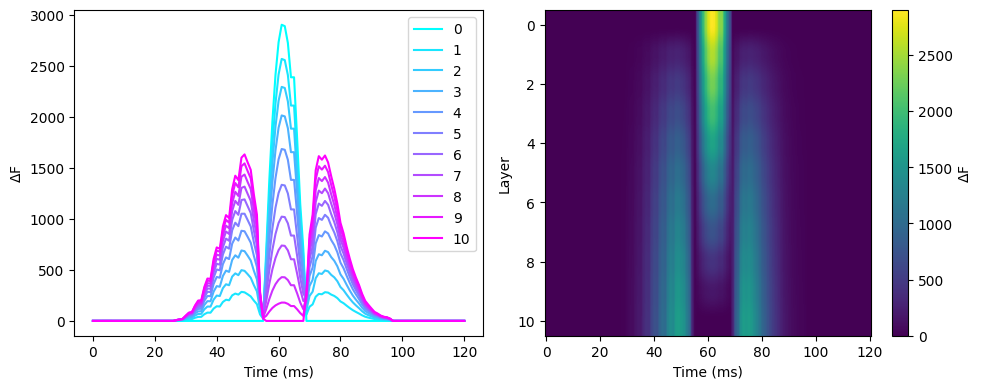

In [19]:
# Compute the relative free energy for each layer model, compared to the worst model at each time step
F_diff = np.zeros((Fs.shape[0],Fs.shape[1]))
for t in range(Fs.shape[1]):
    minF = np.min(Fs[:,t])
    F_diff[:,t] = Fs[:,t]-minF
    
col_r = plt.cm.cool(np.linspace(0,1, num=surf_set.n_layers))
plt.figure(figsize=(10,4))

# Plot relative free energy time series
plt.subplot(1,2,1)
for l in range(surf_set.n_layers):
    plt.plot(F_diff[l,:], label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

plt.subplot(1,2,2)
h=plt.imshow(F_diff,aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
col_r=plt.colorbar(h)
col_r.set_label(r'$\Delta$F')
plt.tight_layout()

In [20]:
spm.terminate()

# Delete simulation files
shutil.rmtree(tmp_dir)